# Clustering Player Groups from the NBA Roster

## 1. Executive Summary

Basketball is a sport in which numerous statistics can be derived from players. From points and assists, to blocks and steals, each basketball game offers rich data that people can make use of to generate insights. The objective of this study was to cluster players based on their statistics and attempt to identify who the best players are in the NBA, and which other players are most similar to them.

Player data per game was collected from the Basketball Reference Website for players in the 2018-2019 NBA season. The data was cleaned and preprocessed. Some preprocessing done includes: delimiter rows were removed, duplicated entries due to player trades were consolidated, numeric columns that were interpreted as objects were cast as numeric (int or float).

Exploratory data analysis was performed for the purpose of dimensionality reduction. Although manual feature selection based on domain knowledge was used to reduce dimensionality, correlations were also taken into account in removing variables. Furthermore, principal component analysis (PCA) was done in order to identify the features which contribute more to the variance. However, PCA was not used for any purpose other than for deriving insights for the manual feature selection.

The data was scaled using the MinMaxScaler in order to mitigate the effect of variables with large magnitudes. KMeans clustering was performed on the players for each of the five most recent seasons of the NBA, and it was discovered that two clusters stood out each year in terms of efficiency: the star Point Guard cluster and the star Center cluster. This does not mean that players from other positions could not excel - rather, they were clustered into one of these two clusters.

We concluded that in order to find the best of the best in the NBA, coaches should look out for the players in the two star clusters each year. These clusters are provided in the Conclusion section for reference.

## 2. Introduction

### 2.1. Context

Basketball is one of the most popular sports in the United States. Although it is a sport that can be summarized as simply as ten people trying to put a ball through a hoop, this sport has grown extensively, from its humble beginnings in a Canadian gym to being one of the most watched sports in terms of attendance.

The U.S. National Basketball Association, or NBA, leads in total attendance among basketball leagues, and is widely considered to be the premier men's professional basketball league in the world.

During the course of an NBA game, various numerical measures of a players performance are taken, such as the points accrued, or the missed shots caught (known as rebounds), and etc. These statistics offer the best objective measure of a player's (or team's) performance.

### 2.2. Objective of the Study

The baseline requirement of this mini-project is to cluster NBA players based on their statistics. 

As an additional objective, we attempted to identify the 'best' players in the NBA for the years 2019-2015 (reverse chronological order, prioritizing more recent years) through clustering.

Thus, the problem statement/question is as follows:

> Using clustering based on player statistics, who are the best players in the NBA, and which other players are most similar to them?

Of course, it is entirely possible to simply aggregate all statistics into one catch-all statistic and regard it as a measure of a player's efficiency or overall contribution, then take the players with the top efficiencies as the "best players"

However, rather than simply taking the top players, our objective with clustering is to identify other players with star potential. We intend to do so by taking the "top clusters", or the clusters which contain the best players, and identifying the other, less known players who fall into the same cluster. Not all of these players will have the top stats, but the mere fact that they are clustered with the best players indicates that they are similar to them, and may imply that they have some star potential.

### 2.3. Methodology Summary

#### 1. Data Collection
The data was collected from the **Basketball Reference** Website (https://www.basketball-reference.com/). The data in question is the player statistics per game.

#### 2. Cleaning and Preprocessing
The data was be cleaned into a manageable format and preprocessed. Values were normalized. 

#### 3. Dimensionality Reduction
Each basketball fan, player, and coach may have a different interpretation of which stats are most important to them. Fans of more physical and defensive basketball may find blocks, `BLK`, to be important, and 3-point Field Goal Percentage, `3P%`, to be less so. Thus, due to the subjective interpretation of what is important, three rounds of dimensionality reduction were performed.

* **Round 1.** Manual Feature Selection
    * By taking a look at the distributions of each statistic, as well as applying some domain knowledge, we identified variables that may be dropped from the feature array.
* **Round 2.** Correlations
    * Correlations between variables were visualized; some variables with high correlations were dropped in order to reduce multicollinearity.
* **Round 3.** Principal Component Analysis
    * PCA was performed to identify the principal components for additional insights on feature selection. However, PCA was not applied to the final feature array.

#### 4. Clustering
K-Means clustering was performed and the players were clustered. Clustering was done for each of the five seasons. Internal validation criteria were used to identify the best number of clusters to form.

## 3. Data Collection

### 3.0. Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests
from time import sleep
import os

import sqlite3

from IPython.display import HTML, display
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
from PIL import Image as PILImage
from wordcloud import WordCloud

import math

In [2]:
import sys
sys.path.append('../nba_playerclusters')
from nba_playerclusters.functions import *
from nba_playerclusters.config import *

### 3.1. Scraping

First, the data will be collected from the **Basketball Reference** Website (https://www.basketball-reference.com/). The data in question will be the player statistics (stats), taken from the per-game player stats per season. The rationale for choosing per-game player stats is that taking total stats may produce unexpected results, because:
* Some players play more games than others because of the coach's decision. Thus, these players will have more reliable statistics than those who play less.
* Players get injured during the course of the season, causing them to miss games.

The urls to be used are in the format:

https://www.basketball-reference.com/leagues/NBA_xxxx_per_game.html

Where `xxxx` signifies the year (NBA season).

See `notebooks/archive/Web Scraping Notebook.ipynb` for code used to acquire the data.

To illustrate the preprocessing without having to scrape the website again, the raw DataFrame (as obtained from the website) was saved to a CSV file and read in the cell below.

In [3]:
all_players_data_2019 = pd.read_csv(csv_2019_path)

In [4]:
all_players_data_2019.head()

Rk        Player Pos Age   Tm   G  GS    MP   FG   FGA  ...   FT%  ORB  DRB  \
0  1  Álex Abrines  SG  25  OKC  31   2  19.0  1.8   5.1  ...  .923  0.2  1.4   
1  2    Quincy Acy  PF  28  PHO  10   0  12.3  0.4   1.8  ...  .700  0.3  2.2   
2  3  Jaylen Adams  PG  22  ATL  34   1  12.6  1.1   3.2  ...  .778  0.3  1.4   
3  4  Steven Adams   C  25  OKC  80  80  33.4  6.0  10.1  ...  .500  4.9  4.6   
4  5   Bam Adebayo   C  21  MIA  82  28  23.3  3.4   5.9  ...  .735  2.0  5.3   

   TRB  AST  STL  BLK  TOV   PF   PTS  
0  1.5  0.6  0.5  0.2  0.5  1.7   5.3  
1  2.5  0.8  0.1  0.4  0.4  2.4   1.7  
2  1.8  1.9  0.4  0.1  0.8  1.3   3.2  
3  9.5  1.6  1.5  1.0  1.7  2.6  13.9  
4  7.3  2.2  0.9  0.8  1.5  2.5   8.9  

[5 rows x 30 columns]

### 3.2. Cleaning and Preprocessing

Now, data has been retrieved on about 734 players, with 30 columns of data. However, not all of these are player data. The tables on the page are not delimited by actually separating them, but by placing a delimiting row.

Let us look at a delimiting row erroneously read as a data row.

In [5]:
all_players_data_2019.loc[[186]]

Rk  Player  Pos  Age  Tm  G  GS  MP  FG  FGA  ...  FT%  ORB  DRB  TRB  \
186  Rk  Player  Pos  Age  Tm  G  GS  MP  FG  FGA  ...  FT%  ORB  DRB  TRB   

     AST  STL  BLK  TOV  PF  PTS  
186  AST  STL  BLK  TOV  PF  PTS  

[1 rows x 30 columns]

Thus, these have to be split into multiple tables by these rows. Let's find which of these rows are delimiters:

In [6]:
all_players_data_2019[all_players_data_2019['Rk']=='Rk'].index

Int64Index([ 22,  49,  70,  97, 132, 161, 186, 217, 244, 269, 297, 324, 349,
            382, 411, 438, 468, 498, 527, 554, 579, 606, 642, 671, 694, 715],
           dtype='int64')

Now deleting them:

In [7]:
all_players_data_2019.drop(all_players_data_2019[all_players_data_2019['Rk']=='Rk'].index, inplace=True)
all_players_data_2019.head()

Rk        Player Pos Age   Tm   G  GS    MP   FG   FGA  ...   FT%  ORB  DRB  \
0  1  Álex Abrines  SG  25  OKC  31   2  19.0  1.8   5.1  ...  .923  0.2  1.4   
1  2    Quincy Acy  PF  28  PHO  10   0  12.3  0.4   1.8  ...  .700  0.3  2.2   
2  3  Jaylen Adams  PG  22  ATL  34   1  12.6  1.1   3.2  ...  .778  0.3  1.4   
3  4  Steven Adams   C  25  OKC  80  80  33.4  6.0  10.1  ...  .500  4.9  4.6   
4  5   Bam Adebayo   C  21  MIA  82  28  23.3  3.4   5.9  ...  .735  2.0  5.3   

   TRB  AST  STL  BLK  TOV   PF   PTS  
0  1.5  0.6  0.5  0.2  0.5  1.7   5.3  
1  2.5  0.8  0.1  0.4  0.4  2.4   1.7  
2  1.8  1.9  0.4  0.1  0.8  1.3   3.2  
3  9.5  1.6  1.5  1.0  1.7  2.6  13.9  
4  7.3  2.2  0.9  0.8  1.5  2.5   8.9  

[5 rows x 30 columns]

The next concern is that some of the players were traded (sent to another team for a certain transaction) during the season. These are represented on the table as duplicate rows, such as for Avery Bradley:

In [8]:
all_players_data_2019[all_players_data_2019['Player']=='Avery Bradley']

Rk         Player Pos Age   Tm   G  GS    MP   FG   FGA  ...   FT%  ORB  \
73  63  Avery Bradley  SG  28  TOT  63  63  30.2  3.9   9.7  ...  .860  0.7   
74  63  Avery Bradley  SG  28  LAC  49  49  29.9  3.3   8.6  ...  .800  0.7   
75  63  Avery Bradley  SG  28  MEM  14  14  31.6  6.2  13.4  ...  .920  0.6   

    DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
73  2.1  2.8  2.4  0.7  0.3  1.4  2.7   9.9  
74  2.0  2.7  2.0  0.6  0.3  1.2  2.7   8.2  
75  2.6  3.1  4.0  1.0  0.0  2.0  2.4  16.1  

[3 rows x 30 columns]

Mr. Bradley started the season with the Los Angeles Clippers, `LAC`, and ended it with the Memphis Grizzlies, `MEM`. His total stats for the season are represented as `TOT`. The objective is now to replace `TOT` with `MEM`, and drop the rows of `LAC` and `MEM`.

In [9]:
all_traded = list(all_players_data_2019[all_players_data_2019['Tm']=='TOT']['Player'])

In [10]:
for traded_player in all_traded:
    player_df = all_players_data_2019[all_players_data_2019['Player']==traded_player]
    player_df.iloc[0][4] = player_df.iloc[-1][4]
    all_players_data_2019[all_players_data_2019['Player']==traded_player] = player_df
all_players_data_2019 = all_players_data_2019.drop_duplicates(subset=['Rk', 'Player'])

In [11]:
all_players_data_2019[all_players_data_2019['Player']=='Avery Bradley']

Rk         Player Pos Age   Tm   G  GS    MP   FG  FGA  ...   FT%  ORB  \
73  63  Avery Bradley  SG  28  MEM  63  63  30.2  3.9  9.7  ...  .860  0.7   

    DRB  TRB  AST  STL  BLK  TOV   PF  PTS  
73  2.1  2.8  2.4  0.7  0.3  1.4  2.7  9.9  

[1 rows x 30 columns]

Now, the duplicated players are represented using their total stats, and their teams are the final ones.

Taking a look at the data types:

In [12]:
all_players_data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 731
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rk      530 non-null    object
 1   Player  530 non-null    object
 2   Pos     530 non-null    object
 3   Age     530 non-null    object
 4   Tm      530 non-null    object
 5   G       530 non-null    object
 6   GS      530 non-null    object
 7   MP      530 non-null    object
 8   FG      530 non-null    object
 9   FGA     530 non-null    object
 10  FG%     526 non-null    object
 11  3P      530 non-null    object
 12  3PA     530 non-null    object
 13  3P%     494 non-null    object
 14  2P      530 non-null    object
 15  2PA     530 non-null    object
 16  2P%     520 non-null    object
 17  eFG%    526 non-null    object
 18  FT      530 non-null    object
 19  FTA     530 non-null    object
 20  FT%     503 non-null    object
 21  ORB     530 non-null    object
 22  DRB     530 non-null    ob

Since many are in object format, it is desired to convert them to numeric format whenever possible. Using `to_numeric`:

In [13]:
player_data_holder = pd.DataFrame()
for col in all_players_data_2019.columns:
    player_data_holder[col] = pd.to_numeric(all_players_data_2019[col], errors='ignore')

In [14]:
player_data_holder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 731
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      530 non-null    int64  
 1   Player  530 non-null    object 
 2   Pos     530 non-null    object 
 3   Age     530 non-null    int64  
 4   Tm      530 non-null    object 
 5   G       530 non-null    int64  
 6   GS      530 non-null    int64  
 7   MP      530 non-null    float64
 8   FG      530 non-null    float64
 9   FGA     530 non-null    float64
 10  FG%     526 non-null    float64
 11  3P      530 non-null    float64
 12  3PA     530 non-null    float64
 13  3P%     494 non-null    float64
 14  2P      530 non-null    float64
 15  2PA     530 non-null    float64
 16  2P%     520 non-null    float64
 17  eFG%    526 non-null    float64
 18  FT      530 non-null    float64
 19  FTA     530 non-null    float64
 20  FT%     503 non-null    float64
 21  ORB     530 non-null    float64
 22  DR

As indicated by the variable types above, the numeric objects have successfully been converted to integers or floats.

### 3.3. Storage and Retrieval

The function `scrape_and_store` allows us to scrape, clean/preprocess, and store data in an SQL table, for any year (as in the steps above).

The function `read_year` allows us to retrieve data for a particular year from the SQL table.

Both function codes may be found in `nba_playerclusters/nba_playerclusters/functions.py`.

In [15]:
df = read_year(2019, player_db)    
df.head()

Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  ...    FT%  \
Rk                                                              ...          
1   Álex Abrines  SG   25  OKC  31   2  19.0  1.8   5.1  0.357  ...  0.923   
2     Quincy Acy  PF   28  PHO  10   0  12.3  0.4   1.8  0.222  ...  0.700   
3   Jaylen Adams  PG   22  ATL  34   1  12.6  1.1   3.2  0.345  ...  0.778   
4   Steven Adams   C   25  OKC  80  80  33.4  6.0  10.1  0.595  ...  0.500   
5    Bam Adebayo   C   21  MIA  82  28  23.3  3.4   5.9  0.576  ...  0.735   

    ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
Rk                                                
1   0.2  1.4  1.5  0.6  0.5  0.2  0.5  1.7   5.3  
2   0.3  2.2  2.5  0.8  0.1  0.4  0.4  2.4   1.7  
3   0.3  1.4  1.8  1.9  0.4  0.1  0.8  1.3   3.2  
4   4.9  4.6  9.5  1.6  1.5  1.0  1.7  2.6  13.9  
5   2.0  5.3  7.3  2.2  0.9  0.8  1.5  2.5   8.9  

[5 rows x 29 columns]

## 4. EDA

### 4.1. Distributions of Variables

Prior to clustering it is important to gain insights on each of the variables. Simply performing dimensionality reduction on the data without understanding each of the variables is insufficient. In the following cell, the histogram of the distribution of each of the numeric variables will be plotted. It will be followed by an explanation of each variable, as well as a short statement on the distribution.

In anticipation of clustering, the distributions will need to be taken into account when choosing how to normalize each of the numeric variables; normally distributed variables will be normalized differently from skewed variables.

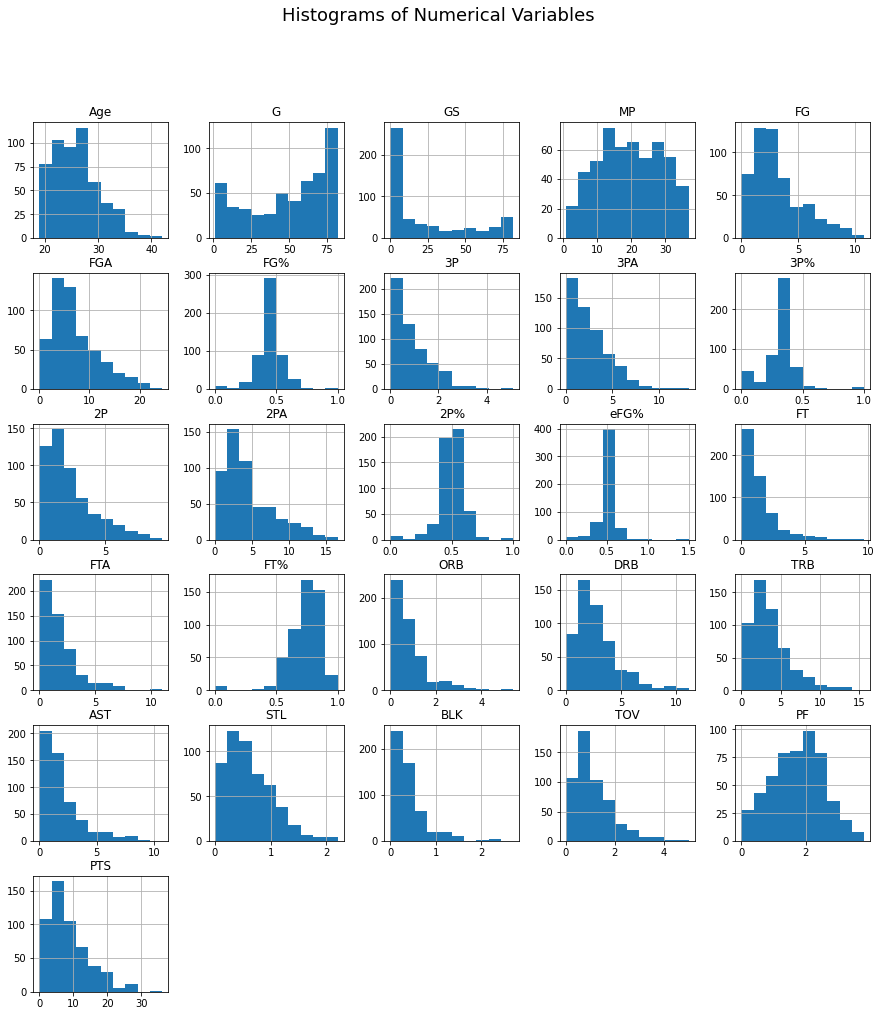

In [16]:
fig, ax = plt.subplots(figsize=(15, 16))
df.hist(ax=ax)
fig.suptitle("Histograms of Numerical Variables", fontsize=18)
plt.show()

#### Variables

#### Categorical and Object (Not Included in Histograms Above)
* `Pos` -- Position
* `Tm` -- Team

#### Numeric (Included in Histograms Above)
* `Age` -- Age of Player at the start of February 1st of that season.
* `G` -- Games - number of games played during the season
    * Negatively Skewed
* `GS` -- Games Started - number of games played in which the player was part of the on-court team at the beginning of the game
    * Positively Skewed
* `MP` -- Minutes Played - number of minutes played during a game
    * Approx. Normal
* `FG` -- Field Goals - number of counted 2-point and 3-point shots
    * Positively Skewed
* `FGA` -- Field Goal Attempts
    * Positively Skewed
* `FG%` -- Field Goal Percentage - FG/FGA
    * Approx. Normal
* `3P` -- 3-Point Field Goals - number of counted shots from further than the 3-point line
    * Positively Skewed
* `3PA` -- 3-Point Field Goal Attempts
    * Positively Skewed
* `3P%` -- FG% on 3-Pt FGAs - 3P/3PA
    * Approx. Normal
* `2P` -- 2-Point Field Goals - number of counted shots from inside the 3-point line
    * Positively Skewed
* `2PA` -- 2-point Field Goal Attempts
    * Positively Skewed
* `2P%` -- FG% on 2-Pt FGAs - 2P/2PA
    * Approx. Normal
* `eFG%` -- Effective Field Goal Percentage - This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
    * Approx. Normal
* `FT` -- Free Throws - number of counted foul shots (1 point each)
    * Positively Skewed
* `FTA` -- Free Throw Attempts
    * Positively Skewed
* `FT%` -- Free Throw Percentage -  FT/FTA
    * Negatively Skewed
* `ORB` -- Offensive Rebounds - number of successful rebounds from team's own missed shots
    * Positively Skewed
* `DRB` -- Defensive Rebounds - number of successful rebounds from opposing team's missed shots
    * Positively Skewed
* `TRB` -- Total Rebounds - ORB + DRB
    * Positively Skewed
* `AST` -- Assists - number of passes to a teammate in such a way that leads to a score by field goal
    * Positively Skewed
* `STL` -- Steals - legally-caused turnover by positive, aggressive action(s)
    * Positively Skewed
* `BLK` -- Blocks - legal deflection of a field goal attempt to prevent a score
    * Positively Skewed
* `TOV` -- Turnovers - loss of possession of the ball to the opposing team without a field goal attempt
    * Positively Skewed
* `PF` -- Personal Fouls - infraction of basketball rules other than violations
    * Approx. Normal
* `PTS` -- Points - weighted field goals (2-points and 3-points) plus number of FT
    * Positively Skewed

It is important to analyze the distributions of the variables for the purpose of normalization (as stated above), but it was found that there may be another application to doing this: dimensionality reduction. At first glance, it might seem intuitive to retain only one variable from each group (for example, for Free Throws, drop FTA and FT% and keep FT only) but from the distributions, this may not be the case. For example, with 3-pointers, 3P, 3PA, and 3P% all have different distributions, and the same goes for 2P and FT.

Generally, it is observed that some of the variables are approximately normally distributed (such as 2P% and FG%), but most variables are positively skewed. Thus, with these skewed stats, most NBA Players average at lower values, but there are a few players who stand out. These stand-out players will be discussed in the final report.


### 4.2. Dimensionality Reduction Round 1. Manual Feature Selection

#### Removing Hybrid Positions

We see that there are very few players that are 'hybrid', or they are listed at two (rather than just one) of the five positions. In order to simplify analysis, we will replace each hybrid player's position with the first listed position. For example, Harrison Barnes, listed as PF-SF, will be labeled simply as a PF.

In [17]:
df[df['Player']=='Harrison Barnes']

Player    Pos  Age   Tm   G  GS    MP   FG   FGA   FG%  ...  \
Rk                                                                   ...   
33  Harrison Barnes  PF-SF   26  SAC  77  77  32.9  5.6  13.3  0.42  ...   

      FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
Rk                                                       
33  0.824  0.7  3.9  4.7  1.5  0.6  0.2  1.3  1.6  16.4  

[1 rows x 29 columns]

In [18]:

df['Pos'] = df['Pos'].apply(replace_pos)

In [19]:
df[df['Player']=='Harrison Barnes']

Player Pos  Age   Tm   G  GS    MP   FG   FGA   FG%  ...    FT%  \
Rk                                                                ...          
33  Harrison Barnes  PF   26  SAC  77  77  32.9  5.6  13.3  0.42  ...  0.824   

    ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
Rk                                                
33  0.7  3.9  4.7  1.5  0.6  0.2  1.3  1.6  16.4  

[1 rows x 29 columns]

We can now perform our EDA by position.

### 4.2.1. Number of Players by Position

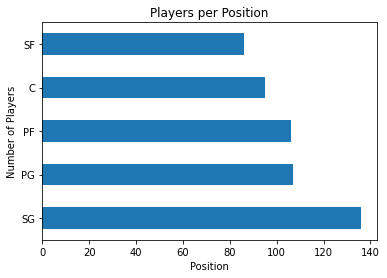

In [20]:
df['Pos'].value_counts().plot.barh()
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.title('Players per Position')
plt.show()

#### ANALYSIS
In the bar graph above, we see that Guard positions are the most numerous (particularly Shooting Guards), and the Small Forward is the least-populated position. Perhaps this is because SF are all-around, not particularly specialized towards playmaking (PG, SG) or physicality (C, PF).

Now, we will proceed to analyze the different numeric variables in the context of position, by using box plots.

### 4.2.2. Games, Games Started, and Minutes Played (G, GS, and MP)

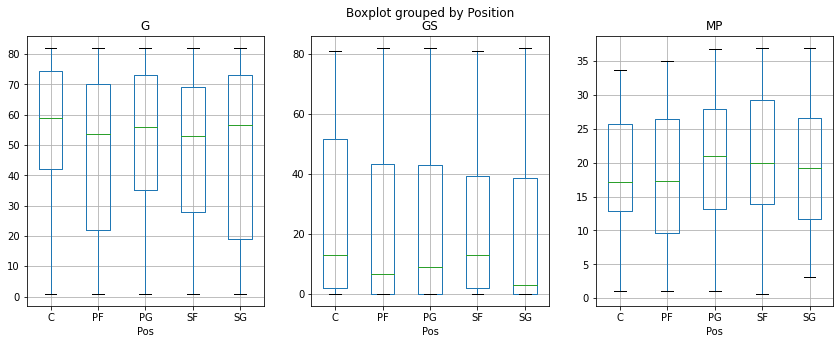

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
df.boxplot(column='G',by='Pos', ax=ax[0])
df.boxplot(column='GS',by='Pos', ax=ax[1])
df.boxplot(column='MP',by='Pos', ax=ax[2])
plt.suptitle('Boxplot grouped by Position')
plt.show()

#### ANALYSIS
For Games and Games Started, naturally, the lower and upper bounds are the same. However, we see that SF and C position players have a higher probability of starting a game, likely because there are fewer of them. Since SG are the most numerous, they have the lower likelihood of starting a game.

For Minutes Played, it immediately jumps out that C and PF players play for  less minutes than the other positions. This is likely because of the physical nature of how they play, which tires them out faster.

### 4.2.3. 3P, 3PA, and 3P%

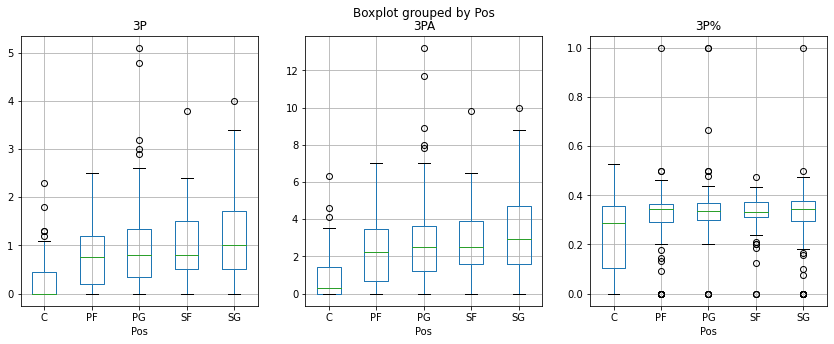

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
df.boxplot(column='3P',by='Pos', ax=ax[0])
df.boxplot(column='3PA',by='Pos', ax=ax[1])
df.boxplot(column='3P%',by='Pos', ax=ax[2])
plt.show()

#### ANALYSIS

Immediately we see some outliers here that are perfect from beyond the 3-point line. However, this does not necessarily mean that these are the best or most efficient players in terms of 3-pointers. Instead, it is more likely that the players with high `3P%` stats simply took too few shots to tease out their true shooting percentage.

In [23]:
df[df['3P%']==1][['Player', 'Pos', 'G', '3P', '3PA', '3P%']]

Player Pos  G   3P  3PA  3P%
Rk                                      
151   Trevon Duval  PG  3  0.3  0.3  1.0
319  Scott Machado  PG  4  0.3  0.3  1.0
359  Eric Moreland  PF  5  0.2  0.2  1.0
447  Jordan Sibert  SG  1  1.0  1.0  1.0

For instance, we have Eric Moreland, who played the most games among the four above, but is waived (let go of by the team) almost every season he is in the NBA. Thus, we have two choices:

* Drop `3P%` - `3P` might be a better stat to keep than `3P%`.
* Filter out players who played less than 10 games throughout the season, in order to remove outliers such as these

In keeping with the objective of the study, which is to identify the cluster of players who are the "best of the best", it is more feasible to pick the second option and drop players who played very few games.

In [24]:
df = df[df['G'] > 15]
df_complete = df.copy()

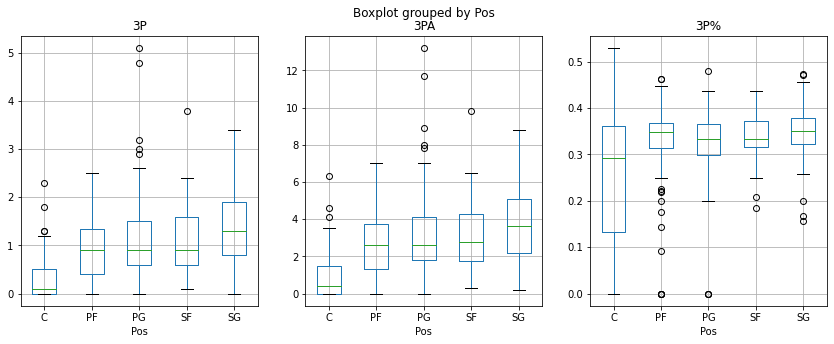

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
df.boxplot(column='3P',by='Pos', ax=ax[0])
df.boxplot(column='3PA',by='Pos', ax=ax[1])
df.boxplot(column='3P%',by='Pos', ax=ax[2])
plt.show()

#### ANALYSIS

Shooting Guards generally have the best 3-point percentage, and the most 3-pointers made. This is expected, as the Shooting Guards are the players which teams depend on to provide reliable shooting output. However, outliers in the Point Guard position (Stephen Curry a notable example) provide the absolute maximum output in terms of 3-pointers.

Based on the distributions above, 3-pointers are a good stat to classify players as the distribution is spread wide, offering good contrast/differentiation between players.

In [26]:
print()
display(HTML("Top 10 3-Point Scorers by 3P made:"))
display(df.sort_values('3P', ascending=False)[['Player', 'Pos', 'G', '3P', '3PA', '3P%']].head(5))
print()
display(HTML("Top 10 3-Point Scorers by 3P%:"))
display(df.sort_values('3P%', ascending=False)[['Player', 'Pos', 'G', '3P', '3PA', '3P%']].head(5))

Player Pos   G   3P   3PA    3P%
Rk                                          
124  Stephen Curry  PG  69  5.1  11.7  0.437
206   James Harden  PG  78  4.8  13.2  0.368
183    Paul George  SF  77  3.8   9.8  0.386
224    Buddy Hield  SG  82  3.4   7.9  0.427
190    Eric Gordon  SG  68  3.2   8.8  0.360

Player Pos   G   3P  3PA    3P%
Rk                                               
434     Domantas Sabonis   C  74  0.1  0.2  0.529
97   Willie Cauley-Stein   C  81  0.0  0.0  0.500
95           Alex Caruso  PG  25  1.0  2.0  0.480
211           Joe Harris  SG  76  2.4  5.1  0.474
12          Kadeem Allen  SG  19  0.9  1.9  0.472

With the exception of Willie Cauley-Stein, who obtained a high 3P% due to only making two 3PA and successfully making one 3P for the entire season, all of the Top 10 3-Point Scorers above now seem like they deserve to be there.

### 4.2.4. 2P, 2PA, and 2P%

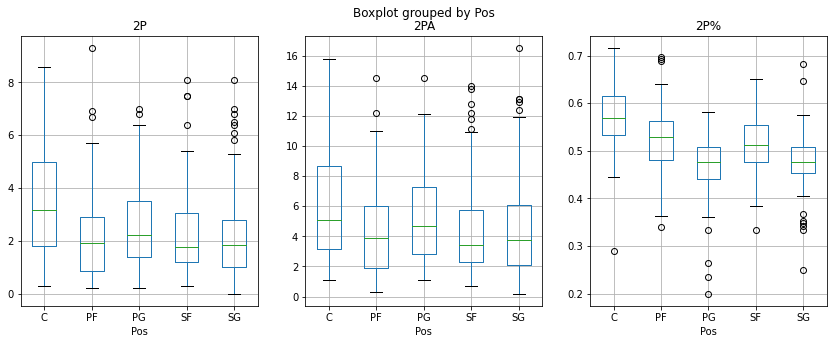

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
df.boxplot(column='2P',by='Pos', ax=ax[0])
df.boxplot(column='2PA',by='Pos', ax=ax[1])
df.boxplot(column='2P%',by='Pos', ax=ax[2])
plt.show()

#### ANALYSIS
Center players generally have the best 2-point percentage, and the most 2-pointers made. This is because Center players typically have the power and strength to force plays and shots 'in low' (close to the basket). These up-close-and-personal plays have higher percentages than shots further out, which shooting guards tend to take.

### 4.2.5. eFG%

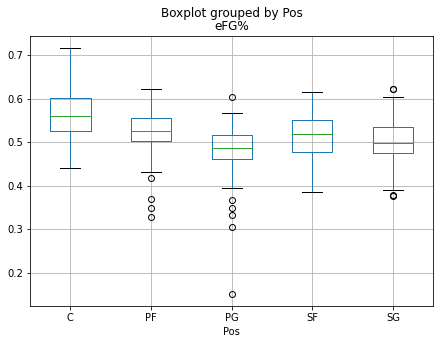

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
df.boxplot(column='eFG%', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Despite adjusting for the importance of 3-point shots, Center players are the most efficient scorers as far as eFG% is concerned.

Using this statistic for clustering will increase the emphasis on field goal percentage. It is important to note that 2P% and 3P%, which are already accounted for, will be considered once again when using eFG%. Since eFG% is probably a better reflection of a player's scoring efficiency, we will drop FG% and keep eFG%.

Also, we will drop FG and FGA since these are already reflected in 2P, 3P, 2PA, and 3PA.


### 4.2.6. FT, FTA, and FT%

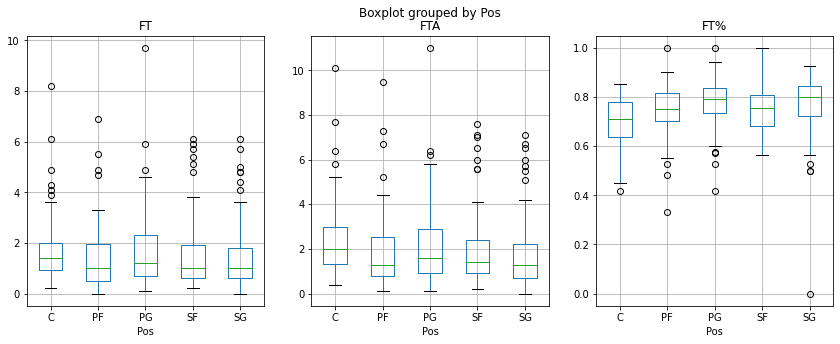

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
df.boxplot(column='FT',by='Pos', ax=ax[0])
df.boxplot(column='FTA',by='Pos', ax=ax[1])
df.boxplot(column='FT%',by='Pos', ax=ax[2])
plt.show()

#### ANALYSIS
Guards (Shooting Guards and Point Guards) tend to have the best Free Throw percentages.

Free throw statistics might not be apt to include in the feature array for clustering later on, since we see that the statistics are fairly similar in terms of distribution across positions, thus possibly reducing contrast. 

We will drop Free Throw Statistics in order to reduce the noise in the dataset, and focus on more important features

### 4.2.7. TRB, DRB, and ORB

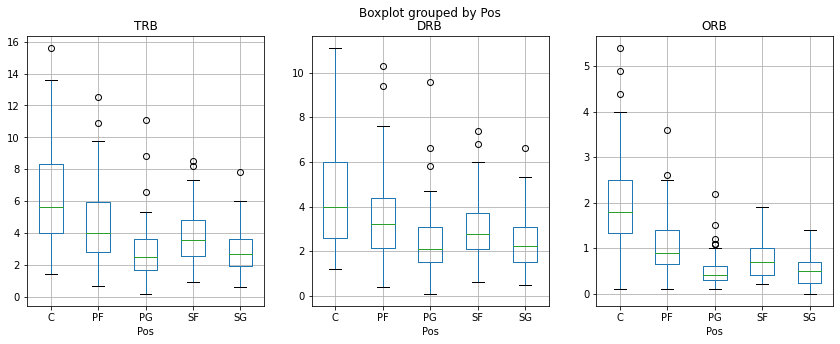

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
df.boxplot(column='TRB',by='Pos', ax=ax[0])
df.boxplot(column='DRB',by='Pos', ax=ax[1])
df.boxplot(column='ORB',by='Pos', ax=ax[2])
plt.show()

#### ANALYSIS
Center players have the most Total Rebounds, and also have the most rebounds of each kind (ORB and DRB). Since Center players stay the closest to the basket (from which missed shots tend to bounce off of), are the tallest in the league, and also tend to be the strongest, they are naturally inclined to be the players who are able to catch the most rebounds.

We also notice that the distributions for all three variables above look similar. Thus, we can drop at least one of the three. We will use correlations to determine which one/s to drop.

### 4.2.8. AST

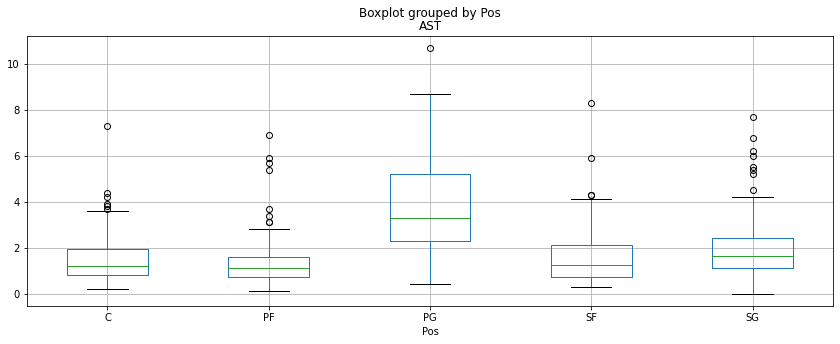

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
df.boxplot(column='AST', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Naturally, Point Guards are the AST leaders, since they are responsible for handling the ball and calling plays (strategies) for the team. The Point Guards usually make the passes to the players.

Since no other statistic is similar to AST, it will definitely be used for clustering.

### 4.2.9. STL

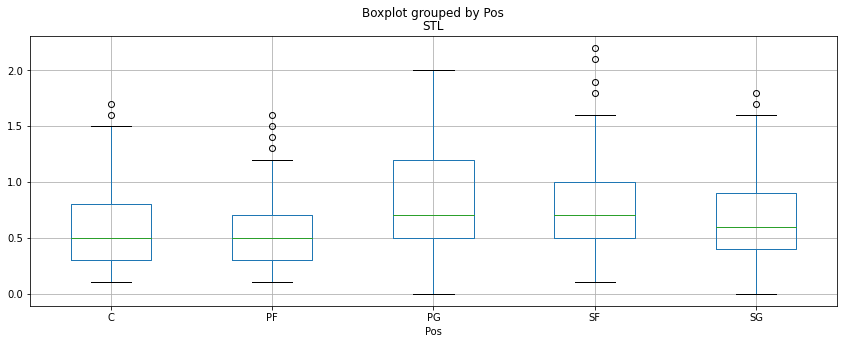

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
df.boxplot(column='STL', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Point Guards are the predominant stealers in the NBA.

Once again, no other statistic is similar to STL. Thus, it will be used for clustering.

### 4.2.10. BLK

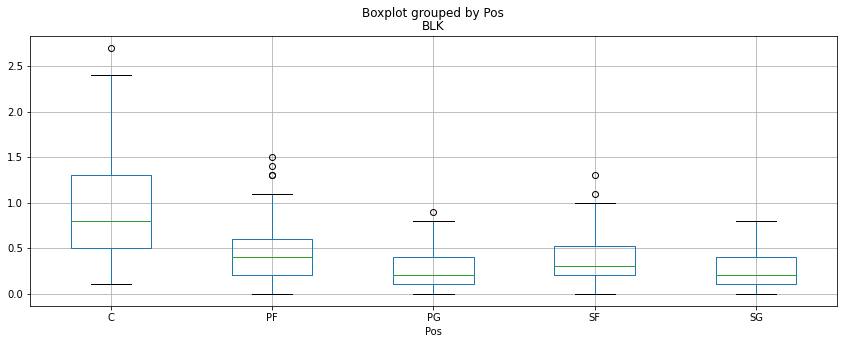

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
df.boxplot(column='BLK', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Center players are the predominant shot blockers in the NBA, owing to their large stature.

Like with steals, no other statistic is similar to BLK. Thus, it will be used for clustering.

### 4.2.11. TOV

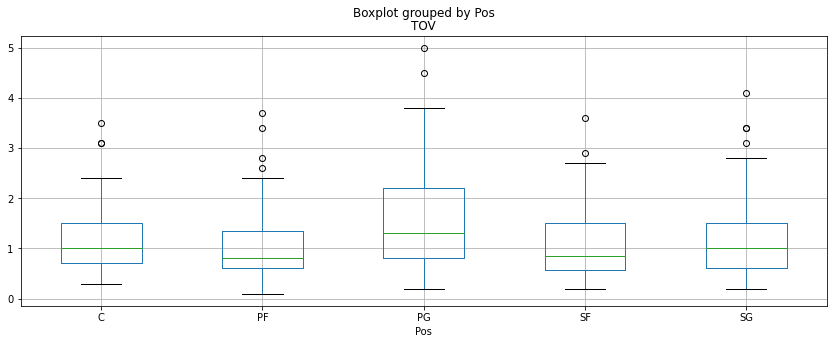

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
df.boxplot(column='TOV', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Because Point Guards usually handle the ball, they also incur the most turnovers.

Like with STL and BLK, no other statistic is similar to TOV. 

However, with TOV, a lower number is preferable, because losing the ball to the opposing team is undesirable. Thus, we will reverse turnovers after scaling and call this statistic ITO (Inverse Turnovers).

### 4.2.12. PF

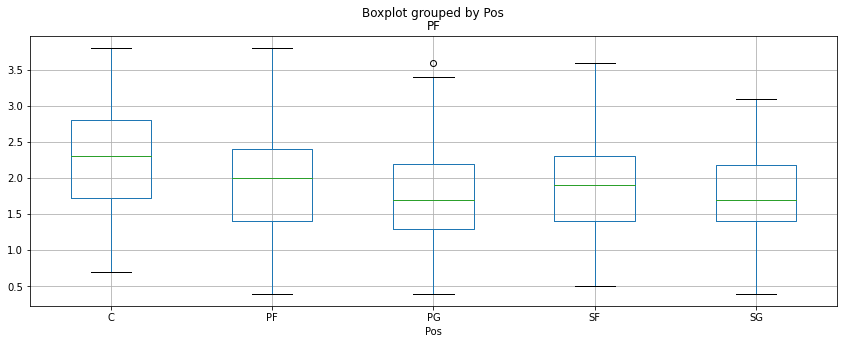

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
df.boxplot(column='PF', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Center and Power Forward players incur the most fouls per game, likely due to the physical nature of the way they play. This increases the possibility of committing fouls against the opposing players.

Like with TOV, a lower number is preferable, and we will reverse PF after scaling and call this statistic IPF (Inverse Personal Fouls).

### 4.2.13. PTS

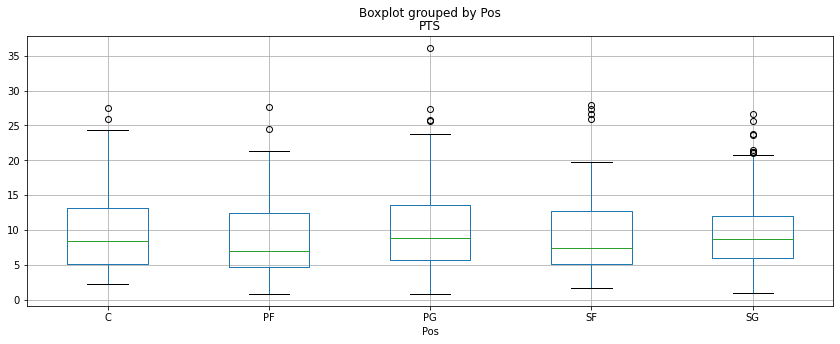

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
df.boxplot(column='PTS', by='Pos', ax=ax)
plt.show()

#### ANALYSIS
Despite the connotation of the word 'Shoot' in 'Shooting Guard', we see that the `PTS` contribution is fairly similar across positions. However, we cannot drop this stat as domain knowledge tells us that PTS are extremely important, owing to the fact that games are won on the basis of total team `PTS`. 

Thus, we will weight this statistic and arbitrarily consider it to be twice as important as the other stats, after scaling.

## 5. Other Dimensionality Reduction

### 5.1. Dimensionality Reduction Round 2: Correlations

A problem when working with data is multicollinearity - a state of very high intercorrelations or inter-associations among the variables. In order to identify and possibly remove variables that are highly correlated with each other, we will visualize the relationships between the variables.

In [37]:
numer_cols = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
# prp = sns.pairplot(df[numer_cols].fillna(0), diag_kind="hist", kind = "reg")

Pair plotting would have been performed to attempt to identify if relationships exist between the variables. However, doing this will be computationally expensive, and will be very difficult to read due to the high dimensionality. Instead, we will use a heatmap to attempt to visualize linear correlations between the variables. This kind of visualization can show the correlations more concisely, at the cost of not displaying the scatter plots.

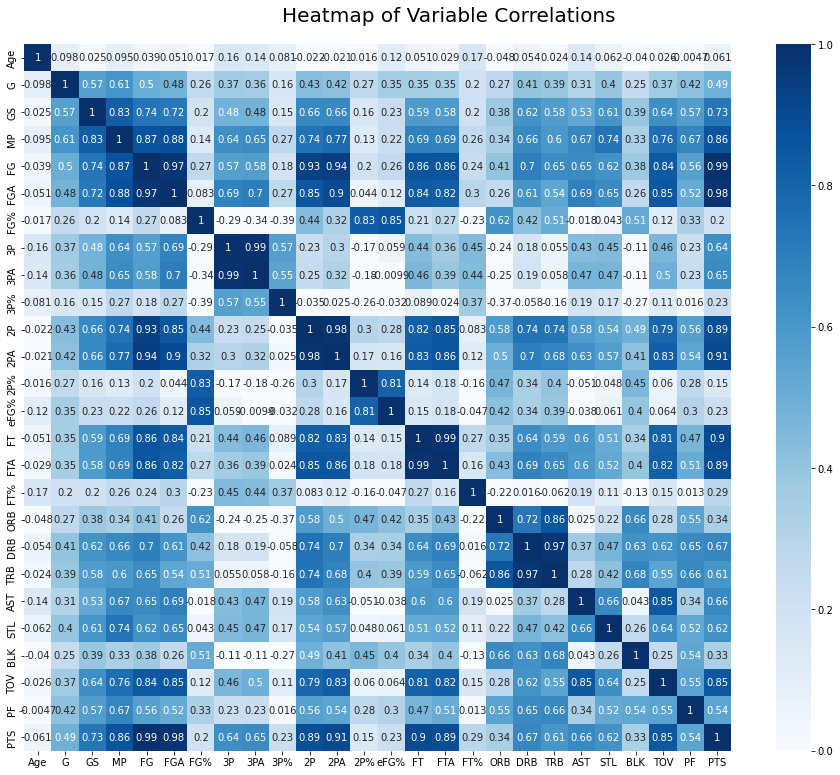

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16, 13))
hmp = sns.heatmap(df[numer_cols].fillna(0).corr(), vmin=0, vmax=1, cmap='Blues', annot=True, square=True, ax=ax)
fig.suptitle("Heatmap of Variable Correlations", fontsize=20, y=0.92)
plt.show()

In [39]:
df_corr = df[numer_cols].fillna(0).corr()
signif = df_corr > 0.9
print("Variables with high correlations")
print("--------------------------------")
for col in signif.columns:
    print(col)
    high_corrs = signif[signif[col]==True].index.tolist()
    has_high_corr = False
    for var in high_corrs:
        if var != col:
            has_high_corr = True
            print('\t> {} - correlation = {:.2f}%'.format(var, df_corr[col][var]*100))
    if not(has_high_corr):
        print("\t**No variables with correlations higher than 90%.**")

Variables with high correlations
--------------------------------
Age
	**No variables with correlations higher than 90%.**
G
	**No variables with correlations higher than 90%.**
GS
	**No variables with correlations higher than 90%.**
MP
	**No variables with correlations higher than 90%.**
FG
	> FGA - correlation = 97.45%
	> 2P - correlation = 93.20%
	> 2PA - correlation = 94.29%
	> PTS - correlation = 98.86%
FGA
	> FG - correlation = 97.45%
	> PTS - correlation = 98.18%
FG%
	**No variables with correlations higher than 90%.**
3P
	> 3PA - correlation = 98.68%
3PA
	> 3P - correlation = 98.68%
3P%
	**No variables with correlations higher than 90%.**
2P
	> FG - correlation = 93.20%
	> 2PA - correlation = 98.28%
2PA
	> FG - correlation = 94.29%
	> 2P - correlation = 98.28%
	> PTS - correlation = 90.60%
2P%
	**No variables with correlations higher than 90%.**
eFG%
	**No variables with correlations higher than 90%.**
FT
	> FTA - correlation = 98.51%
	> PTS - correlation = 90.01%
FTA
	> FT - c

#### ANALYSIS
In addition to the variables that were to be dropped as discussed in the previous section of the EDA, for each pair of variables with a correlation above 90%, we will drop at most one. However, deciding which of the two we will drop requires some discussion.

* FG, FGA, and FG%; 2P, 2PA, and 2P%; 3P, 3PA, and 3P%; FT, FTA, and FT% - For these variables, we will drop the number of shots attempted (FGA, 2PA, 3PA, and FTA). This is because the percentage can be derived from the two i.e. $FG\% = \frac{FG}{FGA}$. However, we cannot drop the number of shots made (2P and 3P) because they are not "highly correlated" with the percentage.
* FG and PTS - using PTS will give us a good idea of the total output of a player, since percentage does not tell us anything about how many shots were actually made or attempted. Thus, we will give PTS 2x higher weight than the other measures.
* FG% and eFG% - we will drop FG% as discussed in the EDA. We want to separate 2P% and 3P%. In other words, we will separate a person with high 2P% and low 3P% from another person with high 3P% but low 2P%.
* DRB and TRB - we will drop TRB because it accounts for ORB a second time ($\text{TRB} = \text{DRB} + \text{ORB}$). Thus, players will be clustered using ORB and DRB. The reason that both will be kept, rather than dropping them and keeping TRB, is because offensive rebounds tend to be executed much more often by a different class of players than defensive rebounds (big men such as Power Forwards and Centers have much more ORB than other positions).


In addition, all of the statistics have positive connotations - that is to say, it is desirable for a player to increase the values of these variables, except for TOV (Turnovers) and PF (Personal Fouls), which players wish to reduce. Thus, we will construct two new variables, Inverse Turnovers (ITO), and Inverse Personal Fouls (IPF), which are the inverses of TOV and PF, respectively.

In [40]:
pd.options.mode.chained_assignment = None 
df.loc[:, 'ITO'] = df.loc[:, 'TOV'].apply(lambda x: 1/x)
df.loc[:, 'IPF'] = df.loc[:, 'PF'].apply(lambda x: 1/x)

### 5.3. Dimensionality Reduction Round 3: Principal Components

At this point, we will use PCA to identify the principal components of the dataset. However, we may or may not push through with actually using PCA on the final feature array.

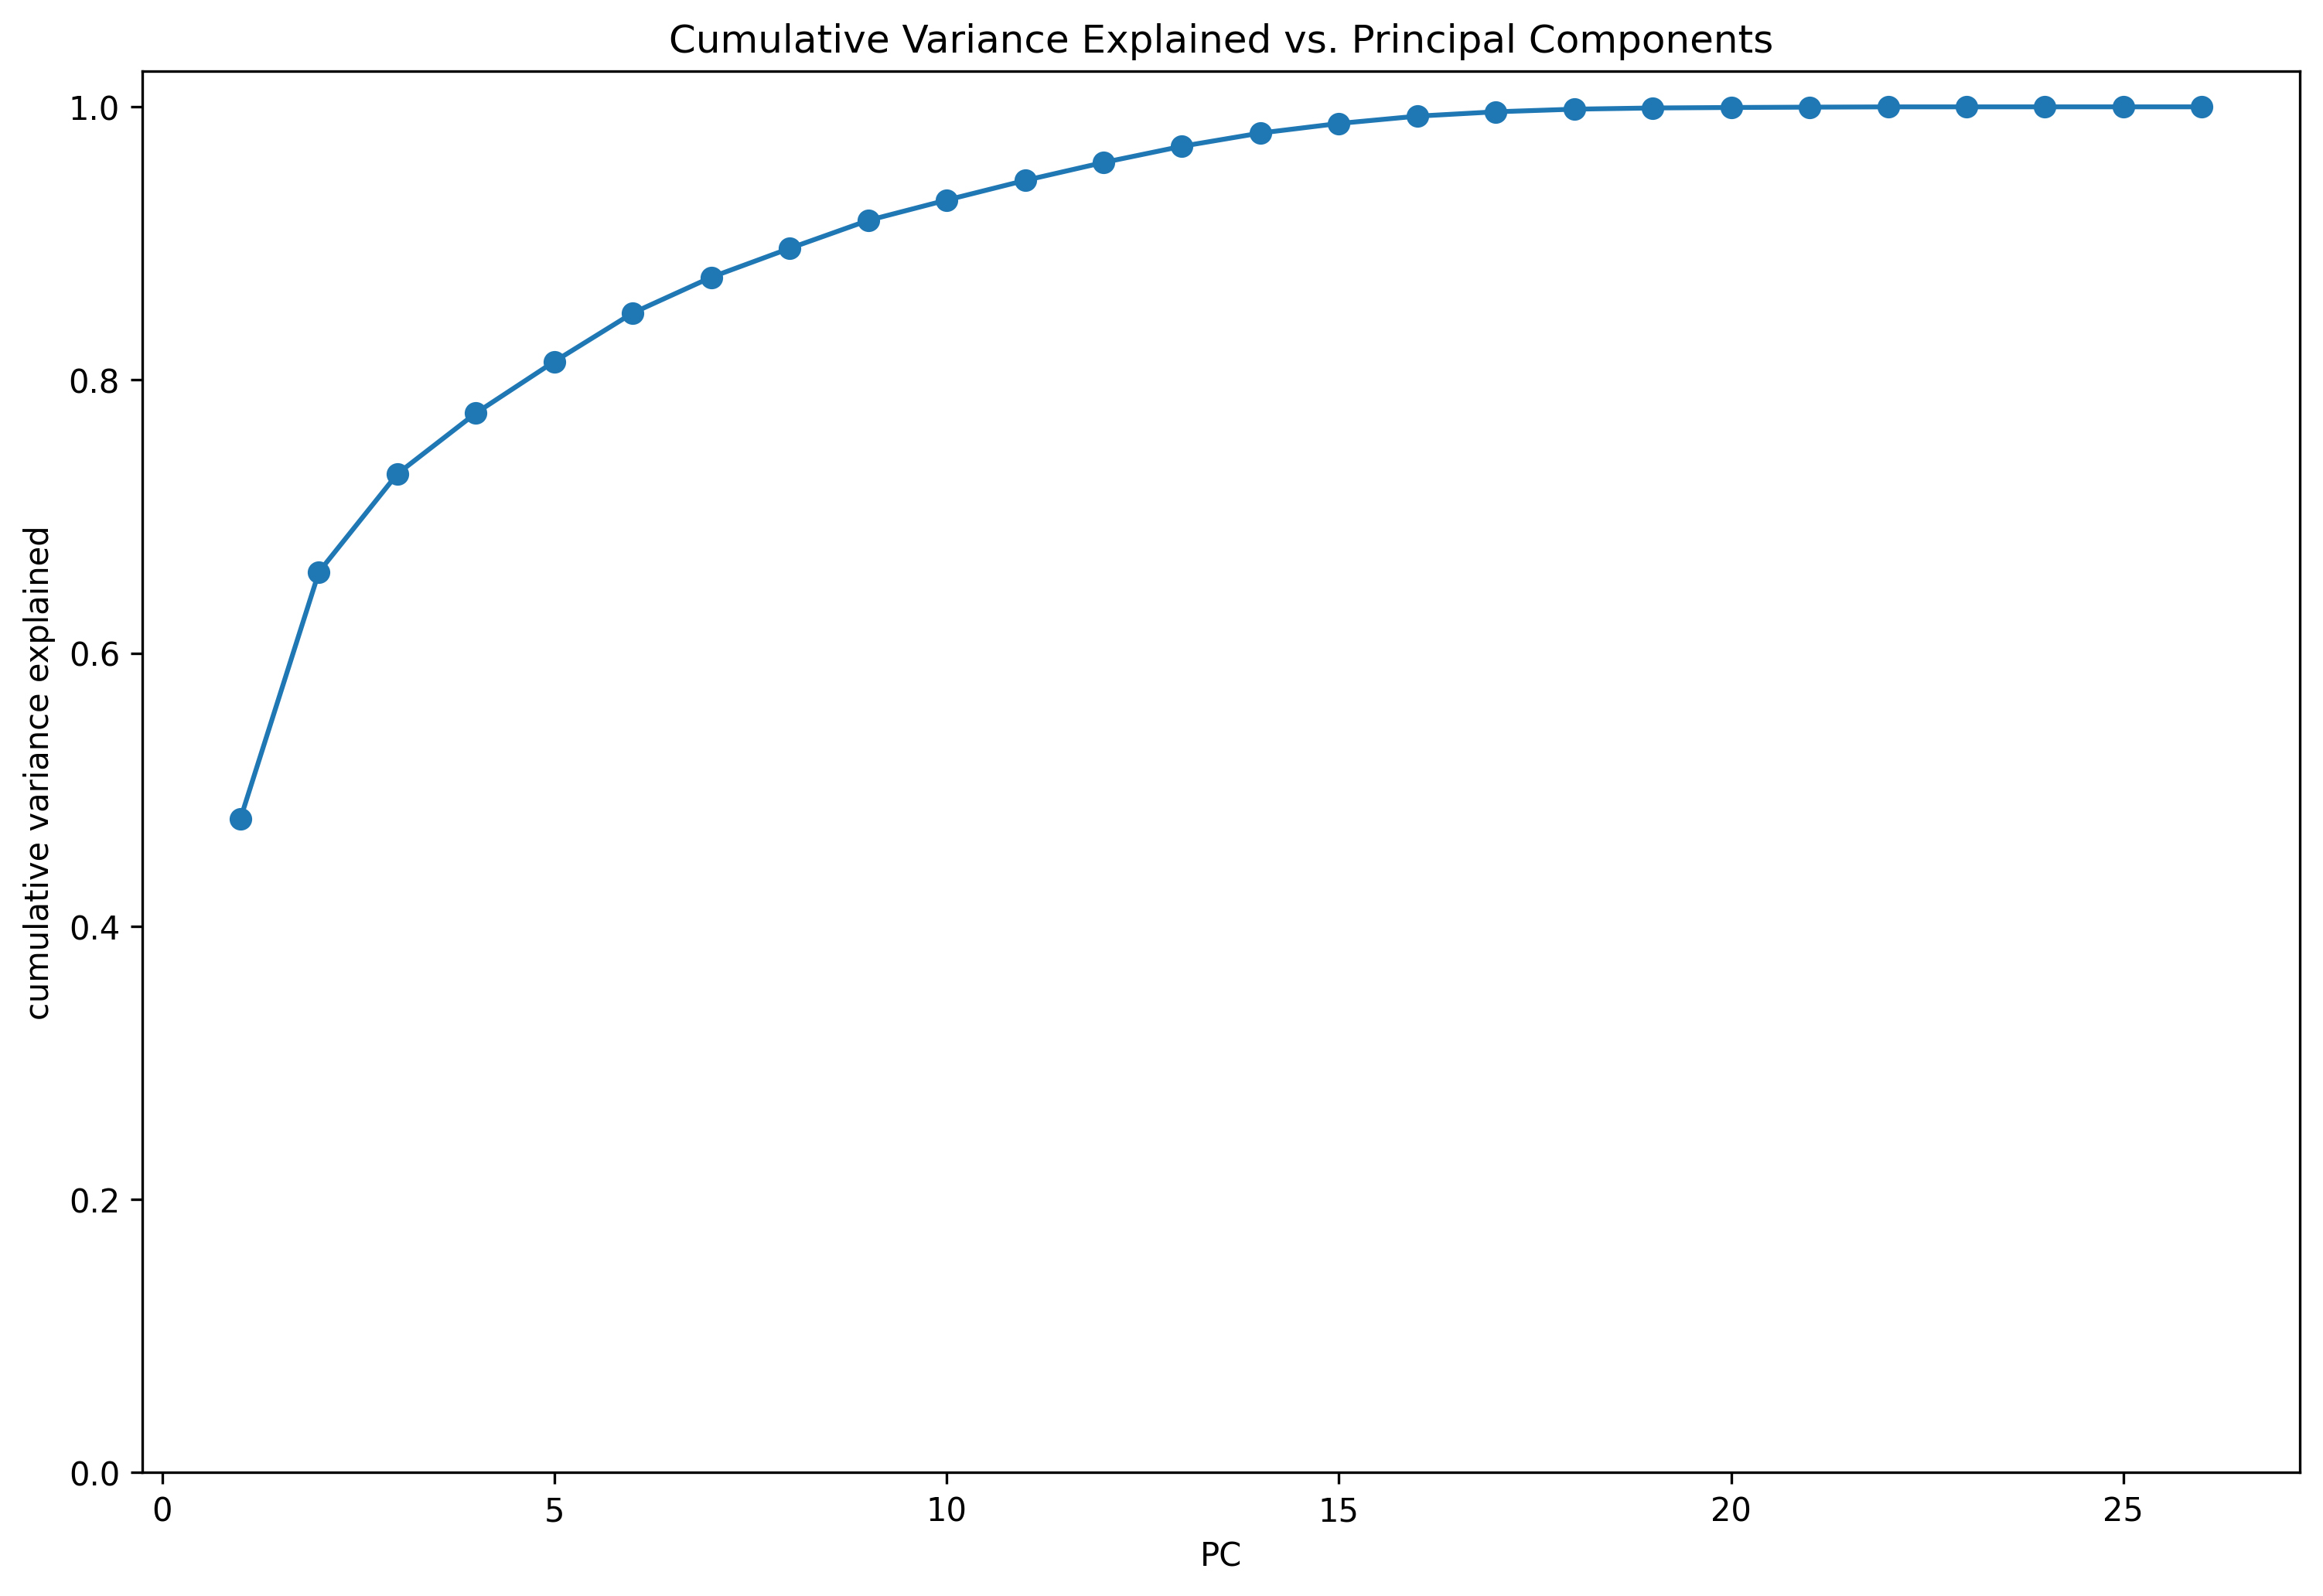

Need 5 components to explain 80% of variance.


In [41]:
df_features_complete = df[numer_cols].fillna(0)
standard_scaler = StandardScaler()
X_std = standard_scaler.fit_transform(df_features_complete.to_numpy())
V = np.cov(X_std, rowvar=False)
lambdas, w = np.linalg.eig(V)
indices = np.argsort(lambdas)[::-1]
lambdas = lambdas[indices]
w = w[:, indices]
new_X = np.dot(X_std, w)
var_explained = lambdas / lambdas.sum()
cum_var_explained = var_explained.cumsum()
fig, ax = plt.subplots(dpi=300, figsize=(12, 8))
ax.plot(np.arange(1, len(cum_var_explained)+1), cum_var_explained, '-o')
ax.set_title('Cumulative Variance Explained vs. Principal Components')
ax.set_ylim(bottom=0)
ax.set_xlabel('PC')
ax.set_ylabel('cumulative variance explained')
plt.show()
print("Need 5 components to explain 80% of variance.")
trunc_new_X = new_X[:,:5]

#### ANALYSIS
Based on the graph of cumulative variance explained, we need 5 components to explain 80% of the variance.

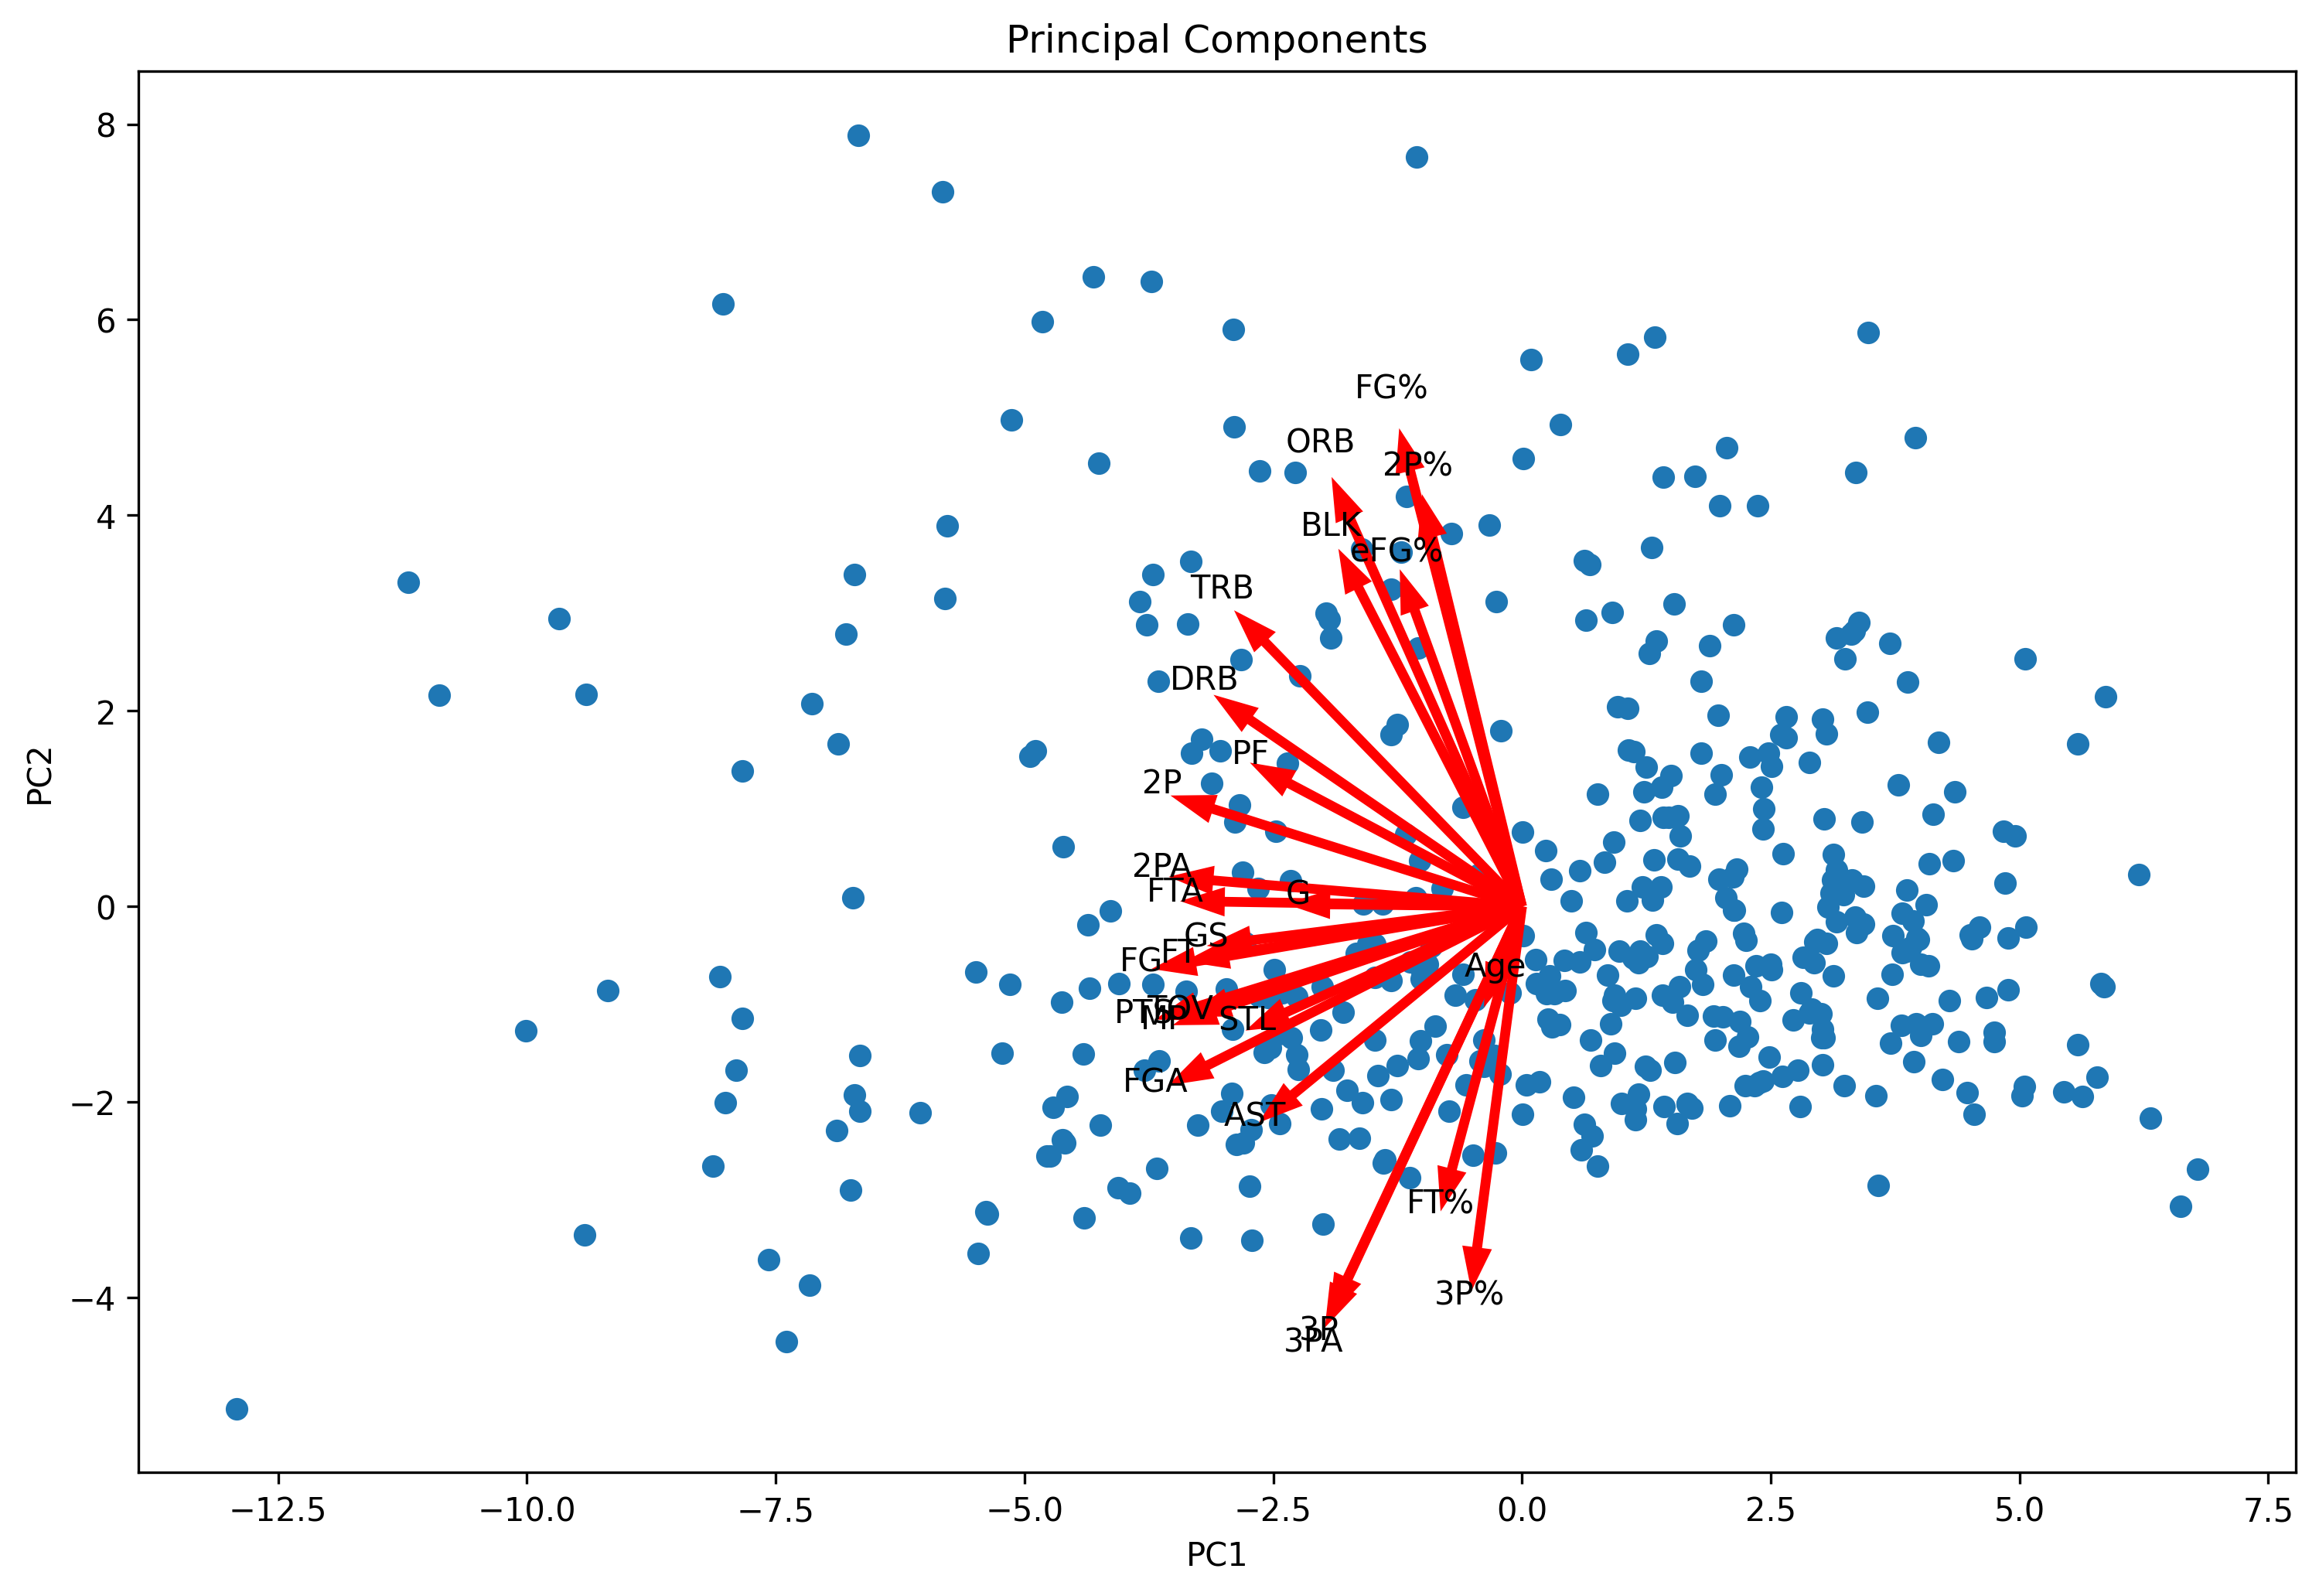

In [42]:
fig, ax = plt.subplots(dpi=300, figsize=(12, 8))
ax.scatter(new_X[:,0], new_X[:,1])
for feat, feat_name in zip(w, df_features_complete.columns):
    ax.arrow(0, 0, 12*feat[0], 12*feat[1], color='r', width=0.1, ec='none')
    ax.text(14*feat[0], 14*feat[1], feat_name, ha='center', color='k')
ax.set_title('Principal Components')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

#### ANALYSIS
2PA, FTA, 2P, and FG are quite close to the principal component PC1, meaning that they explain a larger amount of variance in the data. Also, G and GS are close are well. This was to be expected on the part of FG, but is quite surprising on the part of G and GS. It is possible that G and GS are also an indication of how valuable a player is, since coaches are more willing to let them play more (or less) games.


Also, the Field Goal Percentage Measures such as FG% and 3P% are closest to perpendicularity to PC1, implying that they may not be as effective at explaining variance. This is likely because players can have high percentages without providing much output (such as our example earlier with Eric Moreland).

#### VERDICT
Revise manual feature selection as follows: 
* retain `FG` and `FT` in the feature array. 
* drop 2P% and 3P%

However, we will proceed to drop the attempts made such as `2PA` because in determining valuable players, we are more concerned with how many shots were actually made rather than the attempts.

In [43]:
to_drop = ['MP', 'FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'TRB', 'TOV', 'PF']
maybe_drop = ['Pos', 'Age', 'G', 'GS', 'MP']
labels = ['Player', 'Pos', 'Tm', 'Age']
print('Features to drop:')
for feat in to_drop:
    print('  ' + feat)

Features to drop:
  MP
  FGA
  FG%
  3PA
  3P%
  2PA
  2P%
  FTA
  FT%
  TRB
  TOV
  PF


Dropping the above features:

In [44]:
df_features = df.drop(columns=to_drop+labels+maybe_drop).fillna(0)
X = df_features.to_numpy()
df_features.head()

FG   3P   2P   eFG%   FT  ORB  DRB  AST  STL  BLK   PTS       ITO  \
Rk                                                                       
1   1.8  1.3  0.5  0.487  0.4  0.2  1.4  0.6  0.5  0.2   5.3  2.000000   
3   1.1  0.7  0.4  0.459  0.2  0.3  1.4  1.9  0.4  0.1   3.2  1.250000   
4   6.0  0.0  6.0  0.595  1.8  4.9  4.6  1.6  1.5  1.0  13.9  0.588235   
5   3.4  0.0  3.4  0.579  2.0  2.0  5.3  2.2  0.9  0.8   8.9  0.666667   
6   0.6  0.3  0.3  0.389  0.2  0.2  0.8  0.3  0.1  0.2   1.7  3.333333   

         IPF  
Rk            
1   0.588235  
3   0.769231  
4   0.384615  
5   0.400000  
6   1.428571

## 6. Clustering

### 6.1. Scaling

When clustering without scaling or normalization, features having large ranges will implicitly assign greater efforts in the metrics compared to the application with features having smaller ranges. (Aksoy and Haralick, 2001)

Thus, some form of scaling is required to reduce the features into dimensionless data.

Since the histograms produced in the EDA showed some features that were not normally distributed, we scaled the data using the sklearn.preprocessing.MinMaxScaler, which transforms features by scaling each feature to a given range. It scales and translates each feature individually such that it is between zero and one.

First five rows of the scaled feature array:

In [45]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
X_scaled = mm_scaler.transform(X)
if np.max(X_scaled[:, -3]) == 1.:
    X_scaled[:, -3] = X_scaled[:, -3] / 2
X_scaled[:5, :]

array([[0.1509434 , 0.25490196, 0.05376344, 0.59397163, 0.04123711,
        0.03703704, 0.11818182, 0.05607477, 0.22727273, 0.07407407,
        0.0625    , 0.18367347, 0.14532872],
       [0.08490566, 0.1372549 , 0.04301075, 0.54432624, 0.02061856,
        0.05555556, 0.11818182, 0.17757009, 0.18181818, 0.03703704,
        0.03267045, 0.10714286, 0.22624434],
       [0.54716981, 0.        , 0.64516129, 0.78546099, 0.18556701,
        0.90740741, 0.40909091, 0.14953271, 0.68181818, 0.37037037,
        0.18465909, 0.03961585, 0.05429864],
       [0.30188679, 0.        , 0.3655914 , 0.7570922 , 0.20618557,
        0.37037037, 0.47272727, 0.20560748, 0.40909091, 0.2962963 ,
        0.11363636, 0.04761905, 0.06117647],
       [0.03773585, 0.05882353, 0.03225806, 0.42021277, 0.02061856,
        0.03703704, 0.06363636, 0.02803738, 0.04545455, 0.07407407,
        0.01136364, 0.31972789, 0.5210084 ]])

### 6.2. Visualization Using TSNE

Next, we use TSNE, which is an algorithm that allows us to visualize high-dimensionality datasets in two dimensions. We assign a `random_state` in order to provide consistency of results across executions of the notebook.

We reduce the feature array to two dimensions using TSNE, then visualize using a scatter plot:

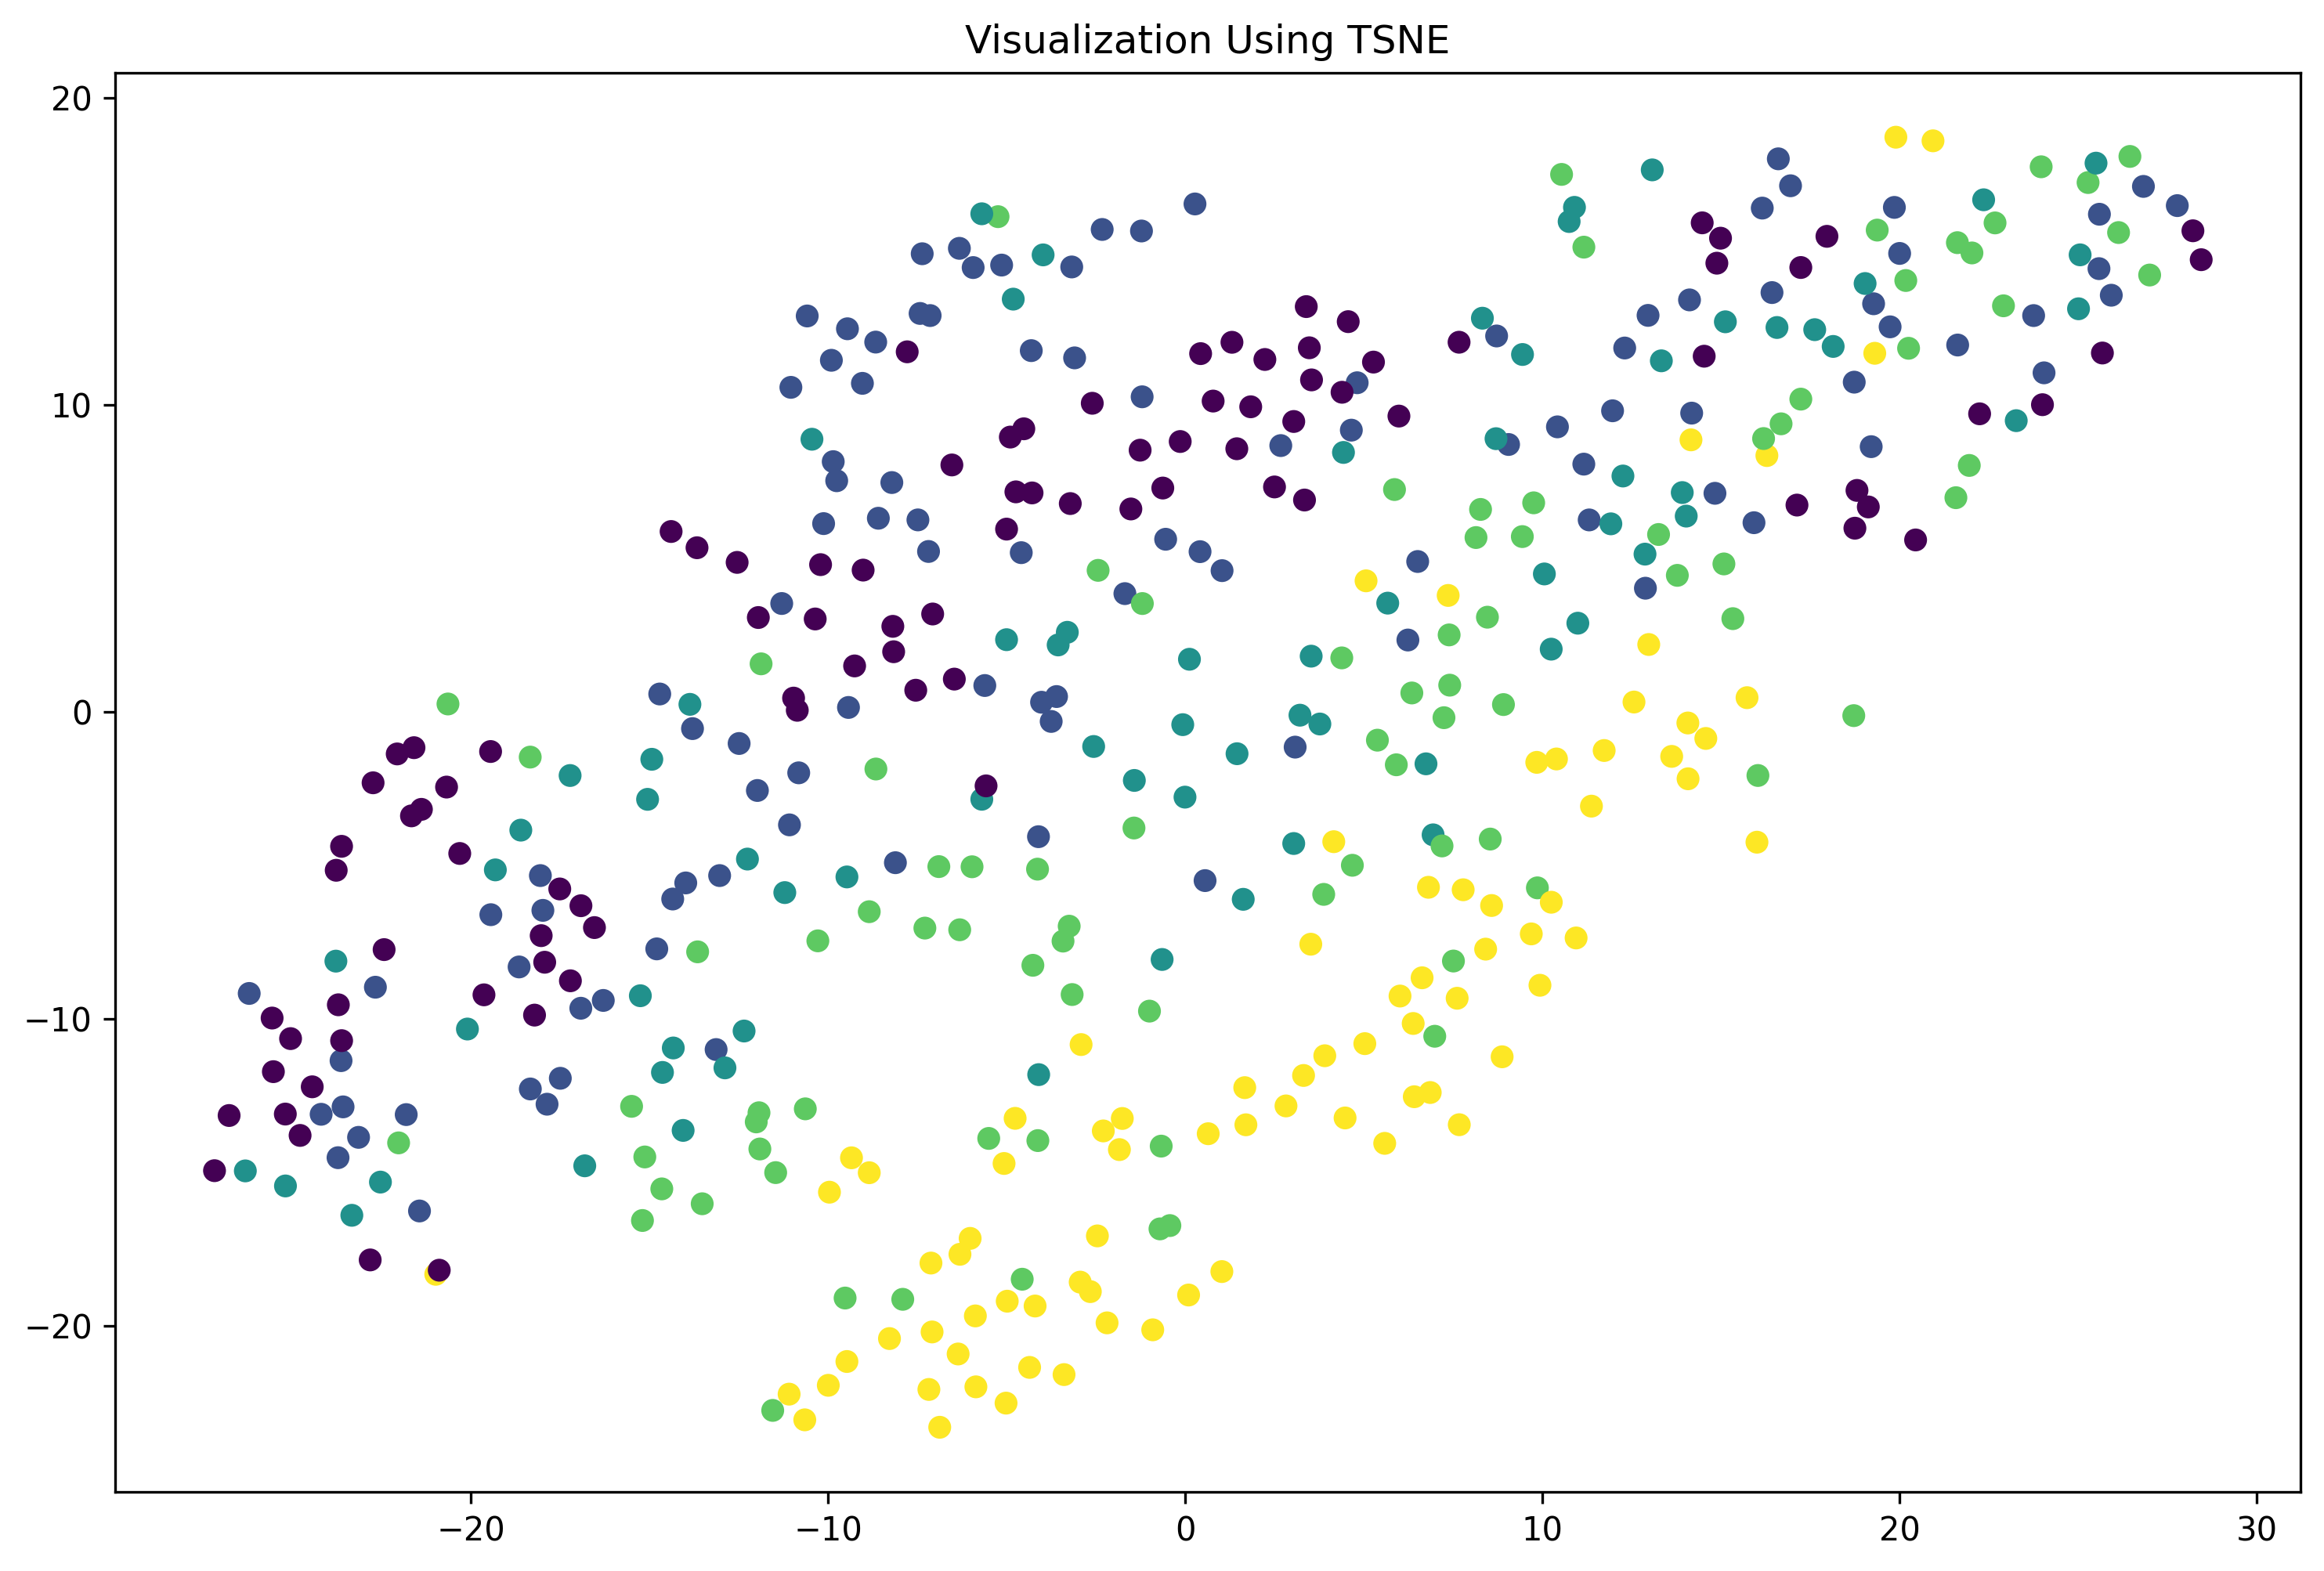

Legend:
	Purple: PG
	Blue: SG
	Blue-Green: SF
	Green: PF
	Yellow: C


In [46]:
# Mapping the positions to numbers:

pos = df['Pos'].apply(pos_to_num)

X_TSNE = TSNE(random_state=720).fit_transform(X_scaled)
plt.figure(dpi=300, figsize=(12, 8))
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=pos)
plt.title('Visualization Using TSNE')
plt.show()
print("Legend:")
print("\tPurple: PG")
print("\tBlue: SG")
print("\tBlue-Green: SF")
print("\tGreen: PF")
print("\tYellow: C")

#### ANALYSIS
Although we will not be clustering based on position, we can see that there is some distinction between positions even when the data is plotted using TSNE. This implies that different positions have different playing styles, although this is an affirmation rather than a discovery.

In [47]:
lin_per_dict = {
    'FG': 85.910,
    'STL': 53.897,
    '3P': 51.757,
    'FT': 46.845,
    'BLK': 39.190,
    'ORB': 39.190,
    'AST': 34.677,
    'DRB': 14.707,
    'PF': -17.174,
    'FTMi': -20.091,
    'FGMi': -39.190,
    'TOV': -53.897
}

### 6.3. Clustering 2018-2019 Season Players with KMeans

We will perform a cluster range, meaning that we will cluster using various values of `k` in order to generate a plot of internal validation criteria, which will allow us to select an optimum `k`. We set a `random_state` in order to provide consistency of results across executions of the notebook, and performed the cluster range from 2 up to 10 clusters only to keep the number of clusters parsimonious.

In [48]:
res_kmeans = cluster_range(X_scaled, KMeans(random_state=720), 2, 10)

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!


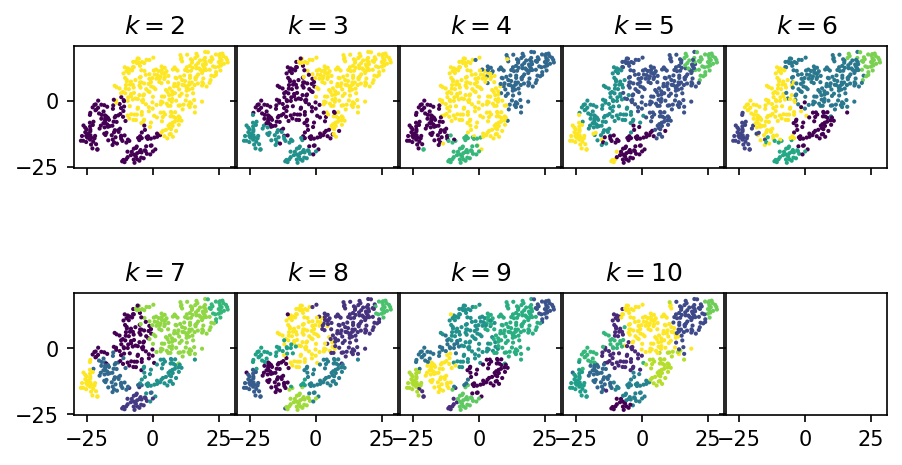

In [49]:
plot_clusters(X_scaled, res_kmeans['ys'], X_TSNE)
plt.show()

#### ANALYSIS
We can see that the clustering algorithm is able to do a good job of clustering the players. Despite the feature array having a dimensionality greater than 2, the separation of clusters is captured well in the TSNE plots.

However, visual inspection is not always a satisfactory method for determining the optimum number of clusters. In order to provide a more objective measure of the optimum number of clusters, we will plot the internal validation criteria.

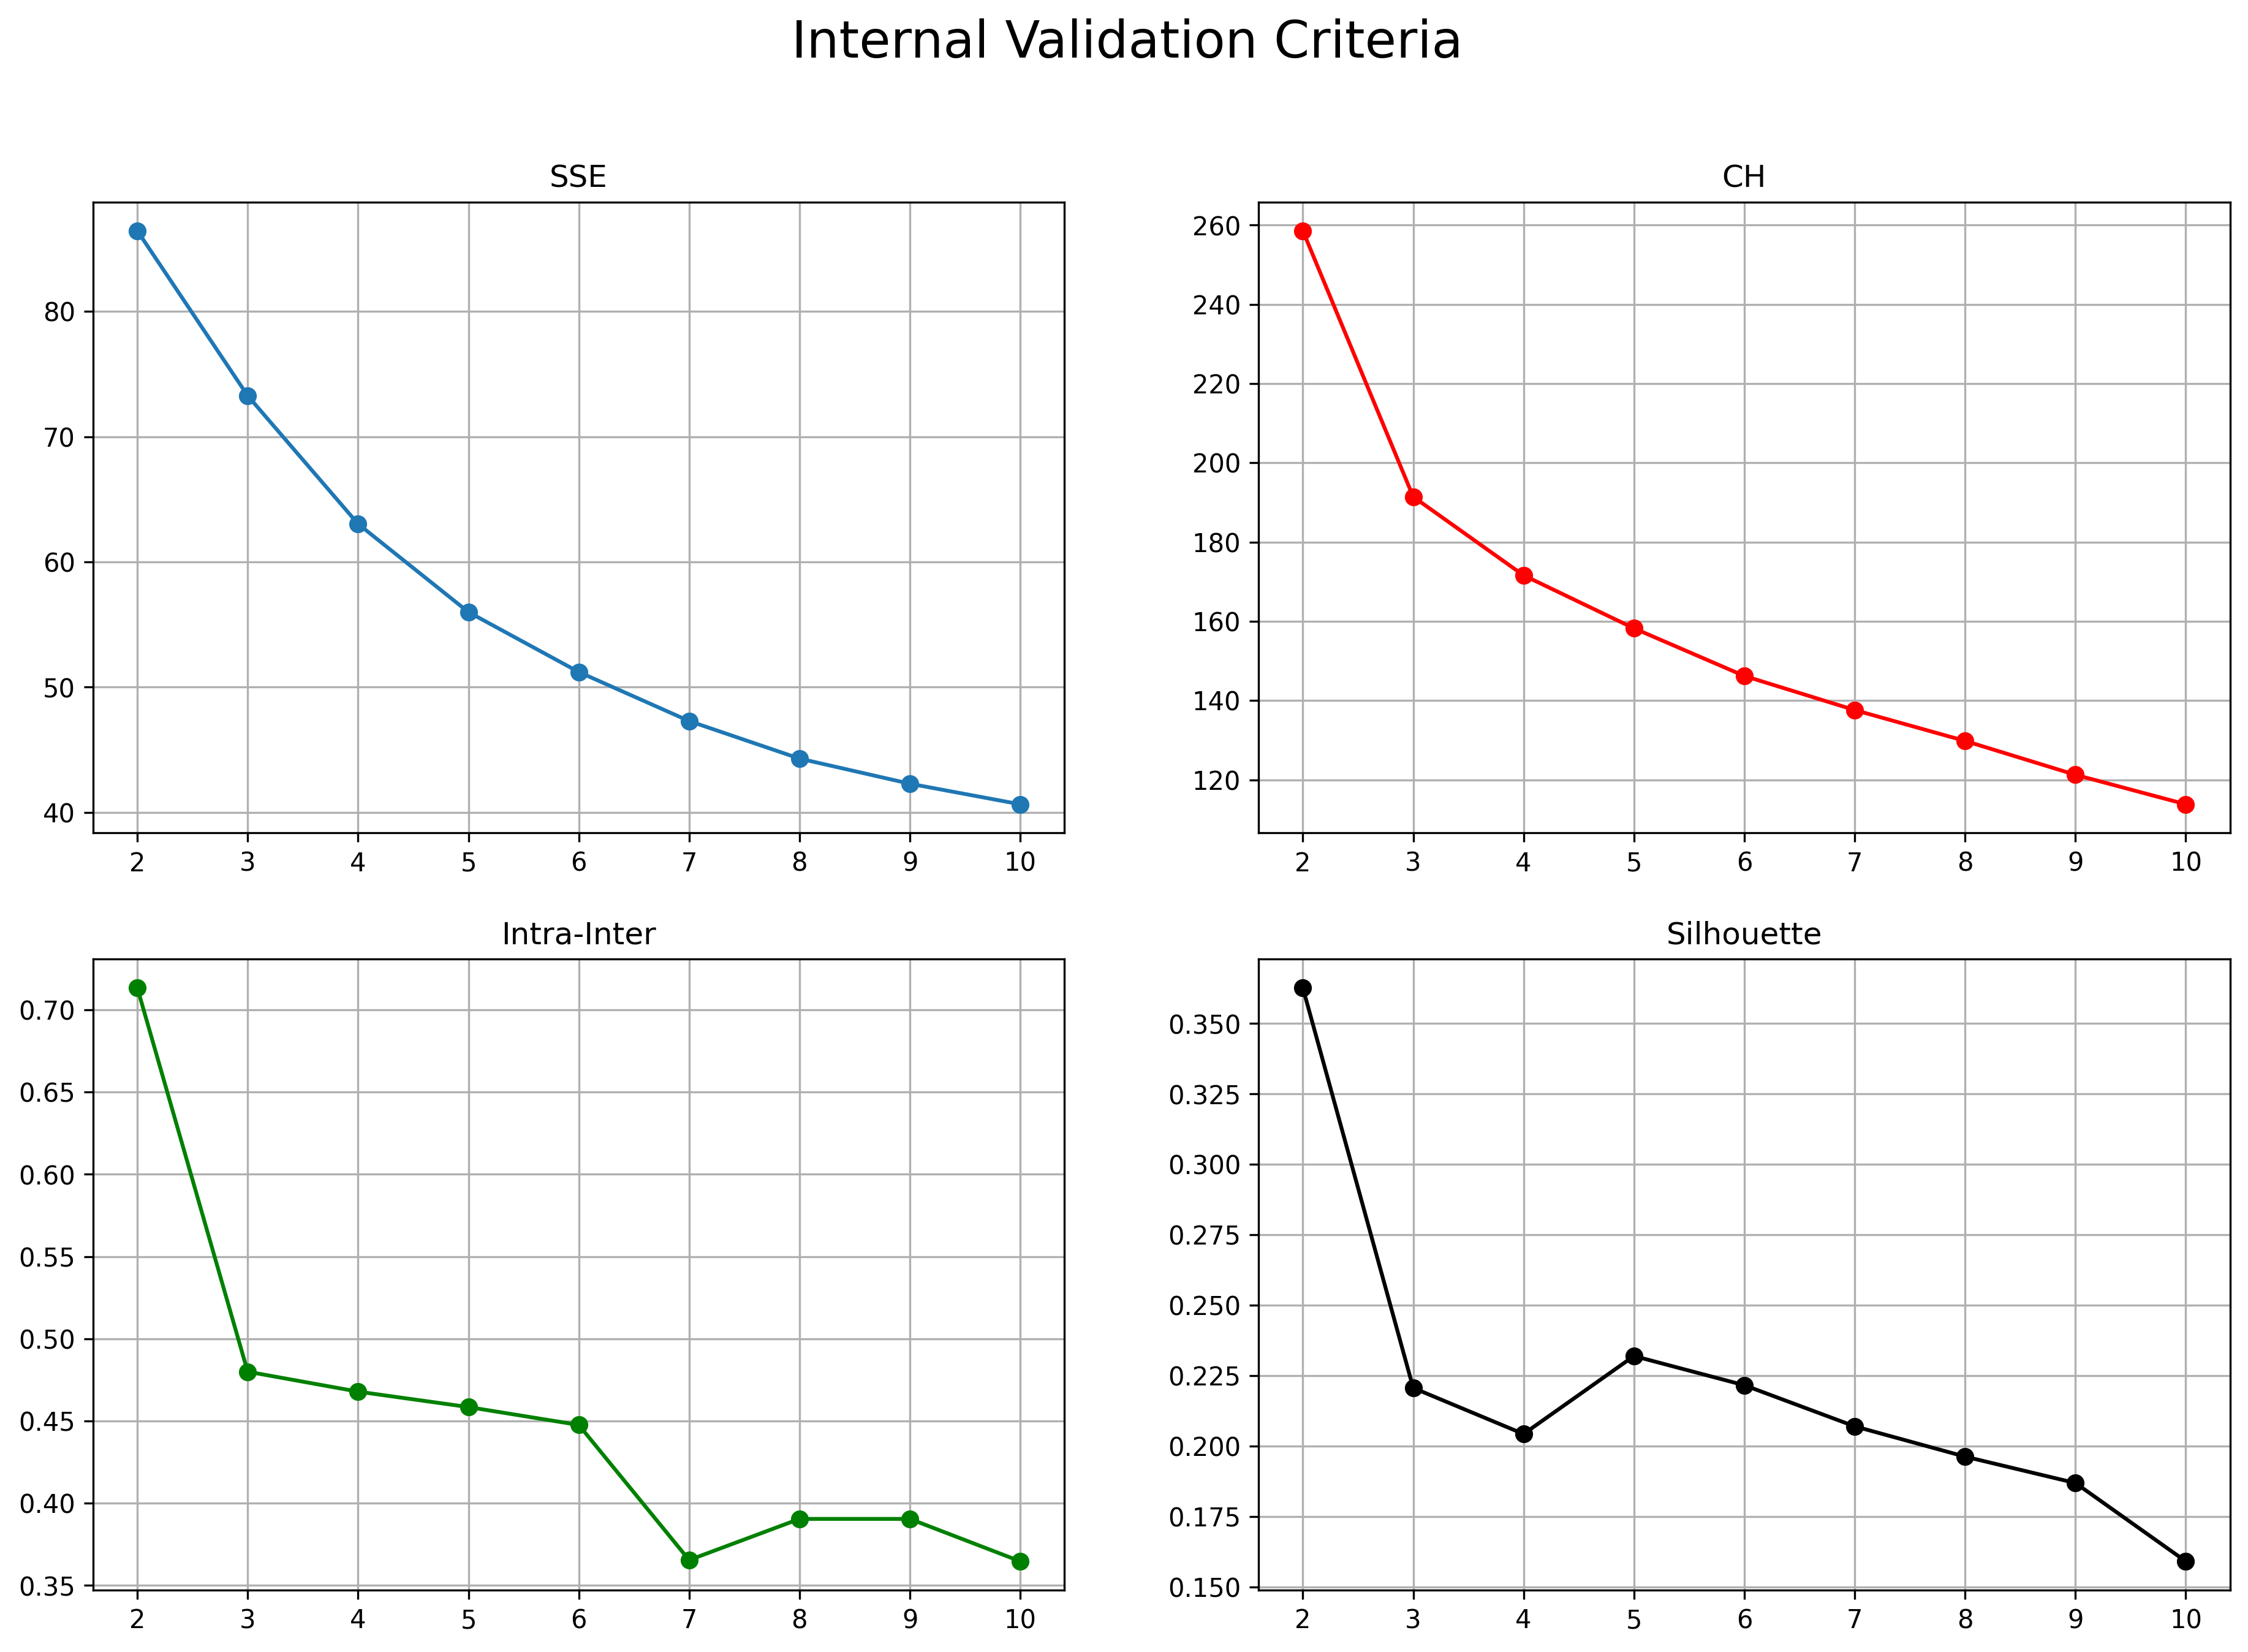

In [50]:
fig, ax = plt.subplots(2, 2, dpi=300, figsize=(15, 10))
fig.suptitle("Internal Validation Criteria", fontsize=20)

ax[0][0].plot(np.arange(2, len(res_kmeans['inertias'])+2), res_kmeans['inertias'], 'o-')
ax[0][0].set_xticks(np.arange(2, len(res_kmeans['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()

ax[0][1].plot(np.arange(2, len(res_kmeans['chs'])+2), res_kmeans['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_kmeans['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()

ax[1][0].plot(np.arange(2, len(res_kmeans['iidrs'])+2), res_kmeans['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_kmeans['iidrs'])+2))
ax[1][0].set_title("Intra-Inter")
ax[1][0].grid()

ax[1][1].plot(np.arange(2, len(res_kmeans['scs'])+2), res_kmeans['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_kmeans['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()

plt.show()

#### ANALYSIS

* **SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. A good range of values is **7+** because it is the 'elbow', or the area at which the absolute value of the slope of the graph suddenly decreased.

* **CH** - for Calinski-Harabasz index (CH), larger values are desirable. Based on the plot above, it is ambiguous what k to select.

* **Intra-Inter** - A lower value of intra-inter is preferable. Thus, **7** clusters are optimal based on this measure.

* **Silhouette** - This coefficient is best if maximized. Although silhouette is maxed at 2 clusters, **5** clusters is the optimal number since it is the number at which silhouette coefficient suddenly increased.

#### VERDICT

Try picking **7** clusters as suggested by Intra-Inter.

Unique clusters:

In [51]:
y_predict_kmeans_7 = res_kmeans['ys'][5]
np.unique(y_predict_kmeans_7)

array([0, 1, 2, 3, 4, 5, 6])

In [52]:
df['kmeans_7'] = y_predict_kmeans_7

Number of players in each cluster:

In [53]:
df['kmeans_7'].value_counts()

5    152
0     98
2     54
3     52
6     30
1     29
4     25
Name: kmeans_7, dtype: int64

It was stated in our objectives for this work that we aim to identify the clusters containing the best players. However, how do we know which cluster (or clusters) that is? For that, we will use the Player Efficiency Rating (PER).

### 6.3.1. Player Efficiency Rating (PER)

The PER is an all-in-one basketball rating, developed by John Hollinger, which attempts to summarize a player's overall contribution or efficiency in a single number. The formula is as follows:

<img src="figures/PER.svg">

Yes, it is quite long, and inasmuch as this statistic is very tedious to encode and calculate, we will use a linear approximation to the PER, formulated by Bleacher Report's Zach Fein, which uses the following coefficients:

In [54]:
lin_per_dict

{'FG': 85.91,
 'STL': 53.897,
 '3P': 51.757,
 'FT': 46.845,
 'BLK': 39.19,
 'ORB': 39.19,
 'AST': 34.677,
 'DRB': 14.707,
 'PF': -17.174,
 'FTMi': -20.091,
 'FGMi': -39.19,
 'TOV': -53.897}

In [56]:
def get_lin_per(row):
    per = 0
    for col in lin_per_dict:
        per += row[col]*lin_per_dict[col]
    per /= row['MP']
    return per

In [57]:
try:
    df_complete['FTMi'] = df_complete.apply(lambda row: row['FTA']-row['FT'], axis=1)
    df_complete['FGMi'] = df_complete.apply(lambda row: row['FGA']-row['FG'], axis=1)
except:
    pass



df_complete['PER'] = df_complete.apply(get_lin_per, axis=1)
df['PER'] = df_complete['PER'].copy()

Now, we will obtain the distributions of the players' PER per cluster and identify the cluster/s that are better than the rest:

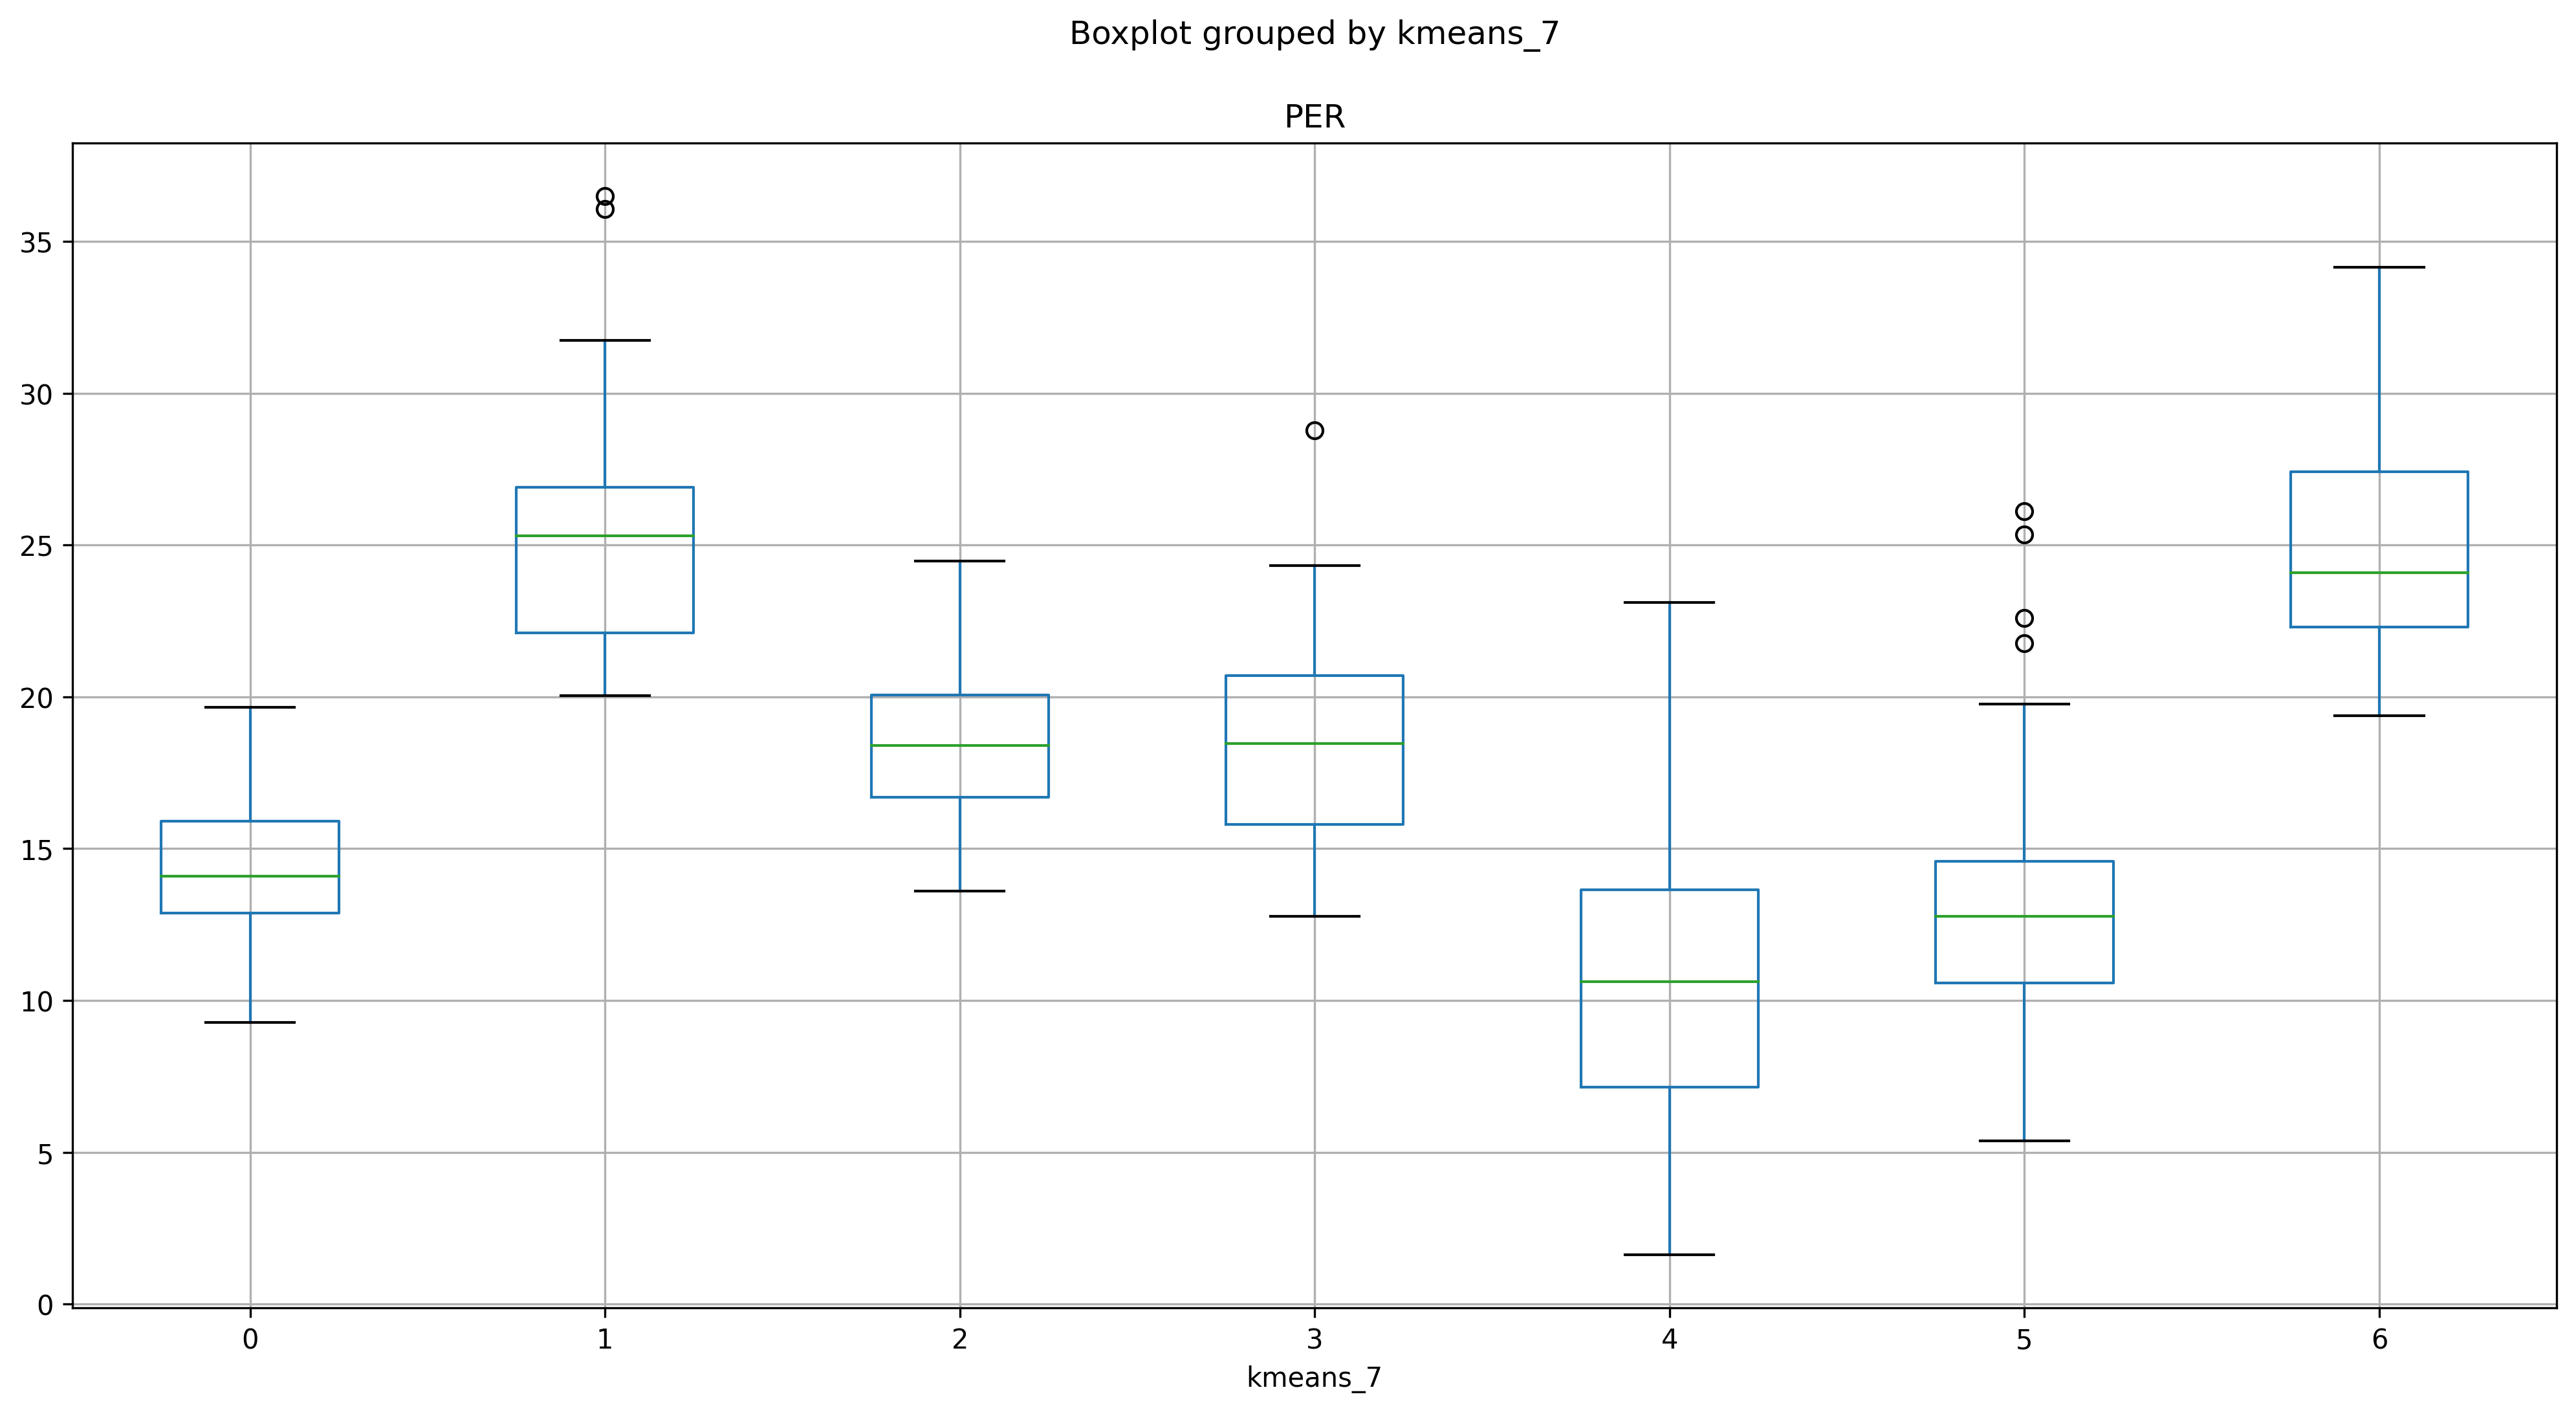

In [58]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(16, 8))
df.boxplot(column='PER', by='kmeans_7', ax=ax)
plt.show()

#### ANALYSIS
If Player Efficiency Rating is used as the basis, we can see some differentiation between clusters. It can be seen that clusters 1 and 6 have higher PER than the other clusters, notably cluster 4 which has a dismal mean PER of about 11. 

Of course, we could have simply clustered by PER. Although one may argue that this statistic already provides a weighted aggregation of most of the other statistics, doing so is somewhat one-dimensional, as players who are in close proximity by virtue of the PER are not necessarily as similar in terms of all statistics.

Now that we have identified that our best clusters are clusters 1 and 6, we will see what positions comprise each of the clusters, then construct a word cloud of the player names in each cluster to get a brief glimpse of who is in which cluster. A write-up will be provided after the two visualizations.

Cluster 0


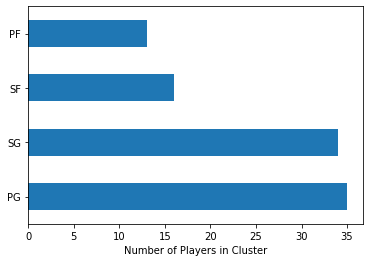

Cluster 1


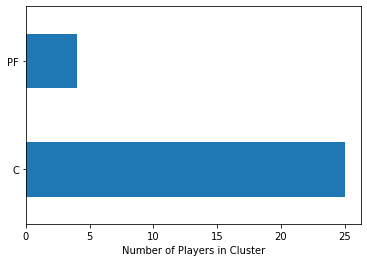

Cluster 2


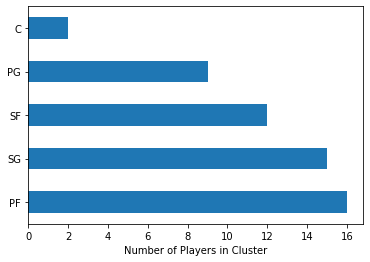

Cluster 3


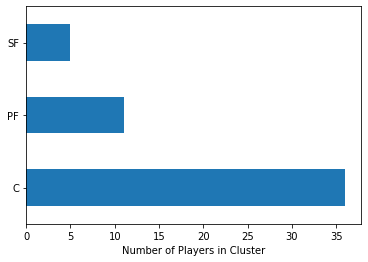

Cluster 4


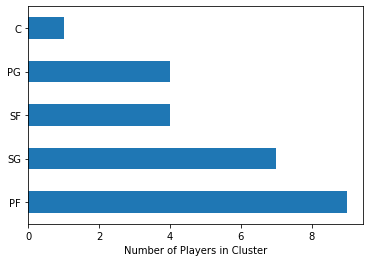

Cluster 5


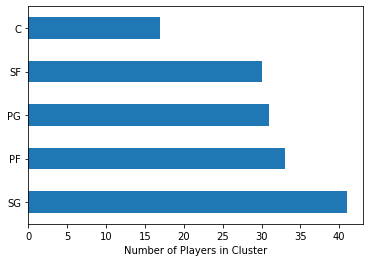

Cluster 6


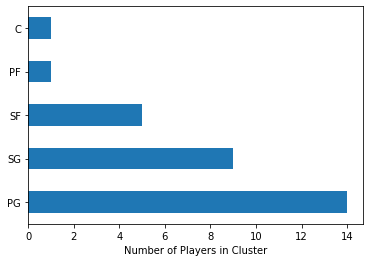

In [59]:
plot_cluster_positions(df, 'kmeans_7')

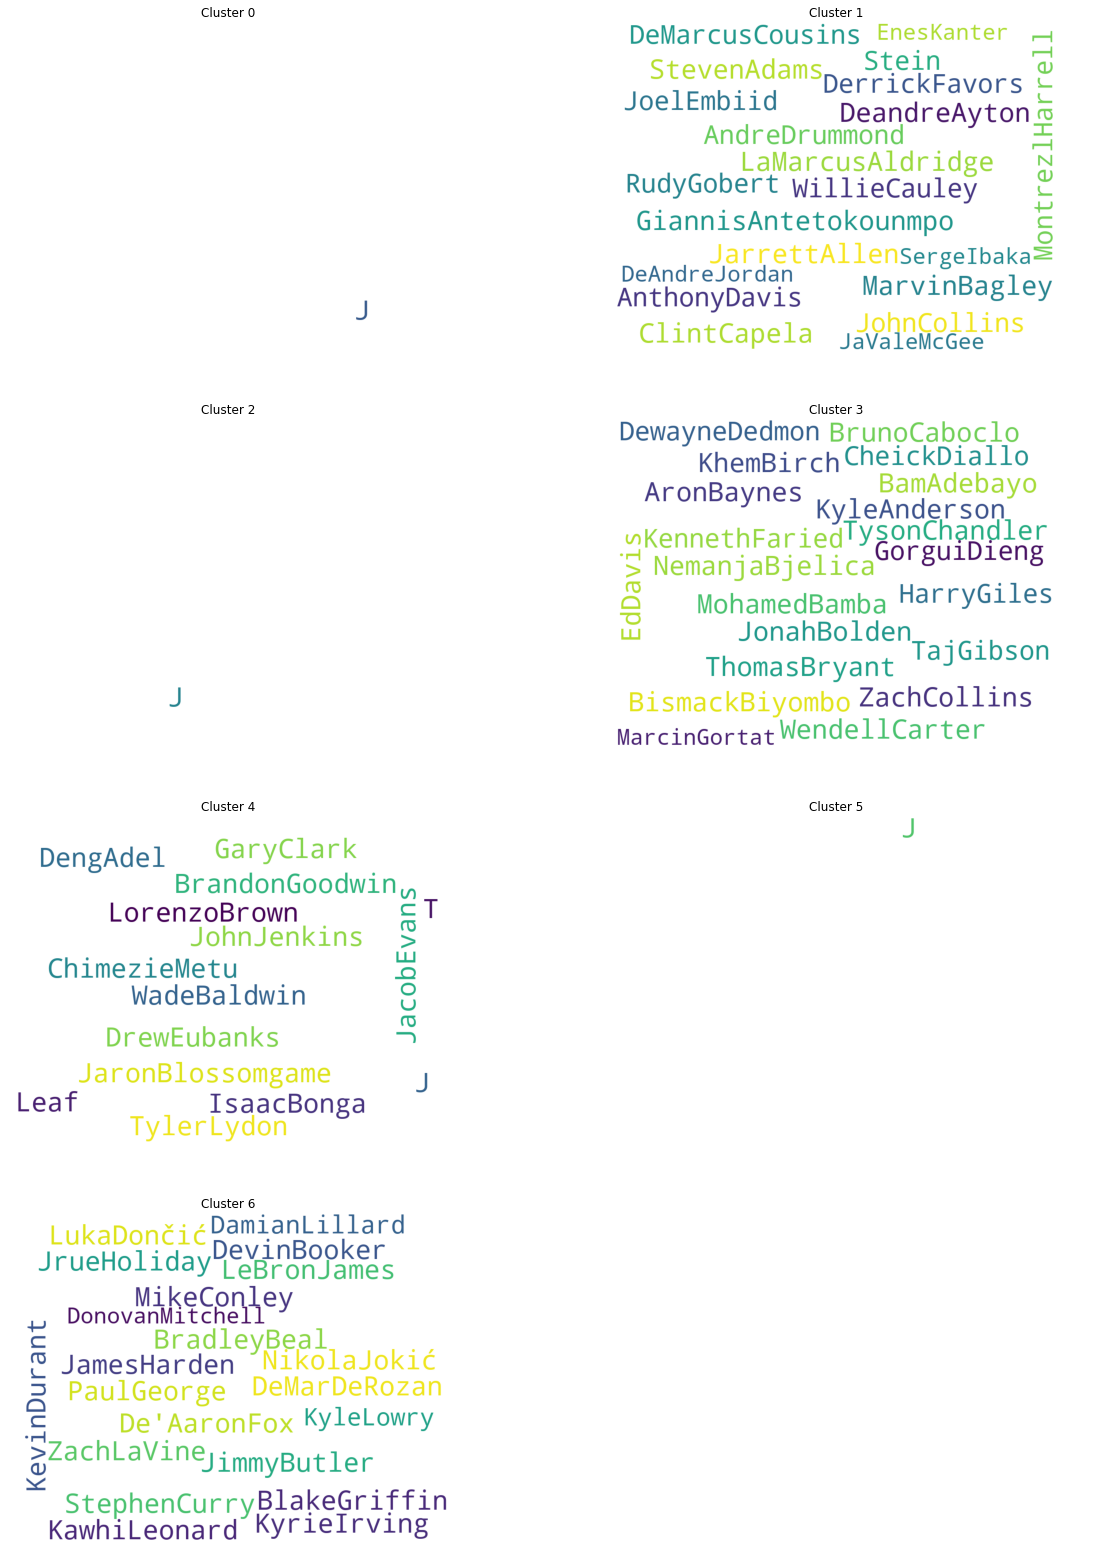

In [60]:
illustrate_clusters_subplots(df, 7)

#### ANALYSIS
Based on our findings that Clusters 1 and 6 have the best overall statistics, and each of the two clusters is mostly dominated by a single position (Point Guard for Cluster 6 and Center for Cluster 1), we might conclude that the 2018-2019 season is the season of the Point Guards and Centers. This is evidenced by the popularity of centers such as Anthony Davis (Cluster 1), and Point Guards such as Stephen Curry (Cluster 6). Contradicting this claim though, is the awarding of league MVP Giannis Antetokounmpo (Cluster 1), who plays at the Power Forward position.

### 6.4. Clustering 2017-2018 Season Players with KMeans

In the succeeding subsections under Section 6, we will perform clustering on the players for the previous four seasons (2018, 2017, 2016, and 2015) in reverse chronological order. However, the write-ups for the previous seasons will not be as comprehensive as those for the 2019 season.

In the following cell, we perform all operations done to the 2019 player data in Section 6, to the 2018 player data, then perform clustering to see if the trends remain the same.

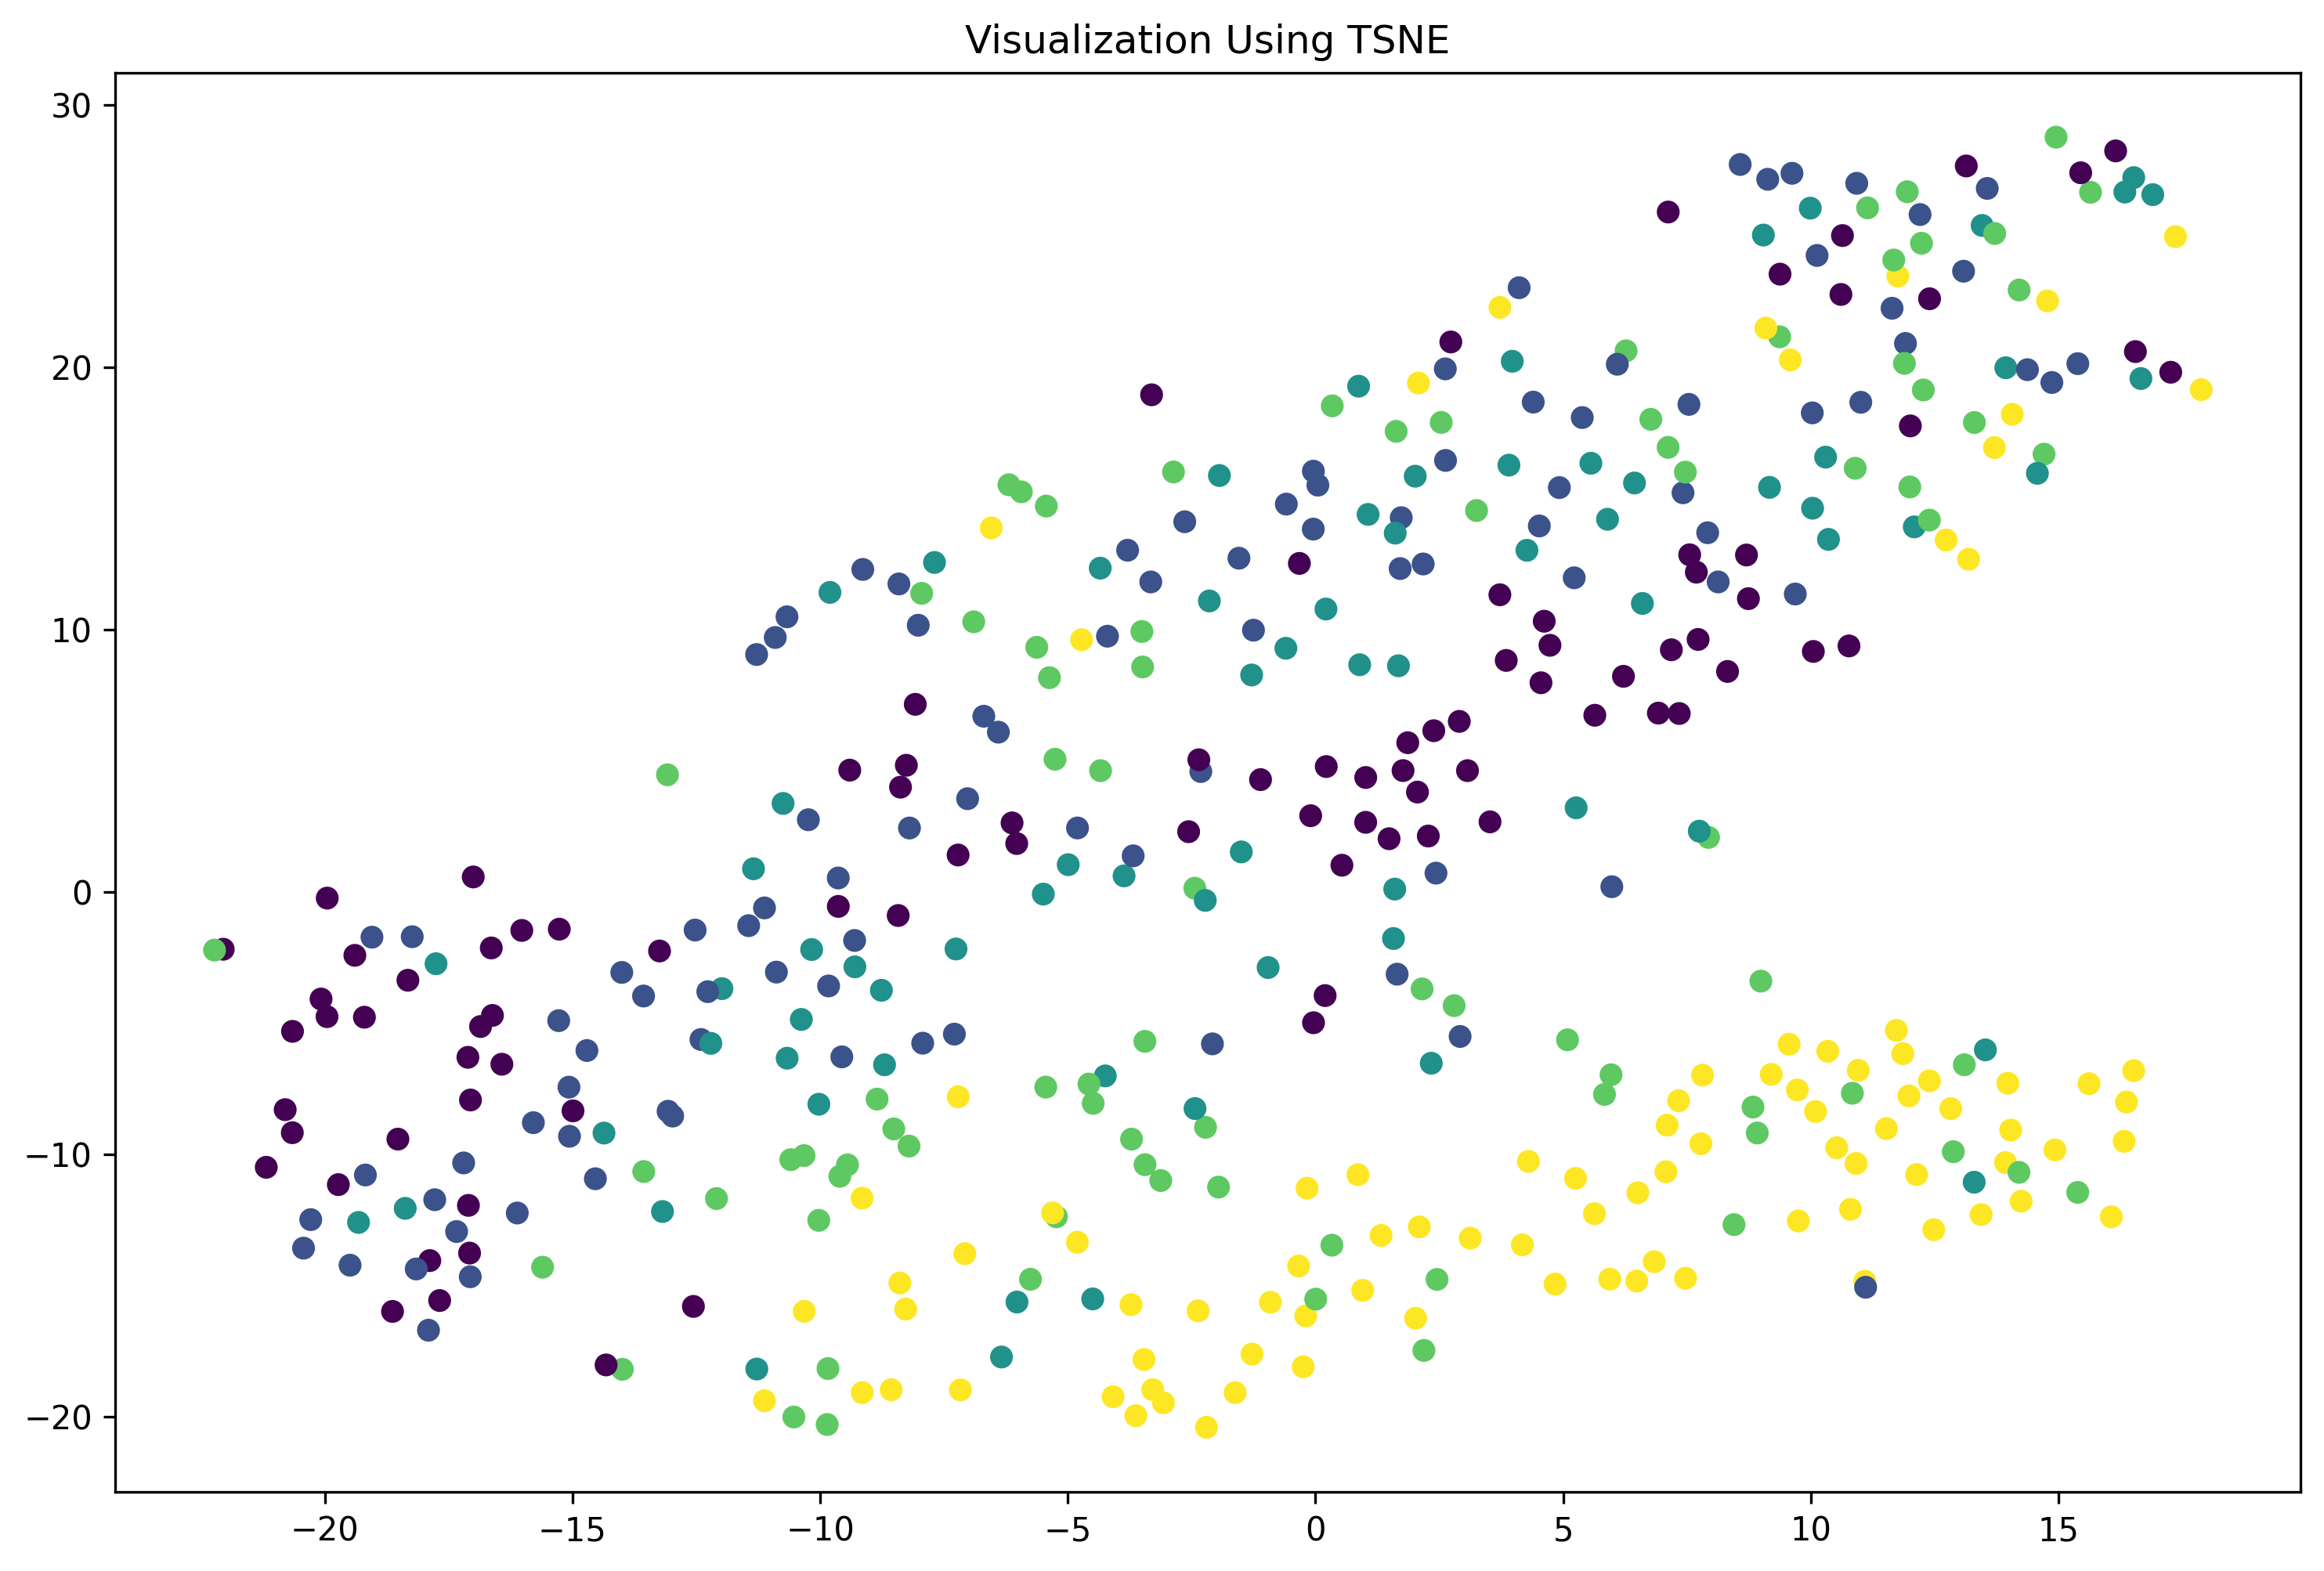

Legend:
	Purple: PG
	Blue: SG
	Blue-Green: SF
	Green: PF
	Yellow: C


In [62]:
df_2018 = read_year(2018, player_db)
df_2018 = df_2018[df_2018['G'] > 15]
df_2018['Pos'] = df_2018['Pos'].apply(replace_pos)
df_2018.loc[:, 'ITO'] = df_2018.loc[:, 'TOV'].apply(lambda x: 1/(x+0.00001))
df_2018.loc[:, 'IPF'] = df_2018.loc[:, 'PF'].apply(lambda x: 1/(x+0.00001))
df_2018_features = df_2018.drop(columns=to_drop+labels+maybe_drop).fillna(0.)
X = df_2018_features.to_numpy()
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
X_scaled = mm_scaler.transform(X)
if np.max(X_scaled[:, -3]) == 1.:
    X_scaled[:, -3] = X_scaled[:, -3] / 2
    
pos_2018 = df_2018['Pos'].apply(pos_to_num)
X_TSNE = TSNE(random_state=720).fit_transform(X_scaled)
plt.figure(dpi=300, figsize=(12, 8))
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=pos_2018)
plt.title('Visualization Using TSNE')
plt.show()
print("Legend:")
print("\tPurple: PG")
print("\tBlue: SG")
print("\tBlue-Green: SF")
print("\tGreen: PF")
print("\tYellow: C")

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!


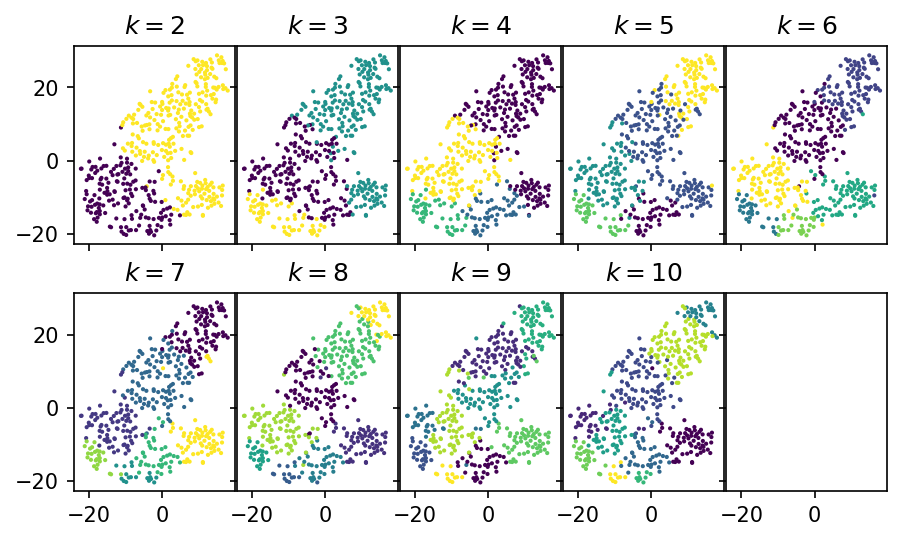

In [63]:
res_kmeans = cluster_range(X_scaled, KMeans(random_state=720), 2, 10)
plot_clusters(X_scaled, res_kmeans['ys'], X_TSNE)
plt.show()

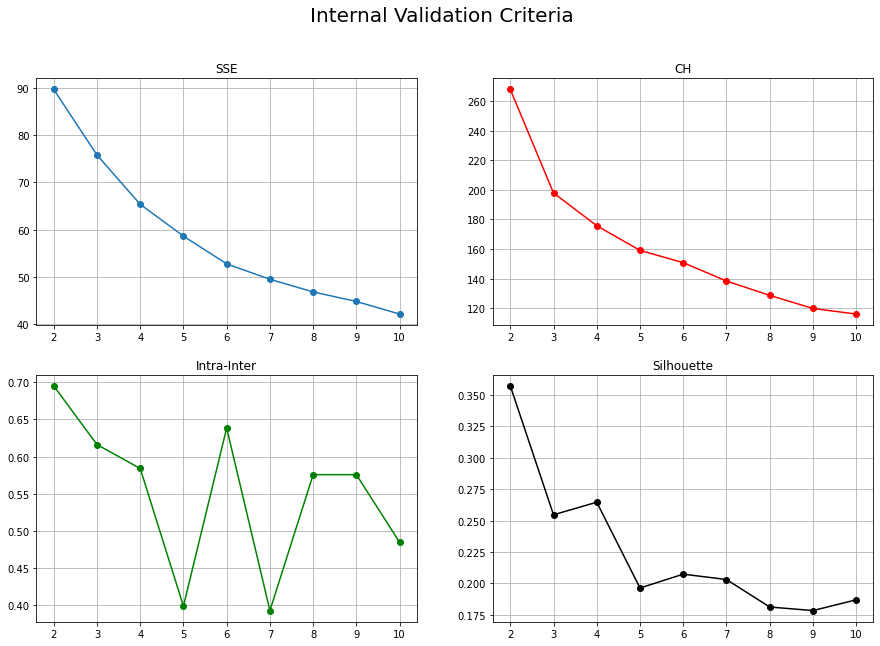

In [64]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Internal Validation Criteria", fontsize=20)
ax[0][0].plot(np.arange(2, len(res_kmeans['inertias'])+2), res_kmeans['inertias'], 'o-')
ax[0][0].set_xticks(np.arange(2, len(res_kmeans['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()
ax[0][1].plot(np.arange(2, len(res_kmeans['chs'])+2), res_kmeans['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_kmeans['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()
ax[1][0].plot(np.arange(2, len(res_kmeans['iidrs'])+2), res_kmeans['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_kmeans['iidrs'])+2))
ax[1][0].set_title("Intra-Inter")
ax[1][0].grid()
ax[1][1].plot(np.arange(2, len(res_kmeans['scs'])+2), res_kmeans['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_kmeans['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()
plt.show()

#### ANALYSIS

* **SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. A good range of values is **7+** because it is the 'elbow', or the area at which the absolute value of the slope of the graph suddenly decreased.

* **CH** - for Calinski-Harabasz index (CH), larger values are desirable. Based on the plot above, it is ambiguous what k to select.

* **Intra-Inter** - A lower value of intra-inter is preferable. Thus, **5**, or <b>7</b> clusters are optimal based on this measure.

* **Silhouette** - This coefficient is best if maximized. Although silhouette is maxed at 2 clusters, **4** clusters is the optimal number since it is the number at which silhouette coefficient suddenly increased.

#### VERDICT

Try picking **5** clusters as suggested by Intra-Inter, and in the interest of parsimony.

Unique clusters:

In [65]:
y_predict_kmeans_5 = res_kmeans['ys'][3]
df_2018['kmeans_5'] = y_predict_kmeans_5
np.unique(y_predict_kmeans_5)

array([0, 1, 2, 3, 4])

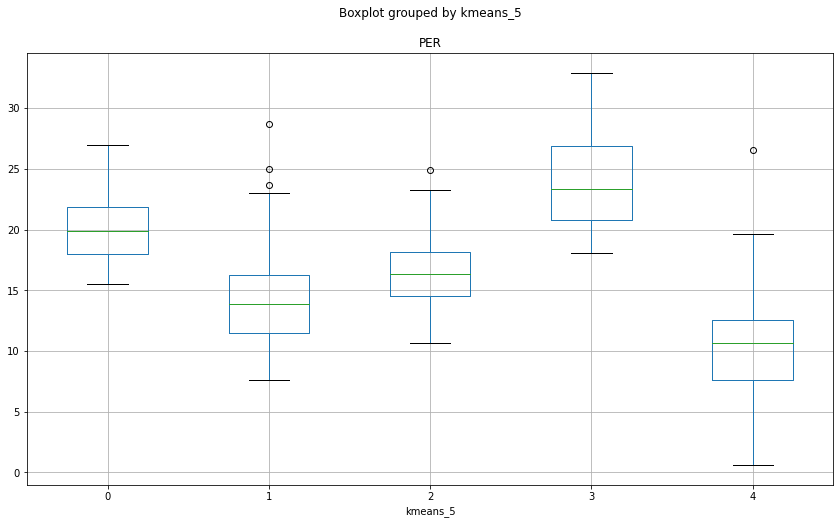

In [66]:
df_2018_complete = df_2018.copy()
try:
    df_2018_complete['FTMi'] = df_2018_complete.apply(lambda row: row['FTA']-row['FT'], axis=1)
    df_2018_complete['FGMi'] = df_2018_complete.apply(lambda row: row['FGA']-row['FG'], axis=1)
except:
    pass
df_2018_complete['PER'] = df_2018_complete.apply(get_lin_per, axis=1)
df_2018['PER'] = df_2018_complete['PER'].copy()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
df_2018.boxplot(column='PER', by='kmeans_5', ax=ax)
plt.show()

Cluster 0


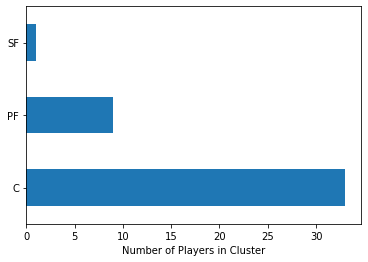

Cluster 1


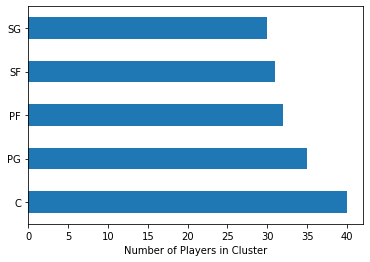

Cluster 2


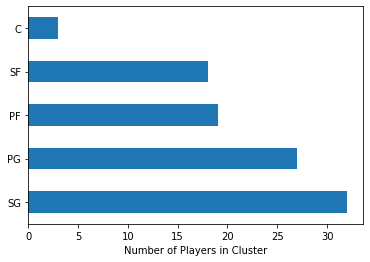

Cluster 3


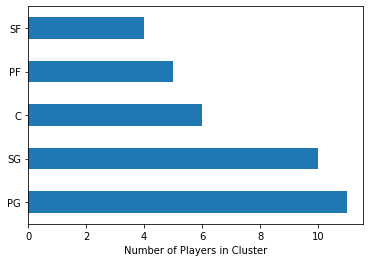

Cluster 4


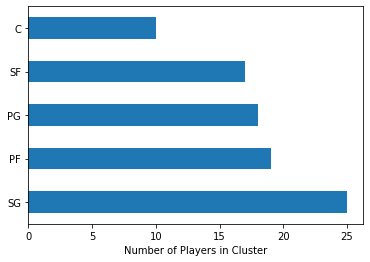

In [67]:
plot_cluster_positions(df_2018, 'kmeans_5')

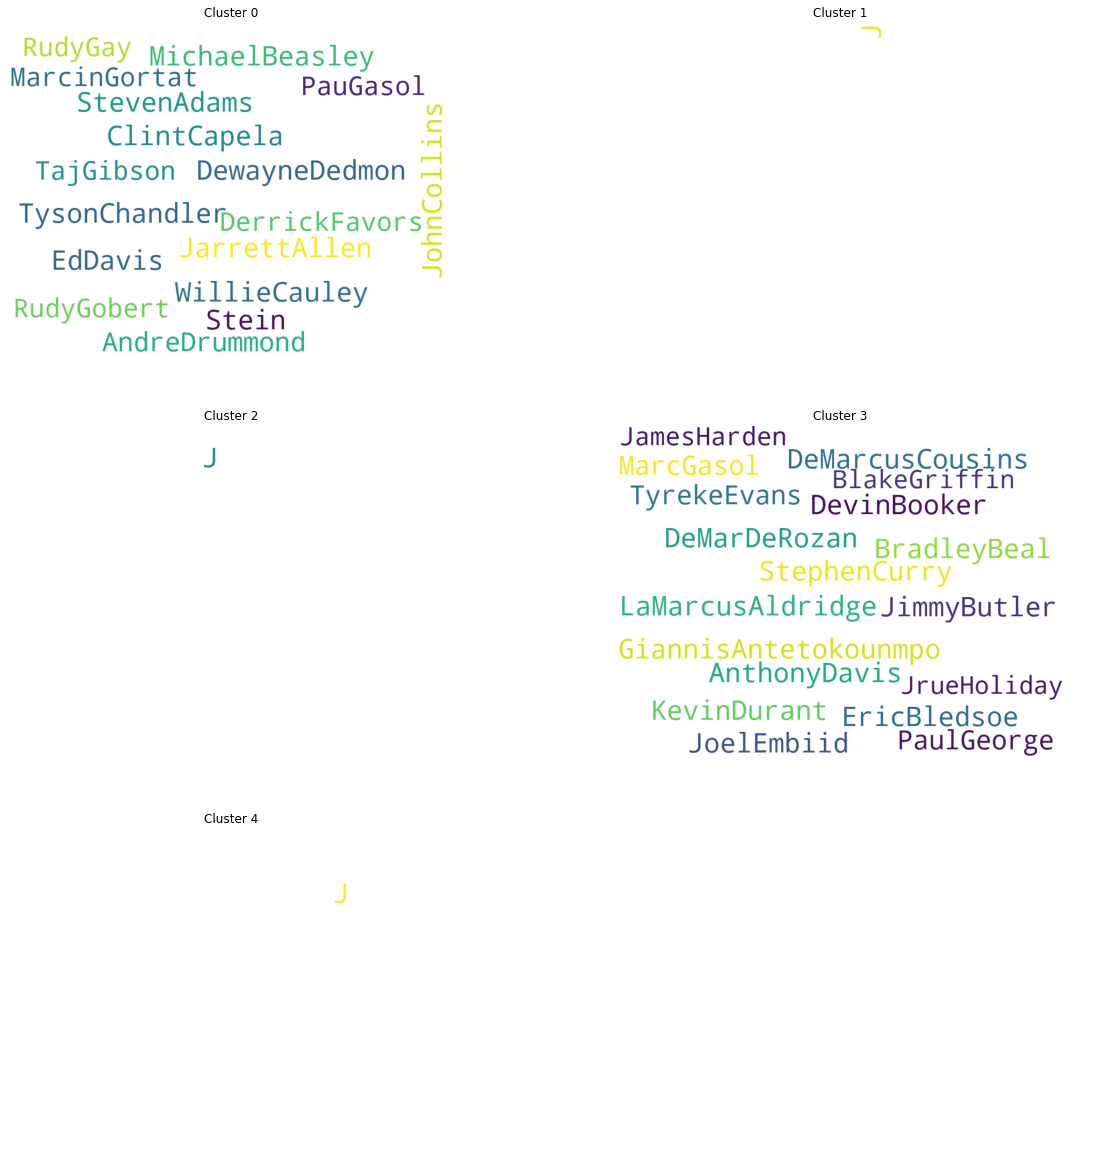

In [68]:
illustrate_clusters_subplots(df_2018, 5)

#### ANALYSIS
Clusters 0 and 3 are the 'star' clusters of this season. From the position bar plots we see that cluster 0 is still the cluster of the Center players, but we see that for cluster 3, although Point Guards are still the most numerous in the best cluster, Shooting Guards come close behind. So we might say that 2017-2018 is the season of the Point Guards, Shooting Guards, and Centers.

### 6.5. Clustering 2016-2017 Season Players with KMeans

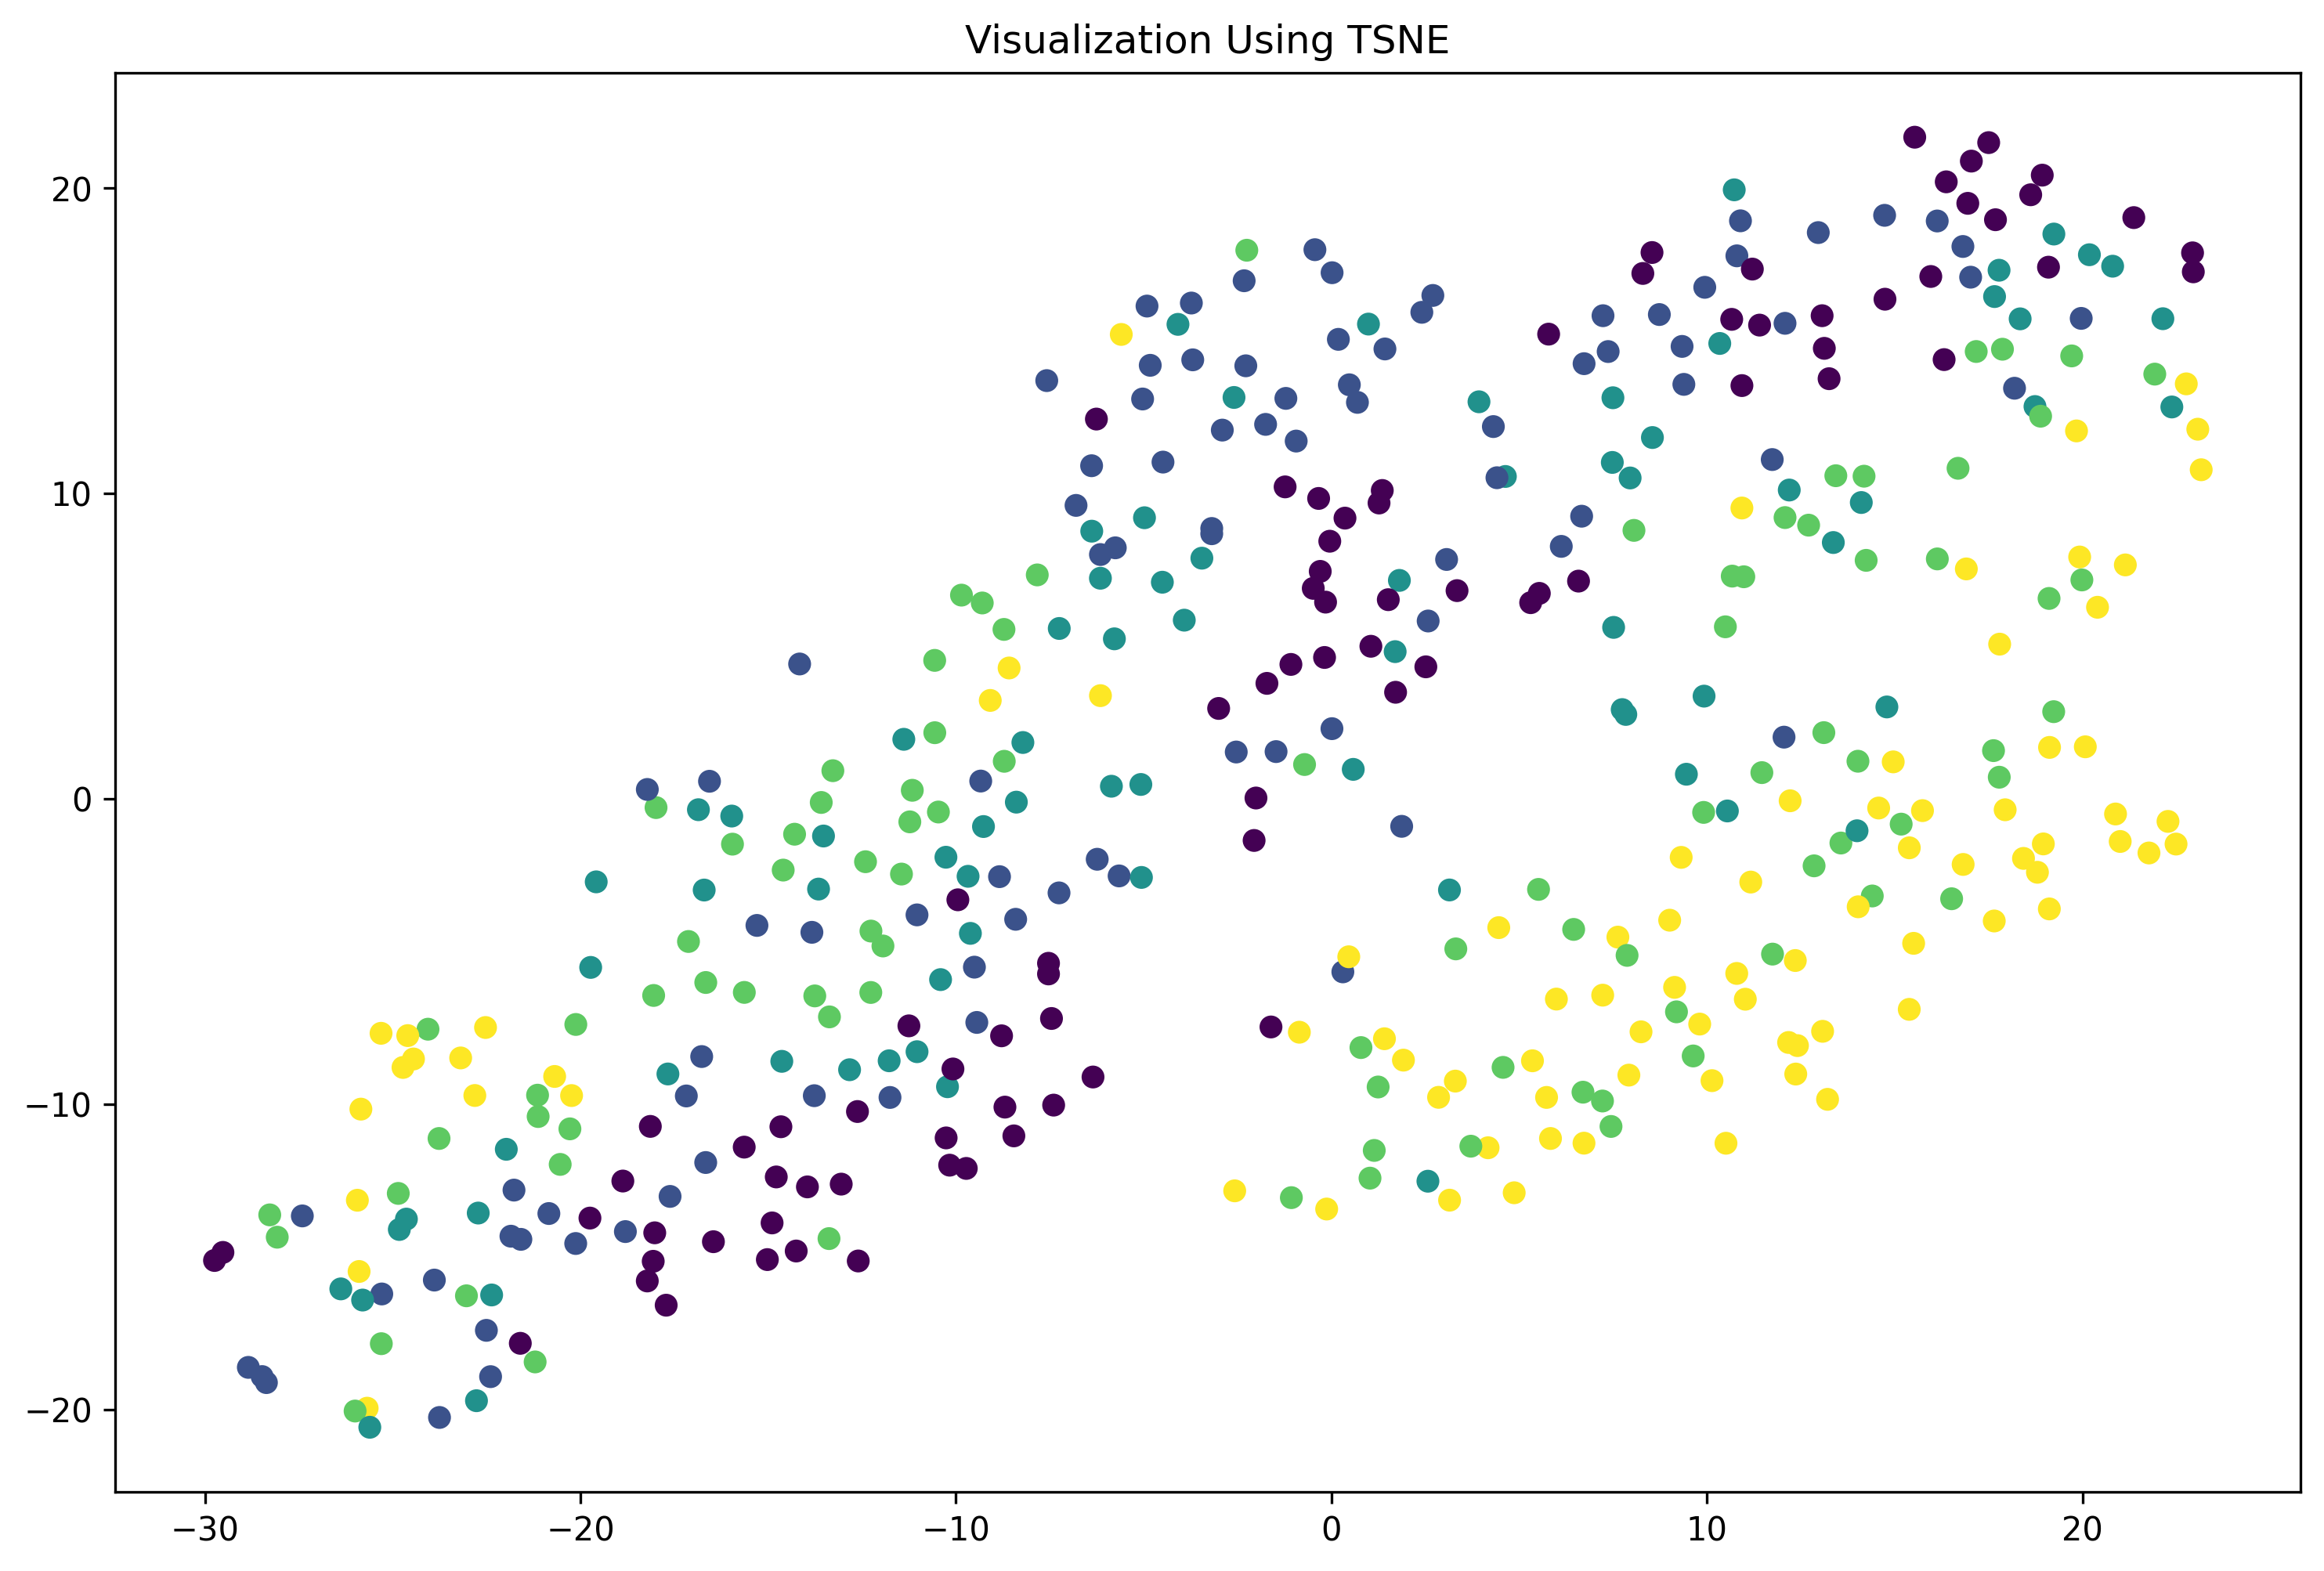

Legend:
	Purple: PG
	Blue: SG
	Blue-Green: SF
	Green: PF
	Yellow: C


In [69]:
df_2017 = read_year(2017, player_db)
df_2017 = df_2017[df_2017['G'] > 15]
df_2017['Pos'] = df_2017['Pos'].apply(replace_pos)
df_2017.loc[:, 'ITO'] = df_2017.loc[:, 'TOV'].apply(lambda x: 1/(x+0.00001))
df_2017.loc[:, 'IPF'] = df_2017.loc[:, 'PF'].apply(lambda x: 1/(x+0.00001))
df_2017_features = df_2017.drop(columns=to_drop+labels+maybe_drop).fillna(0.)
X = df_2017_features.to_numpy()
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
X_scaled = mm_scaler.transform(X)
if np.max(X_scaled[:, -3]) == 1.:
    X_scaled[:, -3] = X_scaled[:, -3] / 2
pos_2017 = df_2017['Pos'].apply(pos_to_num)
X_TSNE = TSNE(random_state=720).fit_transform(X_scaled)
plt.figure(dpi=300, figsize=(12, 8))
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=pos_2017)
plt.title('Visualization Using TSNE')
plt.show()
print("Legend:")
print("\tPurple: PG")
print("\tBlue: SG")
print("\tBlue-Green: SF")
print("\tGreen: PF")
print("\tYellow: C")

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!


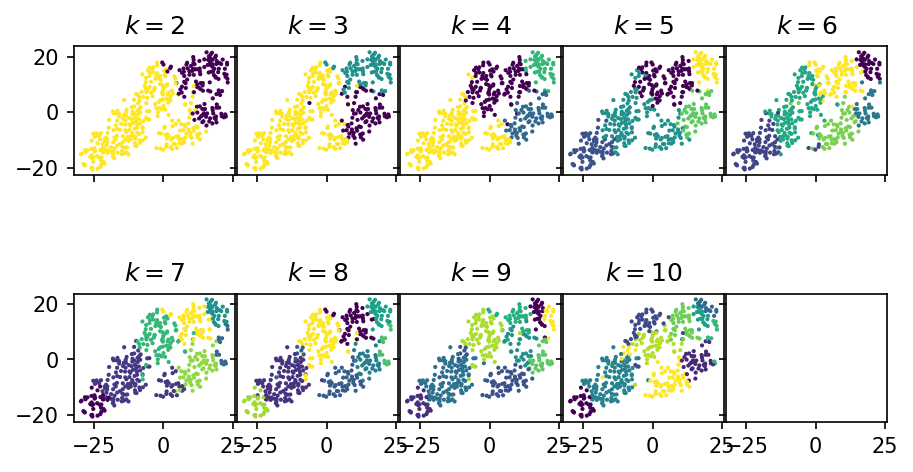

In [70]:
res_kmeans = cluster_range(X_scaled, KMeans(random_state=720), 2, 10)
plot_clusters(X_scaled, res_kmeans['ys'], X_TSNE)
plt.show()

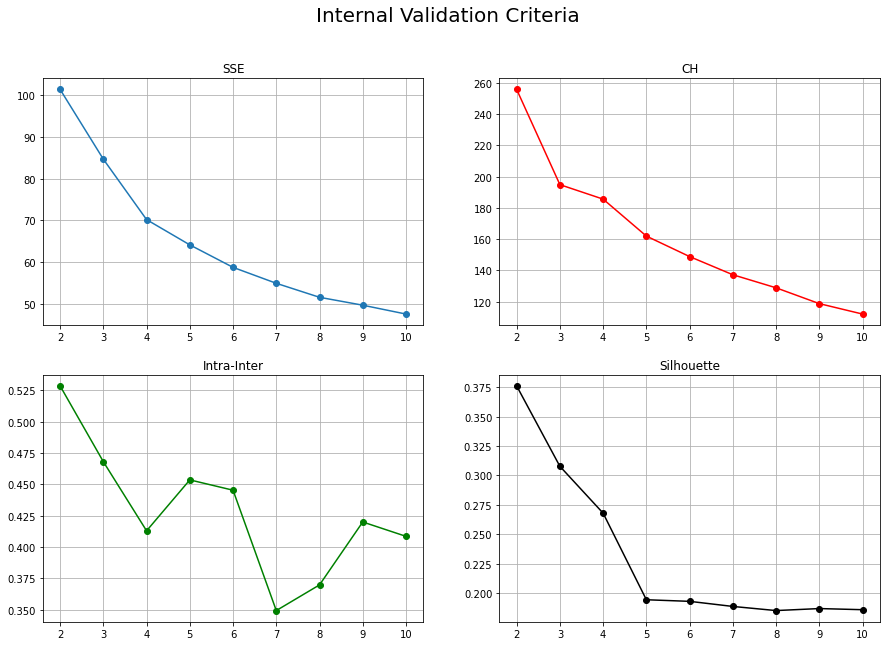

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Internal Validation Criteria", fontsize=20)
ax[0][0].plot(np.arange(2, len(res_kmeans['inertias'])+2), res_kmeans['inertias'], 'o-')
ax[0][0].set_xticks(np.arange(2, len(res_kmeans['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()
ax[0][1].plot(np.arange(2, len(res_kmeans['chs'])+2), res_kmeans['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_kmeans['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()
ax[1][0].plot(np.arange(2, len(res_kmeans['iidrs'])+2), res_kmeans['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_kmeans['iidrs'])+2))
ax[1][0].set_title("Intra-Inter")
ax[1][0].grid()
ax[1][1].plot(np.arange(2, len(res_kmeans['scs'])+2), res_kmeans['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_kmeans['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()
plt.show()

#### ANALYSIS

* **SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. A good range of values is **7+** because it is the 'elbow', or the area at which the absolute value of the slope of the graph suddenly decreased.

* **CH** - for Calinski-Harabasz index (CH), larger values are desirable. Based on the plot above, we might want to select **4** clusters.

* **Intra-Inter** - A lower value of intra-inter is preferable. Thus, **4**, or **7** clusters are optimal based on this measure.

* **Silhouette** - This coefficient is best if maximized. Although silhouette is maxed at 2 clusters, **4** clusters is the optimal number since it is the number before which silhouette coefficient suddenly decreased.

#### VERDICT

Try picking **7** clusters as suggested by Intra-Inter.

In [72]:
y_predict_kmeans_7 = res_kmeans['ys'][5]
df_2017['kmeans_7'] = y_predict_kmeans_7

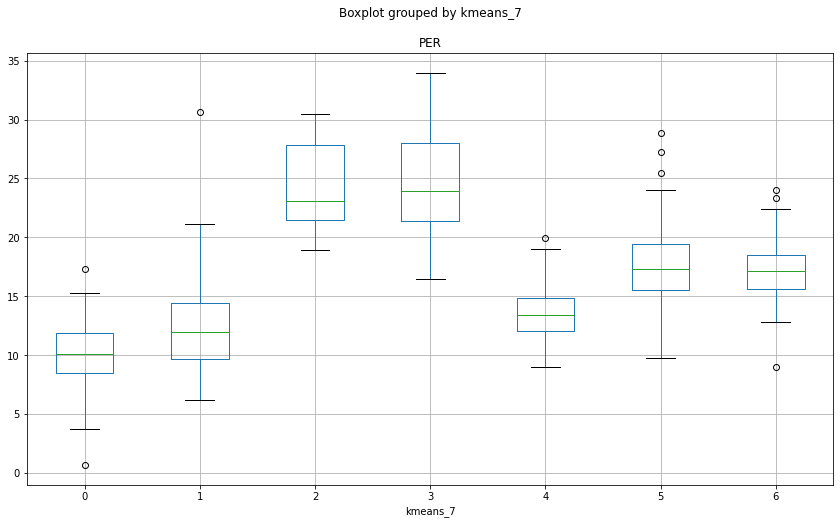

In [73]:
df_2017_complete = df_2017.copy()
try:
    df_2017_complete['FTMi'] = df_2017_complete.apply(lambda row: row['FTA']-row['FT'], axis=1)
    df_2017_complete['FGMi'] = df_2017_complete.apply(lambda row: row['FGA']-row['FG'], axis=1)
except:
    pass
df_2017_complete['PER'] = df_2017_complete.apply(get_lin_per, axis=1)
df_2017['PER'] = df_2017_complete['PER'].copy()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
df_2017.boxplot(column='PER', by='kmeans_7', ax=ax)
plt.show()

Cluster 0


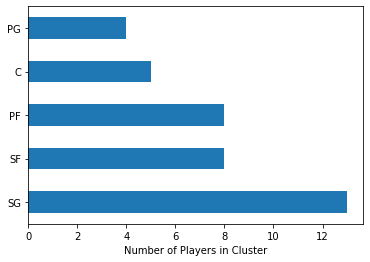

Cluster 1


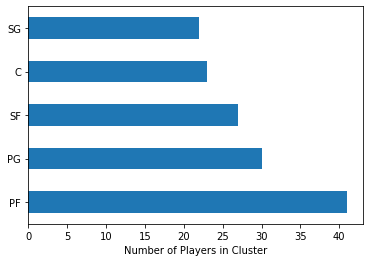

Cluster 2


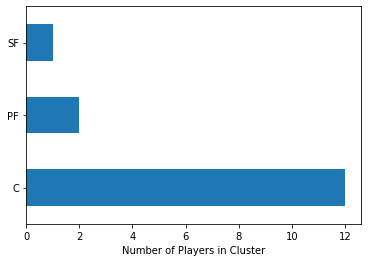

Cluster 3


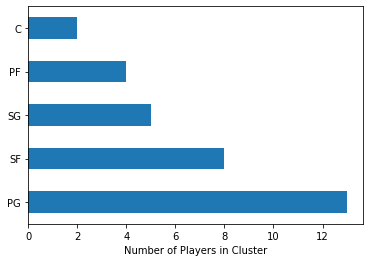

Cluster 4


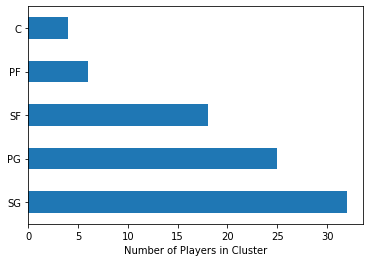

Cluster 5


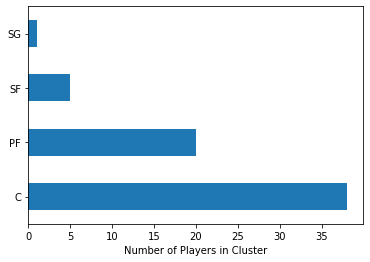

Cluster 6


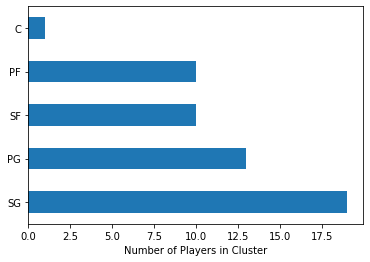

In [74]:
plot_cluster_positions(df_2017, 'kmeans_7')

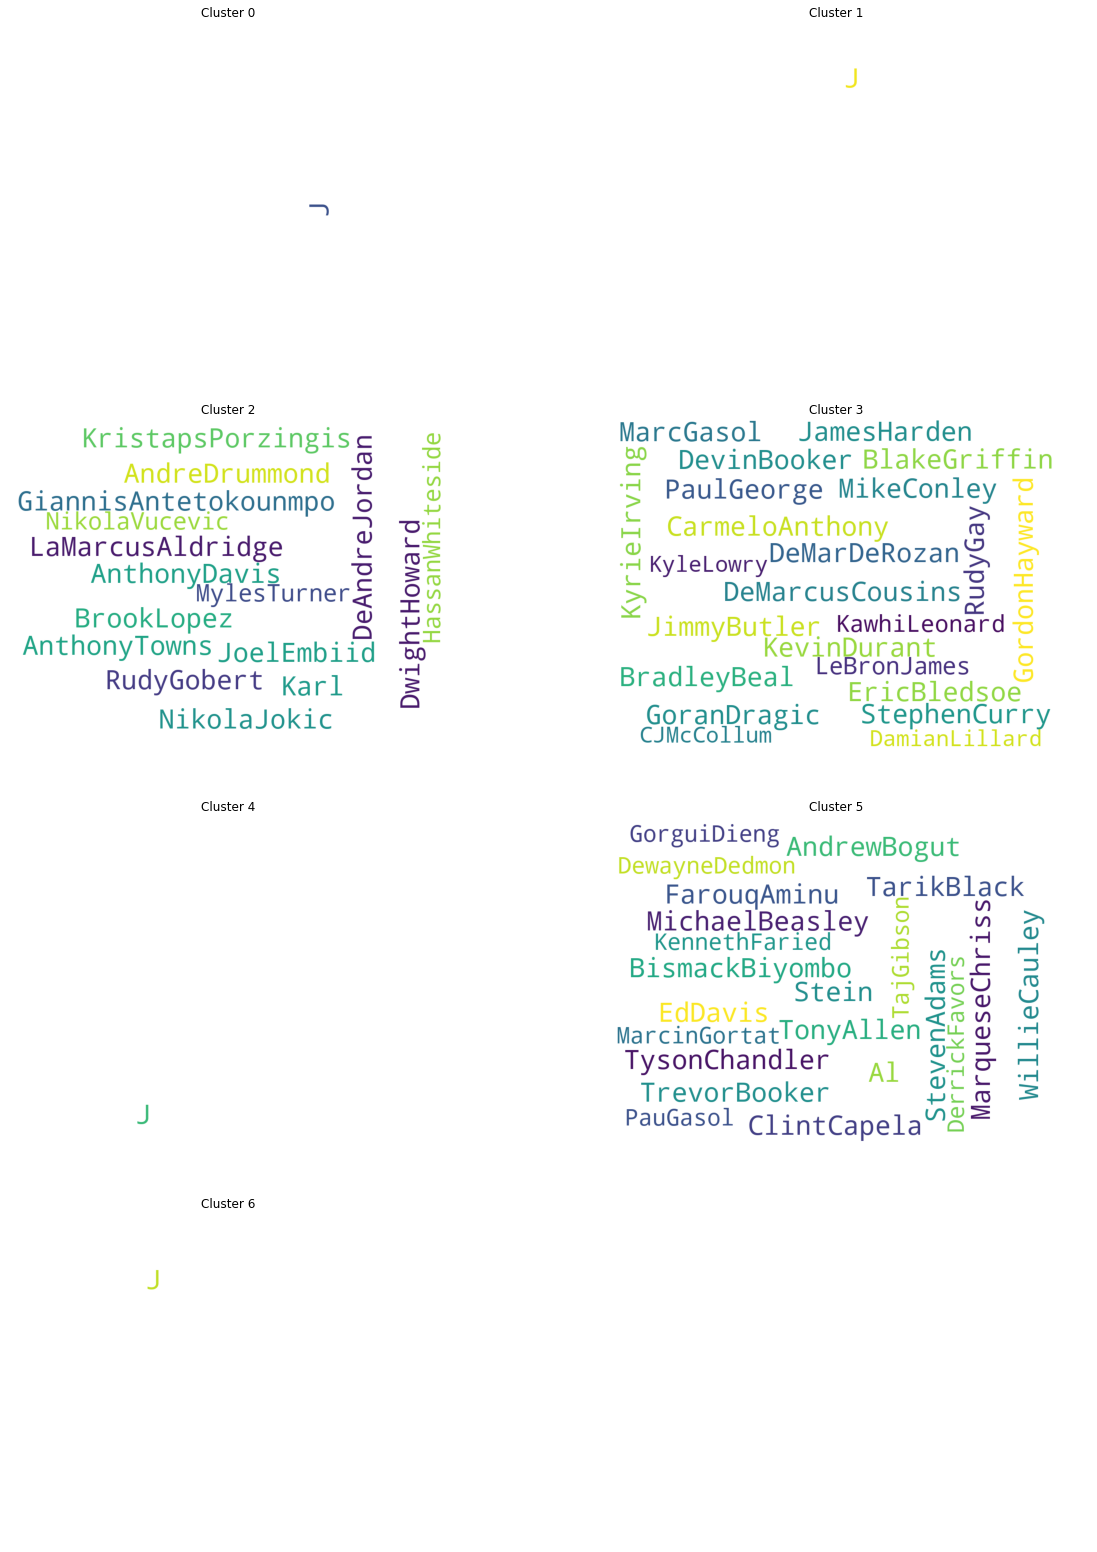

In [75]:
illustrate_clusters_subplots(df_2017, 7)

#### ANALYSIS
Clusters 2 and 3 are the 'star' clusters of this season. We see a return of the Point Guards and Centers, but curiously, the second-most frequent position in cluster 2 is the Small Forward.

So we might say that 2016-2017 is the season of the Centers, Point Guards, and Small Forwards.

### 6.6. Clustering 2015-2016 Season Players with KMeans

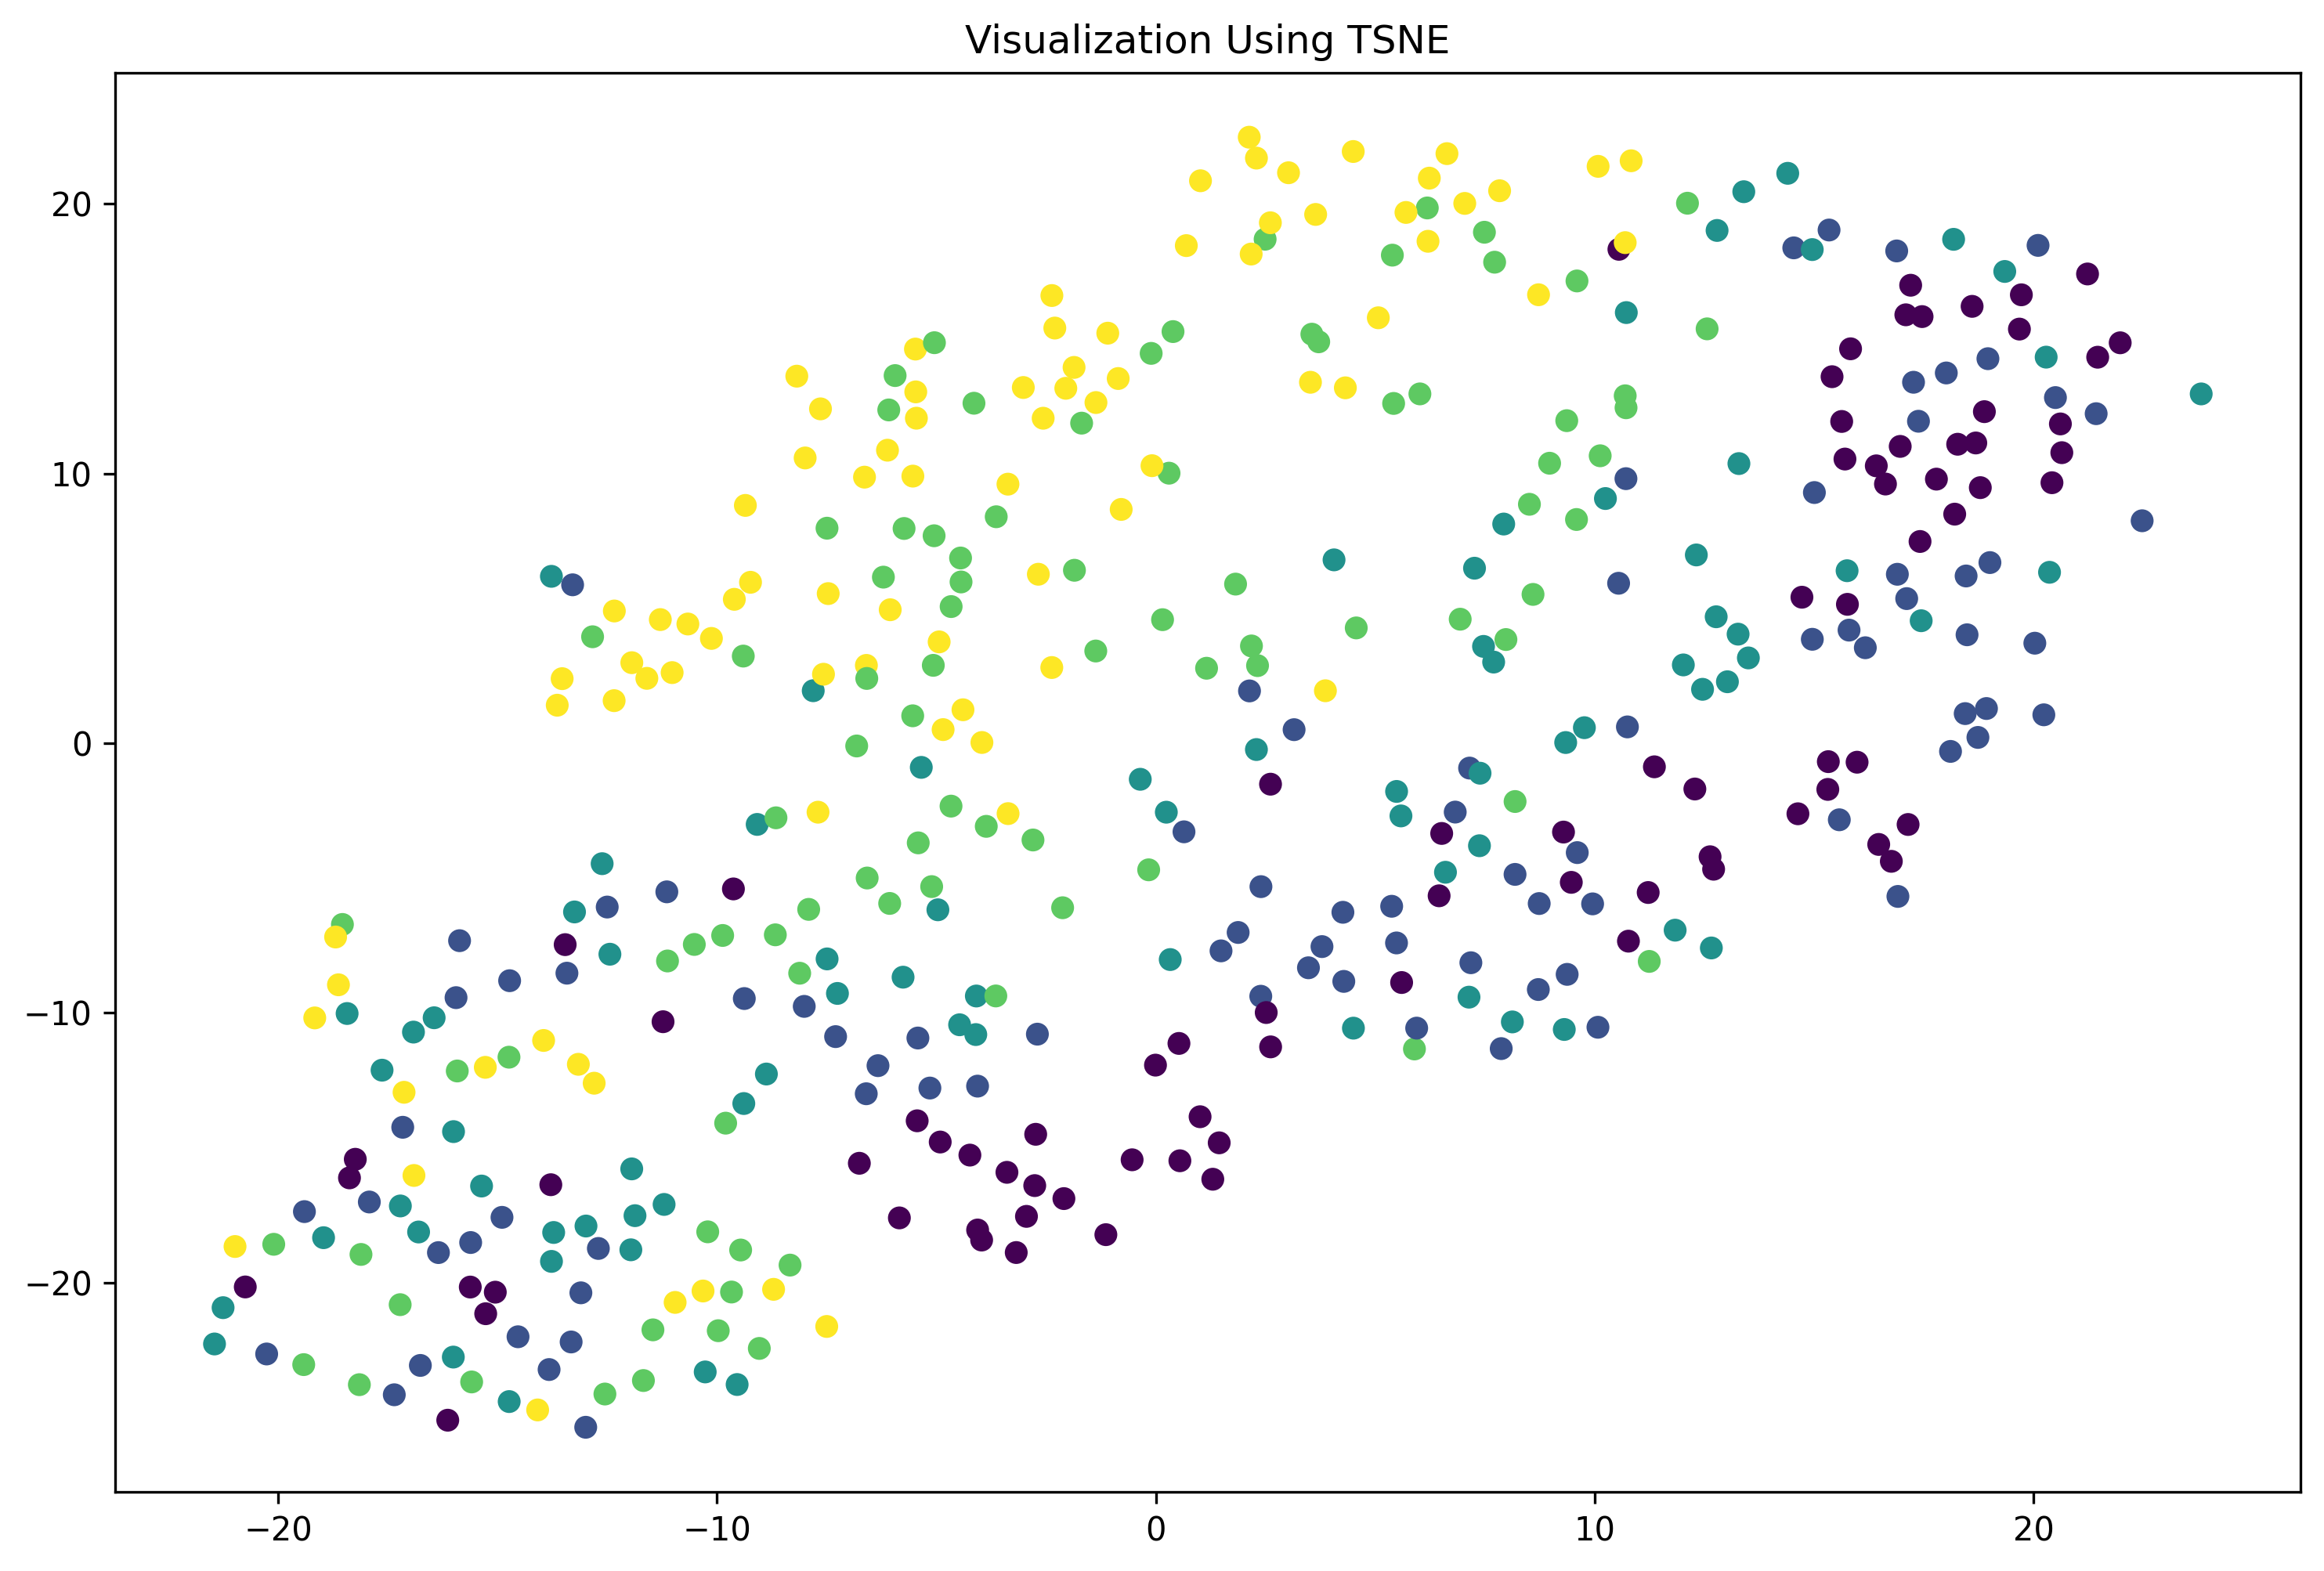

Legend:
	Purple: PG
	Blue: SG
	Blue-Green: SF
	Green: PF
	Yellow: C


In [76]:
df_2016 = read_year(2016, player_db)
df_2016 = df_2016[df_2016['G'] > 15]
df_2016['Pos'] = df_2016['Pos'].apply(replace_pos)
df_2016.loc[:, 'ITO'] = df_2016.loc[:, 'TOV'].apply(lambda x: 1/(x+0.00001))
df_2016.loc[:, 'IPF'] = df_2016.loc[:, 'PF'].apply(lambda x: 1/(x+0.00001))
df_2016_features = df_2016.drop(columns=to_drop+labels+maybe_drop).fillna(0.)
X = df_2016_features.to_numpy()
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
X_scaled = mm_scaler.transform(X)
if np.max(X_scaled[:, -3]) == 1.:
    X_scaled[:, -3] = X_scaled[:, -3] / 2
pos_2016 = df_2016['Pos'].apply(pos_to_num)
X_TSNE = TSNE(random_state=720).fit_transform(X_scaled)
plt.figure(dpi=300, figsize=(12, 8))
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=pos_2016)
plt.title('Visualization Using TSNE')
plt.show()
print("Legend:")
print("\tPurple: PG")
print("\tBlue: SG")
print("\tBlue-Green: SF")
print("\tGreen: PF")
print("\tYellow: C")

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!


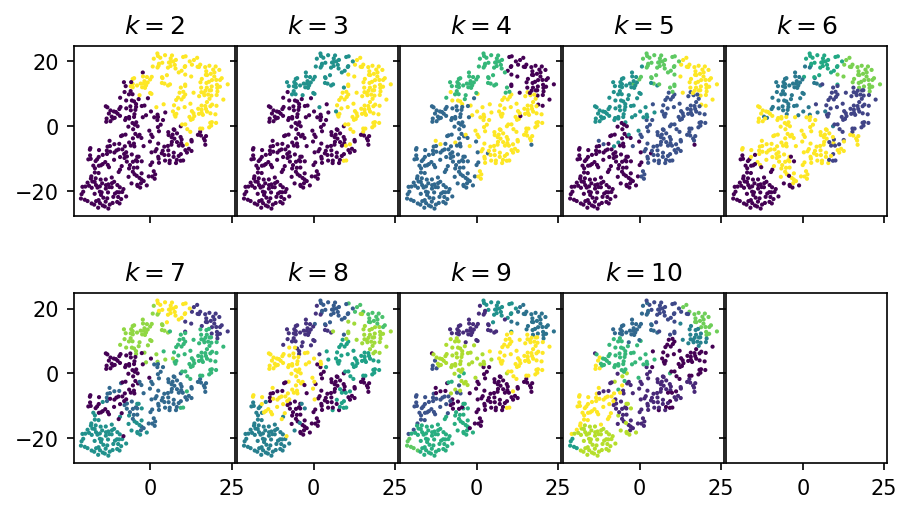

In [77]:
res_kmeans = cluster_range(X_scaled, KMeans(random_state=720), 2, 10)
plot_clusters(X_scaled, res_kmeans['ys'], X_TSNE)
plt.show()

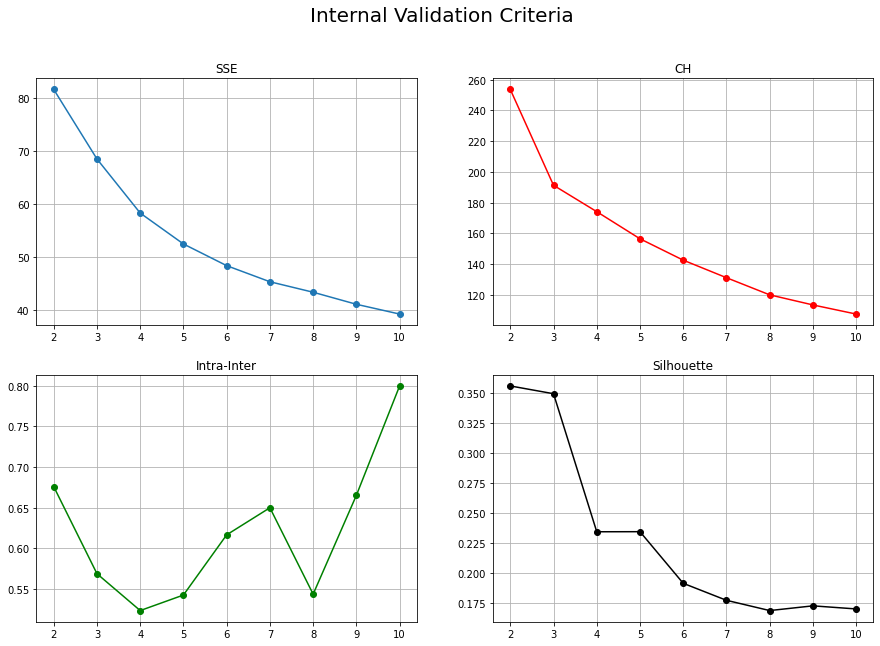

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Internal Validation Criteria", fontsize=20)
ax[0][0].plot(np.arange(2, len(res_kmeans['inertias'])+2), res_kmeans['inertias'], 'o-')
ax[0][0].set_xticks(np.arange(2, len(res_kmeans['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()
ax[0][1].plot(np.arange(2, len(res_kmeans['chs'])+2), res_kmeans['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_kmeans['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()
ax[1][0].plot(np.arange(2, len(res_kmeans['iidrs'])+2), res_kmeans['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_kmeans['iidrs'])+2))
ax[1][0].set_title("Intra-Inter")
ax[1][0].grid()
ax[1][1].plot(np.arange(2, len(res_kmeans['scs'])+2), res_kmeans['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_kmeans['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()
plt.show()

#### ANALYSIS

* **SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. A good range of values is **7+** because it is the 'elbow', or the area at which the absolute value of the slope of the graph suddenly decreased.

* **CH** - for Calinski-Harabasz index (CH), larger values are desirable. It is ambiguous what k to select based on the plot above.

* **Intra-Inter** - A lower value of intra-inter is preferable. Thus, **4-5**, or **8** clusters are optimal based on this measure.

* **Silhouette** - This coefficient is best if maximized. Although silhouette is maxed at 2 clusters, **5** clusters is the optimal number since it is the number before which silhouette coefficient suddenly decreased.

#### VERDICT

Try picking **5** clusters as suggested by Intra-Inter, and in the interest of parsimony.

In [79]:
y_predict_kmeans_5 = res_kmeans['ys'][3]
df_2016['kmeans_5'] = y_predict_kmeans_5
np.unique(y_predict_kmeans_5)

array([0, 1, 2, 3, 4])

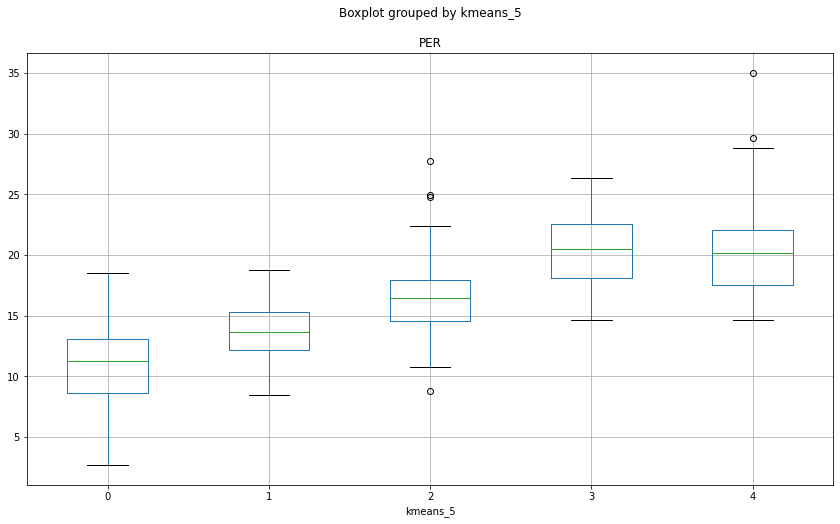

In [80]:
df_2016_complete = df_2016.copy()
try:
    df_2016_complete['FTMi'] = df_2016_complete.apply(lambda row: row['FTA']-row['FT'], axis=1)
    df_2016_complete['FGMi'] = df_2016_complete.apply(lambda row: row['FGA']-row['FG'], axis=1)
except:
    pass
df_2016_complete['PER'] = df_2016_complete.apply(get_lin_per, axis=1)
df_2016['PER'] = df_2016_complete['PER'].copy()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
df_2016.boxplot(column='PER', by='kmeans_5', ax=ax)
plt.show()

Cluster 0


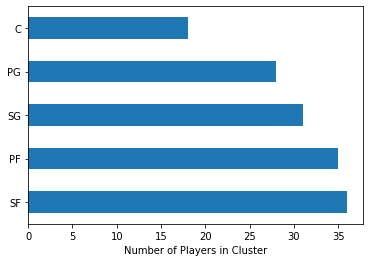

Cluster 1


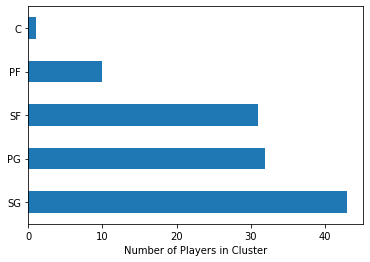

Cluster 2


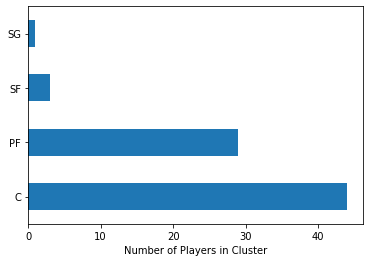

Cluster 3


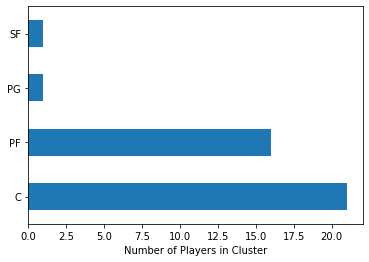

Cluster 4


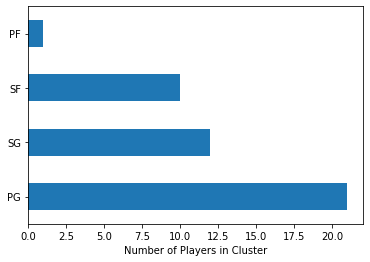

In [81]:
plot_cluster_positions(df_2016, 'kmeans_5')

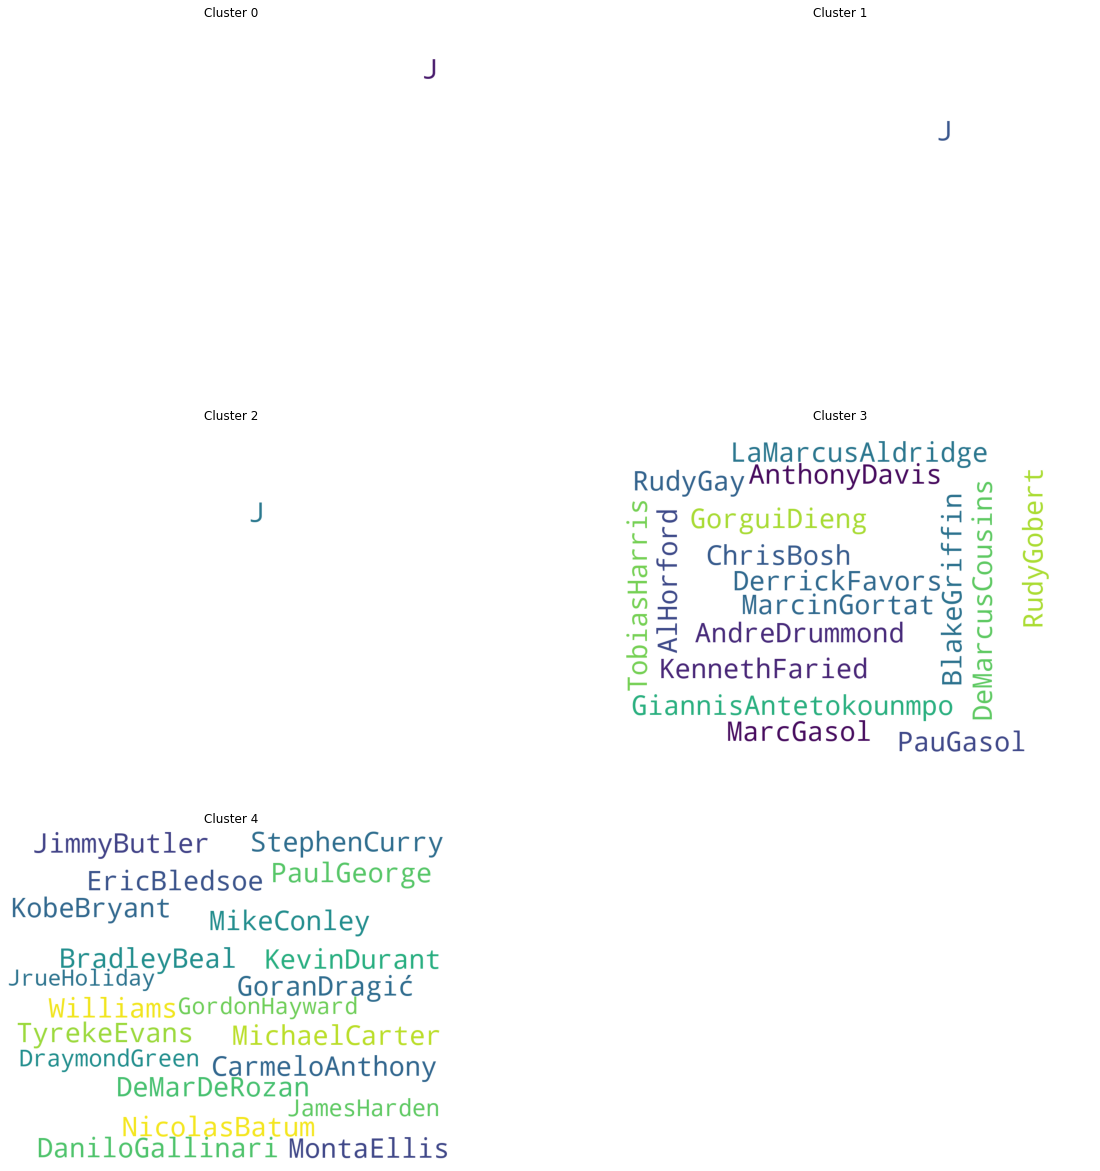

In [82]:
illustrate_clusters_subplots(df_2016, 5)

#### ANALYSIS
Clusters 3 and 4 are the 'star' clusters of this season. Cluster 3 remains the cluster of the Centers, but Power Forwards come at a close second in this cluster. Also, Shooting Guards make their return as second to the Point Guards in Cluster 4.

### 6.7. Clustering 2014-2015 Season Players with KMeans

In [83]:
df_2015 = read_year(2015, player_db)
df_2015 = df_2015[df_2015['G'] > 15]

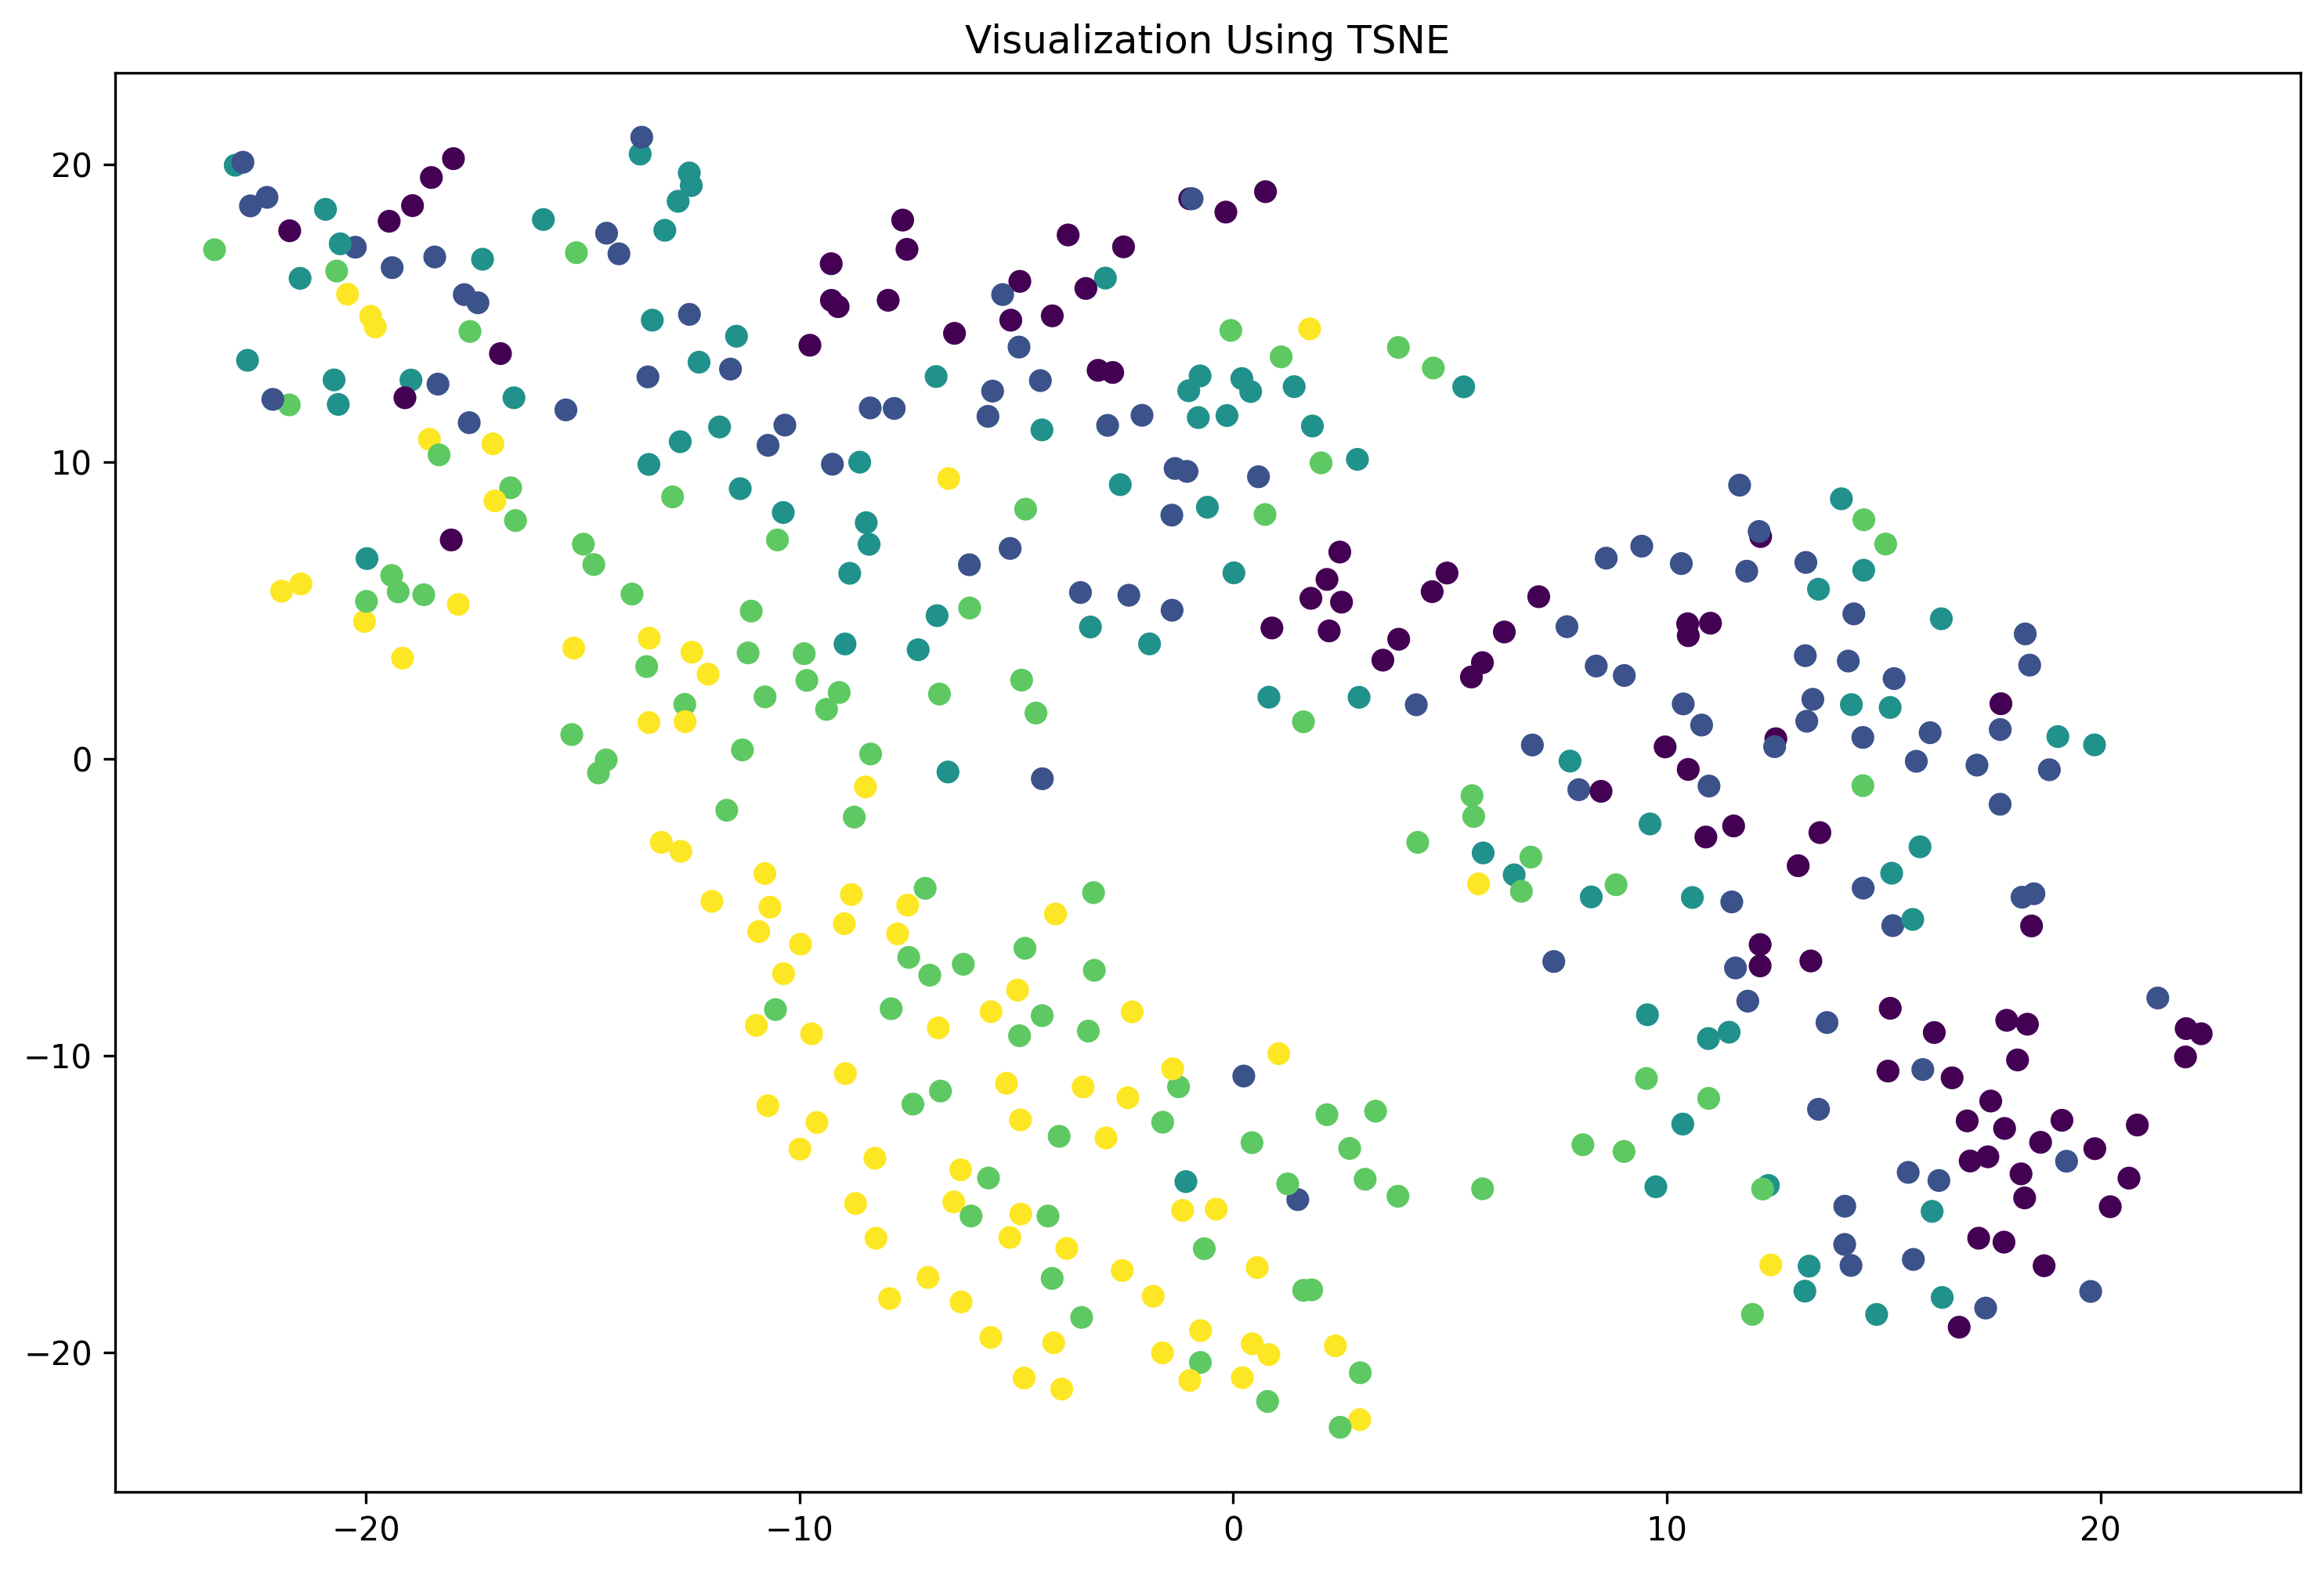

Legend:
	Purple: PG
	Blue: SG
	Blue-Green: SF
	Green: PF
	Yellow: C


In [84]:
df_2015['Pos'] = df_2015['Pos'].apply(replace_pos)
df_2015.loc[:, 'ITO'] = df_2015.loc[:, 'TOV'].apply(lambda x: 1/(x+0.00001))
df_2015.loc[:, 'IPF'] = df_2015.loc[:, 'PF'].apply(lambda x: 1/(x+0.00001))
df_2015_features = df_2015.drop(columns=to_drop+labels+maybe_drop).fillna(0.)
X = df_2015_features.to_numpy()
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
X_scaled = mm_scaler.transform(X)
if np.max(X_scaled[:, -3]) == 1.:
    X_scaled[:, -3] = X_scaled[:, -3] / 2
pos_2015 = df_2015['Pos'].apply(pos_to_num)
X_TSNE = TSNE(random_state=720).fit_transform(X_scaled)
plt.figure(dpi=300, figsize=(12, 8))
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=pos_2015)
plt.title('Visualization Using TSNE')
plt.show()
print("Legend:")
print("\tPurple: PG")
print("\tBlue: SG")
print("\tBlue-Green: SF")
print("\tGreen: PF")
print("\tYellow: C")

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!


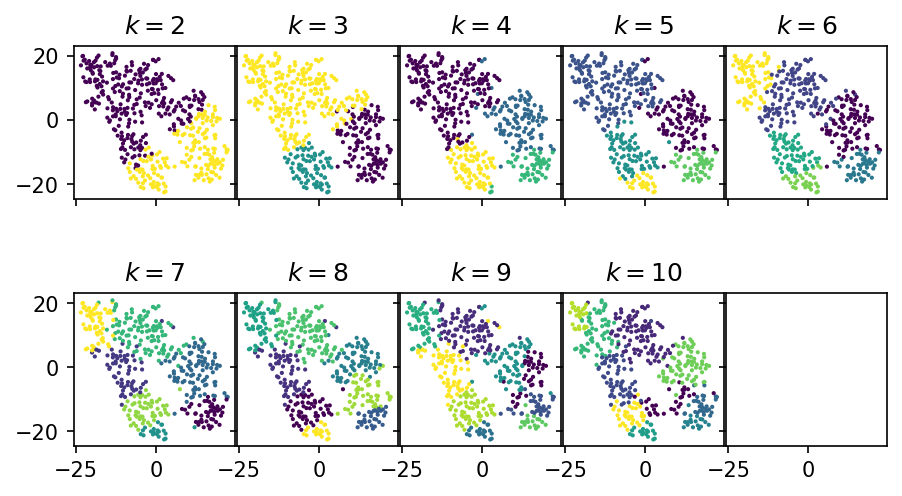

In [85]:
res_kmeans = cluster_range(X_scaled, KMeans(random_state=720), 2, 10)
plot_clusters(X_scaled, res_kmeans['ys'], X_TSNE)
plt.show()

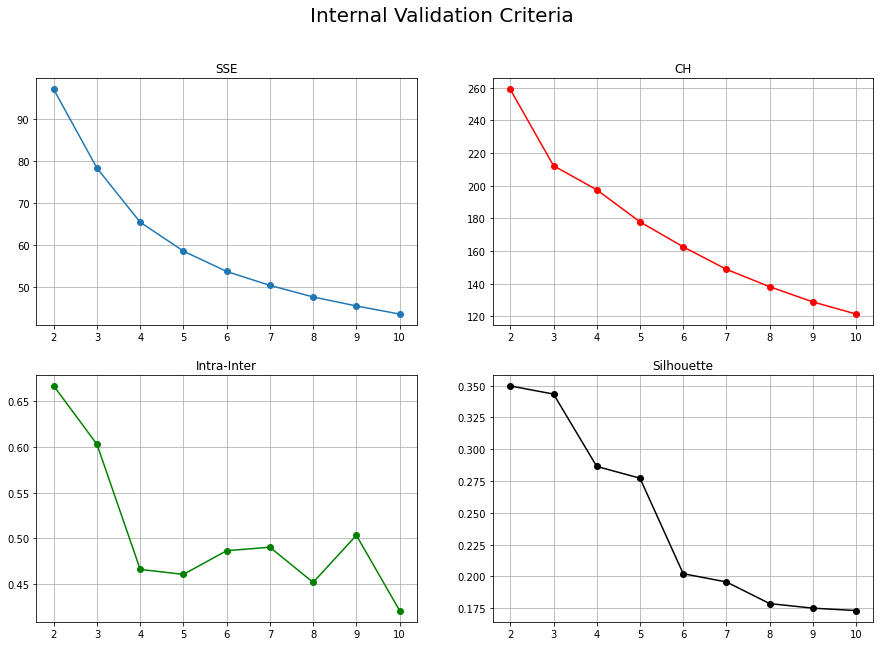

In [86]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Internal Validation Criteria", fontsize=20)
ax[0][0].plot(np.arange(2, len(res_kmeans['inertias'])+2), res_kmeans['inertias'], 'o-')
ax[0][0].set_xticks(np.arange(2, len(res_kmeans['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()
ax[0][1].plot(np.arange(2, len(res_kmeans['chs'])+2), res_kmeans['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_kmeans['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()
ax[1][0].plot(np.arange(2, len(res_kmeans['iidrs'])+2), res_kmeans['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_kmeans['iidrs'])+2))
ax[1][0].set_title("Intra-Inter")
ax[1][0].grid()
ax[1][1].plot(np.arange(2, len(res_kmeans['scs'])+2), res_kmeans['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_kmeans['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()
plt.show()

#### ANALYSIS

* **SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. A good range of values is **7+** because it is the 'elbow', or the area at which the absolute value of the slope of the graph suddenly decreased.

* **CH** - for Calinski-Harabasz index (CH), larger values are desirable. Based on the plot above, we might want to select **4** clusters.

* **Intra-Inter** - A lower value of intra-inter is preferable. Thus, **4**, or **7** clusters are optimal based on this measure.

* **Silhouette** - This coefficient is best if maximized. Although silhouette is maxed at 2 clusters, **4** clusters is the optimal number since it is the number before which silhouette coefficient suddenly decreased.

#### VERDICT

Try picking **5** clusters as suggested by Intra-Inter, and in the interest of parsimony.

In [87]:
y_predict_kmeans_5 = res_kmeans['ys'][3]
df_2015['kmeans_5'] = y_predict_kmeans_5
np.unique(y_predict_kmeans_5)

array([0, 1, 2, 3, 4])

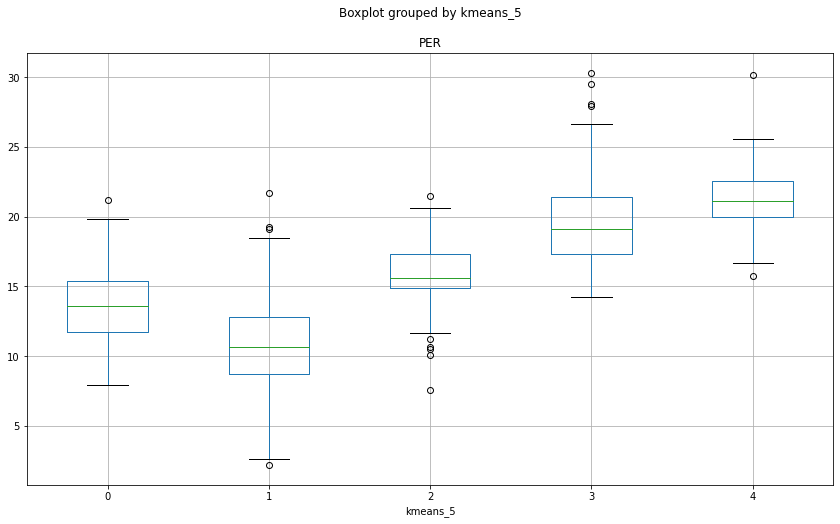

In [88]:
df_2015_complete = df_2015.copy()
try:
    df_2015_complete['FTMi'] = df_2015_complete.apply(lambda row: row['FTA']-row['FT'], axis=1)
    df_2015_complete['FGMi'] = df_2015_complete.apply(lambda row: row['FGA']-row['FG'], axis=1)
except:
    pass
df_2015_complete['PER'] = df_2015_complete.apply(get_lin_per, axis=1)
df_2015['PER'] = df_2015_complete['PER'].copy()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
df_2015.boxplot(column='PER', by='kmeans_5', ax=ax)
plt.show()

Cluster 0


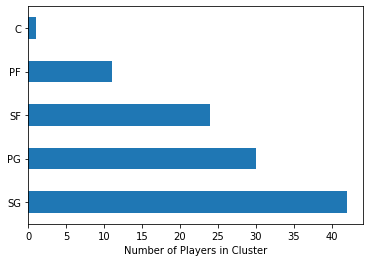

Cluster 1


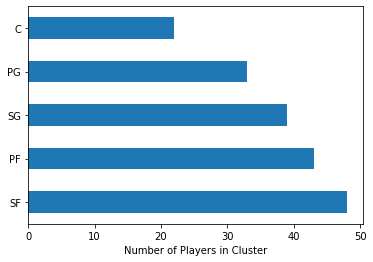

Cluster 2


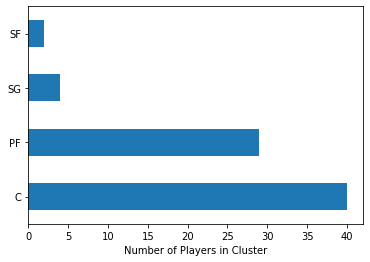

Cluster 3


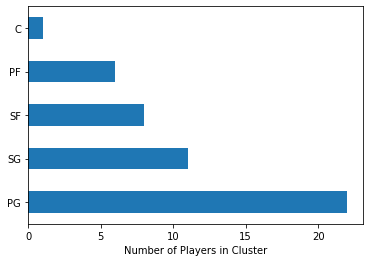

Cluster 4


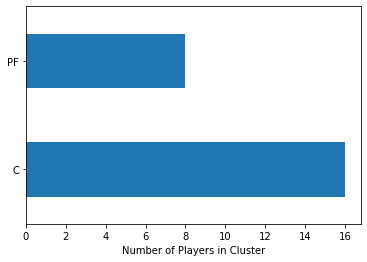

In [89]:
plot_cluster_positions(df_2015,'kmeans_5')

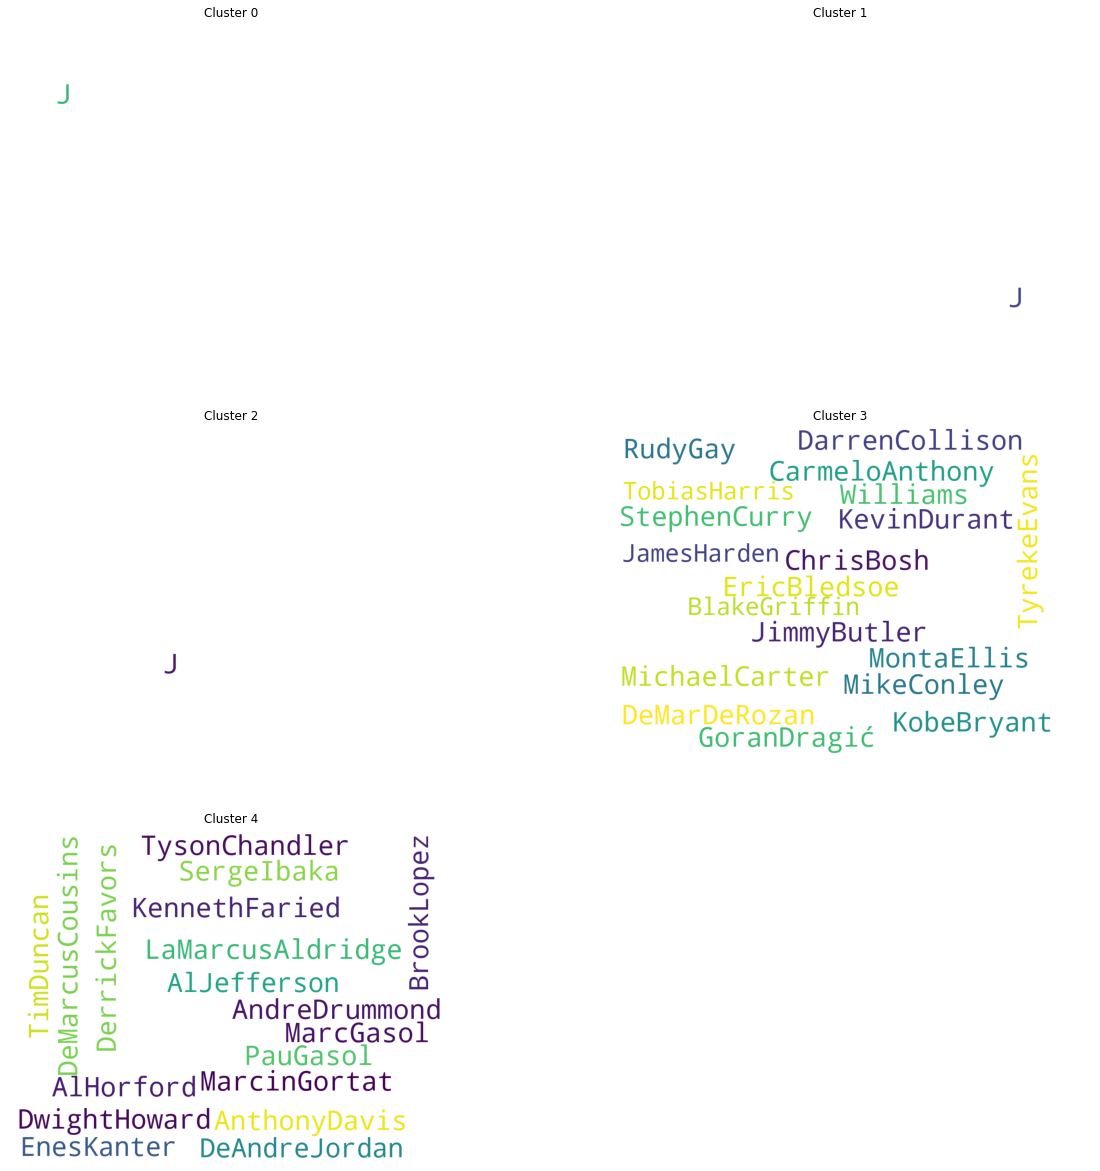

In [90]:
illustrate_clusters_subplots(df_2015, 5)

#### ANALYSIS
Clusters 3 and 4 are the 'star' clusters of this season. No different trends are seen this season.

## 7. Conclusions

### 7.1. General Findings

For each of the past five seasons, we have identified two standout clusters which contain players more highly-rated than those of the other clusters. By plotting the player positions in each of these clusters, we have discovered that one of the two clusters is composed mainly of Centers (sometimes with Power Forwards), and the other cluster is composed mainly of Point Guards (as well as Shooting Guards). This means that although players of both positions may stand out, they cannot be clustered together due to the fundamental differences in their playstyles.

There are two different possible interpretations for this:
1. <b>We are in the era of the star Point Guards and Centers.</b> In recent times, Point Guards and Centers have seen a climb in popularity, especially in the likes of star Center player Tim Duncan and 3-point specialist Stephen Curry. However, this theory does not account for the fact that star players also exist in other positions, particularly the Small Forward position in the persons of all-around player LeBron James, or in Kevin Durant, or even in recent Finals MVP Kawhi Leonard. On the other hand, it is also entirely possible that this theory holds, since the three aforementioned star SF players tend to be clustered in the star Point Guard cluster each year. This means that while exceptional players exist at the other positions, in terms of number they are trumped by the Point Guards and Centers.

2. <b>Since PG and C represent two opposing ends of the play spectrum, they may represent 'model' players.</b> This would explain why Shooting Guards are the second-most frequent position in the star PG cluster, and PF is the second-most frequent position in the star C cluster. Since SF is mid-way between the two, it appears the least frequently.

### 7.2. The Best of the Best

In this section, we will show the word clouds of the two best clusters for each of the five seasons. Our recommendation to coaches of NBA teams would be to watch out for the players that appear in these clusters. It is important to note that some of these players may have lower PER than some other players in the other clusters. However, the mere fact that they are clustered together with the best players indicates that they are similar to them in some way, and may imply that they have some star potential in them.

### 7.2.1. 2018-2019 Season Players to Watch Out For

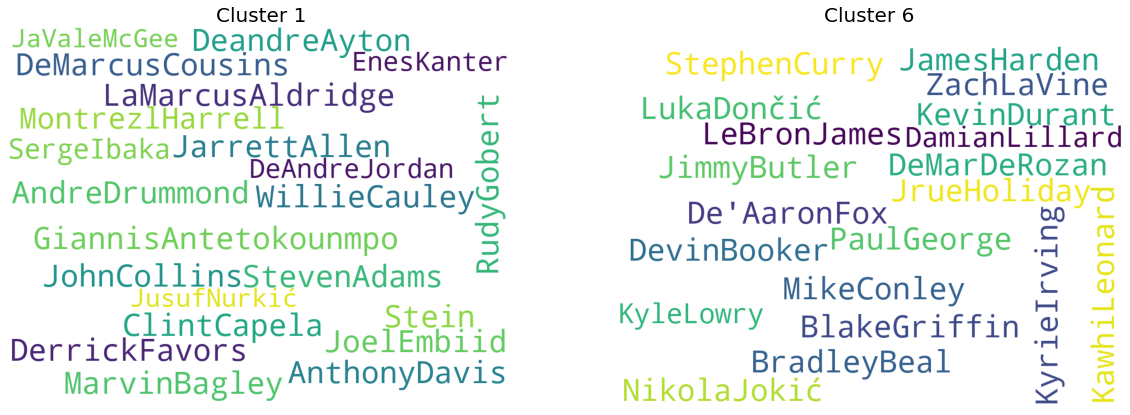

In [91]:
illustrate_clusters_particular(df, 1, 6)

### 7.2.2. 2017-2018 Season Players to Watch Out For

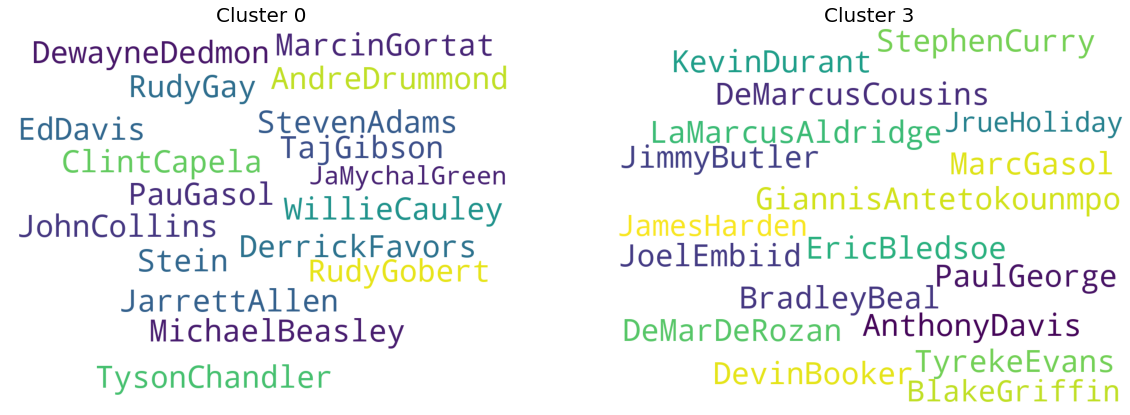

In [92]:
illustrate_clusters_particular(df_2018, 0, 3)

### 7.2.3. 2016-2017 Season Players to Watch Out For

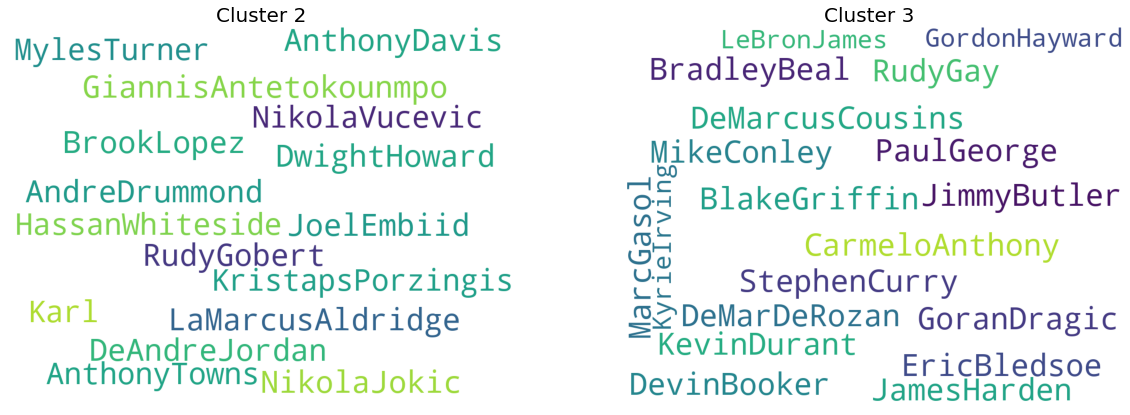

In [93]:
illustrate_clusters_particular(df_2017, 2, 3)

### 7.2.4. 2015-2016 Season Players to Watch Out For

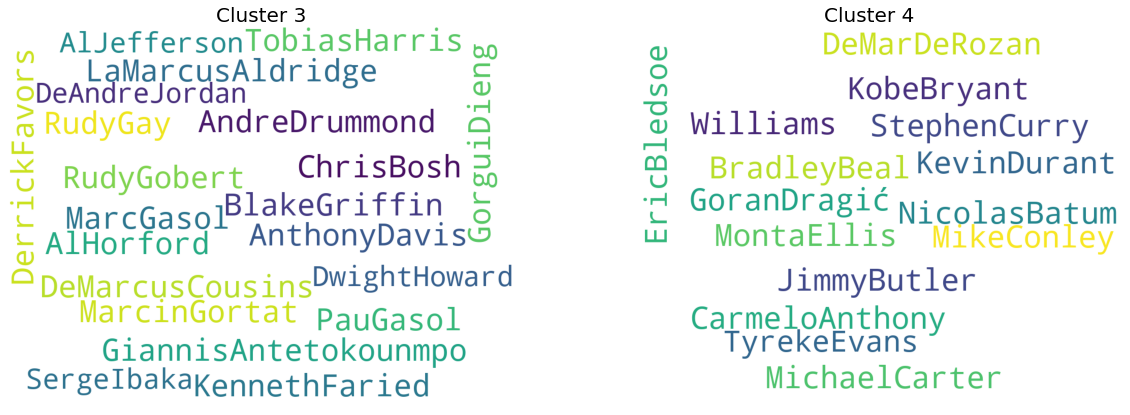

In [94]:
illustrate_clusters_particular(df_2016, 3, 4)

### 7.2.5. 2014-2015 Season Players to Watch Out For

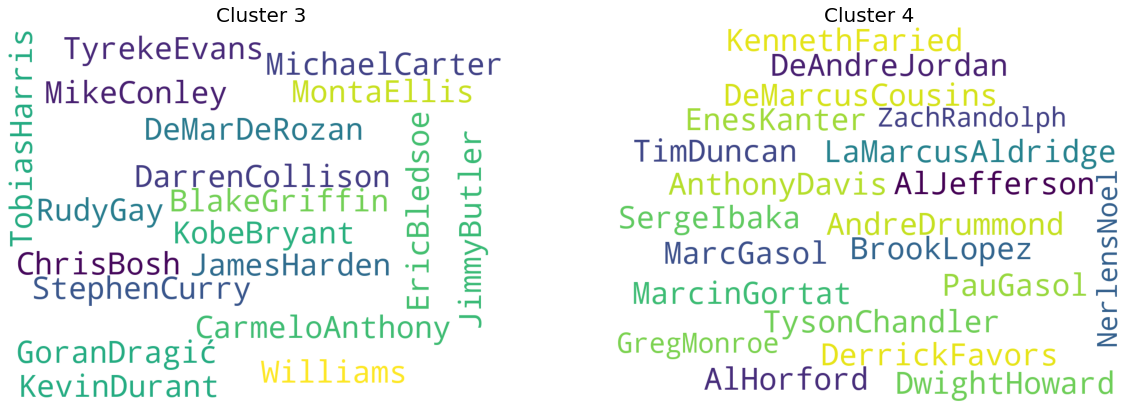

In [95]:
illustrate_clusters_particular(df_2015, 3, 4)

## 8. References

* Aksoy, S. and R.M. Haralick, 2001. *Feature normalization and likelihood-based similarity measures for image retrieval*. Pattern Recogn. Lett., 22: 563-582.
* Kubatko, J., Oliver, D., Pelton, K., and Rosenbaum, D., 2007. *A Starting Point for Analyzing Basketball Statistics*. Journal of Quantitative Analysis in Sports. 
* *Representative-based Clustering Notebook* by C. Alis / E. David, AIM (DMW Course Material)
* https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess